# Assignment: Responsible Machine Learning Class by Professor Hall

## Set up & fit models

In [1]:
import datetime                                               # for timestamp 
import time                                                   # for timers

import h2o                                                    # base h2o package for python
from h2o.estimators.gbm import H2OGradientBoostingEstimator   # h2o GBM
from h2o.grid.grid_search import H2OGridSearch                # h2o grid search
from h2o.automl import H2OAutoML                              # h2o auto machine learning models
import math                                                   # math functions

import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation

import xgboost as xgb                                         # base xgboost package for python


# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         40 mins 20 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.3
H2O_cluster_version_age:    20 days
H2O_cluster_name:           H2O_from_python_minhyekim_xa8ya3
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    5.891 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.5 final
--------------------------  ---------------------------------------------------------

In [2]:
# start global timer
tic = time.time()

In [3]:
# load datasets
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [4]:
# define features to use
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

In [5]:
# 70%/30% train/test split
split_ratio = 0.7 

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 111982, columns = 23
Validation data rows = 48356, columns = 23


In [6]:
# convert data to h2o frames
htrain = h2o.H2OFrame(train, column_types={'high_priced':'enum'})
hvalid = h2o.H2OFrame(valid, column_types={'high_priced':'enum'})

In [7]:
# set monotonic constraints for numerical columns
numeric_x_names = ['loan_amount_std', 'loan_to_value_ratio_std', 'intro_rate_period_std',
                   'property_value_std', 'income_std', 'debt_to_income_ratio_std']
mono = tuple([int(i) for i in np.sign(train[numeric_x_names + [y_name]].corr()[y_name].values[:-1])])
numeric_dict = dict(zip(numeric_x_names,mono))

binary_dict = {'conforming': 0, 'debt_to_income_ratio_missing': 0, 'no_intro_rate_period_std': 0, 'term_360': 0}

monotone_constraints = {**numeric_dict, **binary_dict}
monotone_constraints

{'loan_amount_std': -1,
 'loan_to_value_ratio_std': 1,
 'intro_rate_period_std': -1,
 'property_value_std': -1,
 'income_std': -1,
 'debt_to_income_ratio_std': 1,
 'conforming': 0,
 'debt_to_income_ratio_missing': 0,
 'no_intro_rate_period_std': 0,
 'term_360': 0}

### MGBM _ H2O Gradient Boosting Estimator

In [8]:
# preserve exact reproducibility
np.random.seed(SEED)

# start local timer
gbm_tic = time.time()

# train a mgbm model
best_gbm = H2OGradientBoostingEstimator(
    
    ntrees = 10000,                                                            

    ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
    learn_rate = 0.01,                                                         

    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC",                                                  

    ## sample 80% of columns per split
    col_sample_rate = 0.8,                                                   

    ## fix the seed for reproducibility
    seed = SEED,                                                             

    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10,
                                  
    ## monotonic constraints
    monotone_constraints=monotone_constraints)

best_gbm.train(x=x_names, y=y_name, training_frame=htrain, validation_frame=hvalid)

# end local timer
gbm_toc = time.time() - gbm_tic

print('GBM training completed in %.2f s.' % (gbm_toc))

GBM training completed in 63.40 s.


In [9]:
# create a submission file
best_gbm_submit = best_gbm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_gbm_submit.drop(['predict', '0.0'], axis=1, inplace=True)
best_gbm_submit.columns = ['phat']
best_gbm_submit.to_csv('group5_mgbm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### H2O Explain


00:24:03.68: AutoML: XGBoost is not available; skipping it.



# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id auc logloss aucpr mean_per_class_error rmse mse training_time_ms predict_time_per_row_ms algo 
 
 
 StackedEnsemble_AllModels_AutoML_20210609_002403 0.819913 0.255802 0.29257 0.287249 0.276565 0.0764881 3757 0.019809 StackedEnsemble 
 GBM_2_AutoML_20210609_002403 0.819052 0.261273 0.291056 0.273882 0.277538 0.0770273 1196 0.005673 GBM 
 StackedEnsemble_BestOfFamily_AutoML_20210609_002403 0.818739 0.256368 0.290484 0.279961 0.276789 0.0766121 2439 0.005854 StackedEnsemble 
 GBM_3_AutoML_20210609_002403 0.818446 0.262968 0.29077 0.282646 0.277881 0.0772181 1158 0.002389 GBM 
 GBM_grid__1_AutoML_20210609_002403_model_2 0.817064 0.257657 0.284891 0.273174 0.277207 0.076844 2854 0.005132 GBM 
 GBM_4_AutoML_20210609_002403 0.816987 0.265256 0.287418 0.283592 0.27854 0.0775843 1214 0.002246 GBM 
 GBM_1_AutoML_20210609_002403 0.816746 0.262165 0.288903 0.277084 0.27795 0.0772563 1260 0.002415 GBM 
 GBM_5_AutoML_20210609_002403 0.815036 0.269442 0.282996 0.285764 0.279873 0.0783286 1196 0.002181 GBM 
 GBM_grid__1_AutoML_20210609_002403_model_1 0.814985 0.258864 0.277446 0.268331 0.277755 0.077148 3152 0.005251 GBM 
 DeepLearning_1_AutoML_20210609_002403 0.793828 0.268604 0.245228 0.287661 0.281341 0.0791526 466 0.001714 DeepLearning 
 GBM_grid__1_AutoML_20210609_002403_model_3 0.789378 0.285731 0.2445 0.292677 0.285728 0.0816404 371 0.001386 GBM 
 DeepLearning_grid__1_AutoML_20210609_002403_model_1 0.788693 0.276221 0.252566 0.306807 0.281374 0.0791715 533 0.001748 DeepLearning 
 DeepLearning_grid__1_AutoML_20210609_002403_model_2 0.784415 0.277623 0.240732 0.314102 0.283094 0.0801422 291 0.001545 DeepLearning 
 DeepLearning_grid__2_AutoML_20210609_002403_model_1 0.776645 0.273377 0.223879 0.293088 0.283227 0.0802176 1076 0.00392 DeepLearning 
 DeepLearning_grid__3_AutoML_20210609_002403_model_1 0.774382 0.27541 0.227959 0.295884 0.28338 0.0803044 1640 0.00575 DeepLearning 
 XRT_1_AutoML_20210609_002403 0.770692 0.354694 0.229844 0.334106 0.289702 0.083927 1319 0.002257 DRF 
 DRF_1_AutoML_20210609_002403 0.766143 0.466752 0.229238 0.287984 0.293343 0.0860503 1200 0.002683 DRF 
 GLM_1_AutoML_20210609_002403 0.751884 0.299962 0.219661 0.335299 0.290469 0.0843721 3212 0.000697 GLM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210609_002403


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1841705855944178: 


0.0     1.0   Error              Rate
0    0.0  7393.0  1568.0   0.175   (1568.0/8961.0)
1    1.0   353.0   606.0  0.3681     (353.0/959.0)
2  Total  7746.0  2174.0  0.1936   (1921.0/9920.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

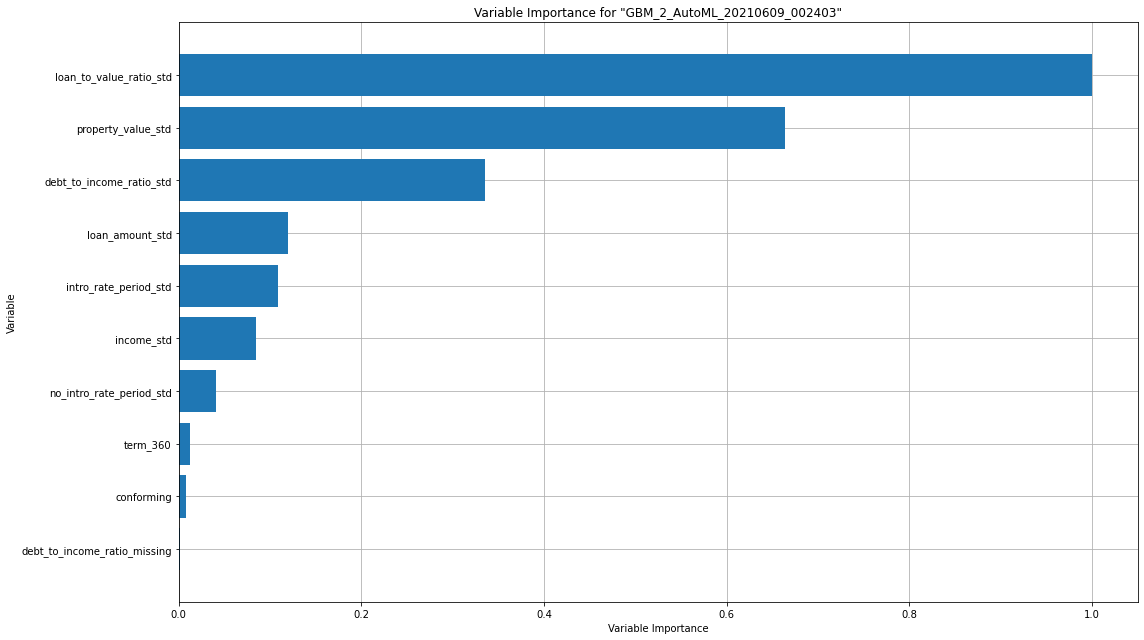

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

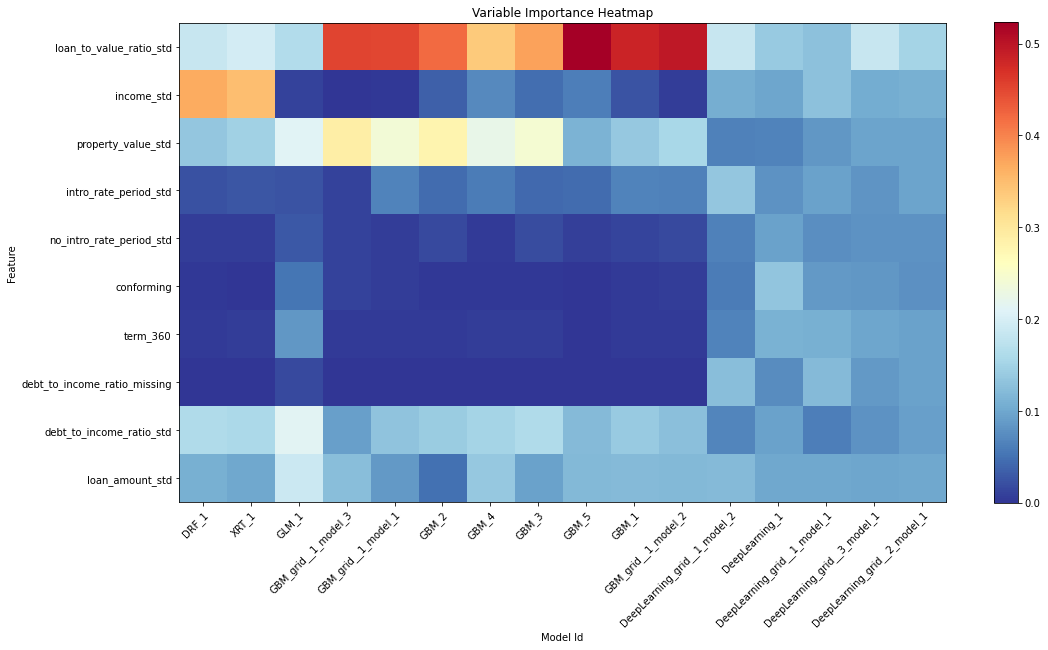

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

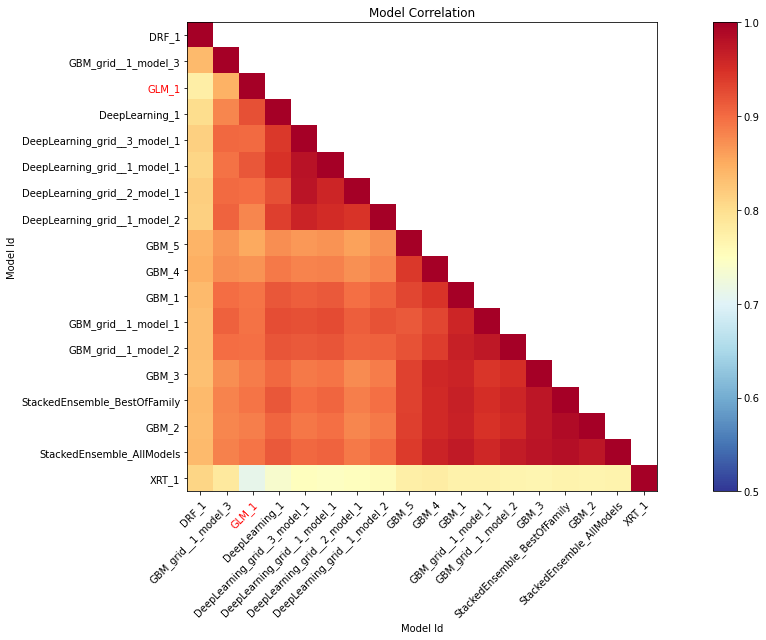

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

C:\Users\minhyekim\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:514: RuntimeWarning: invalid value encountered in true_divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


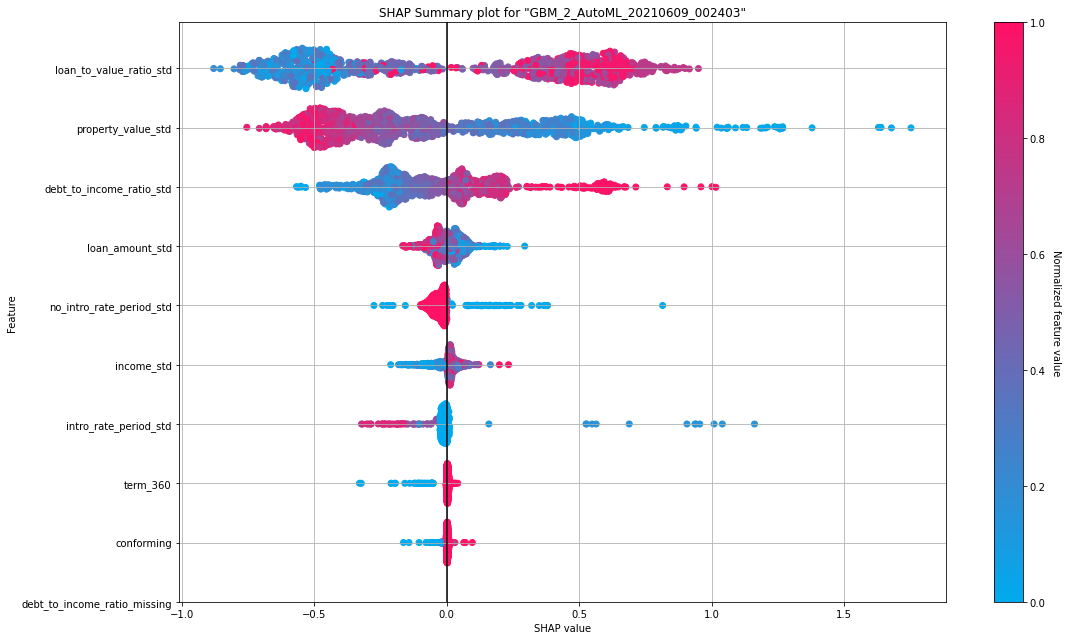

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

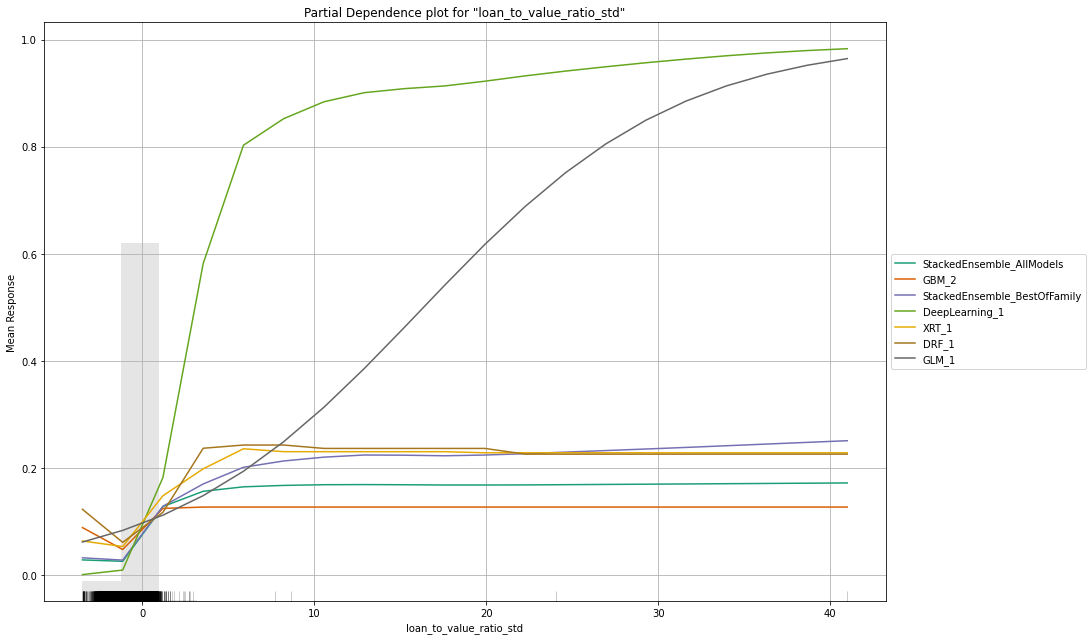

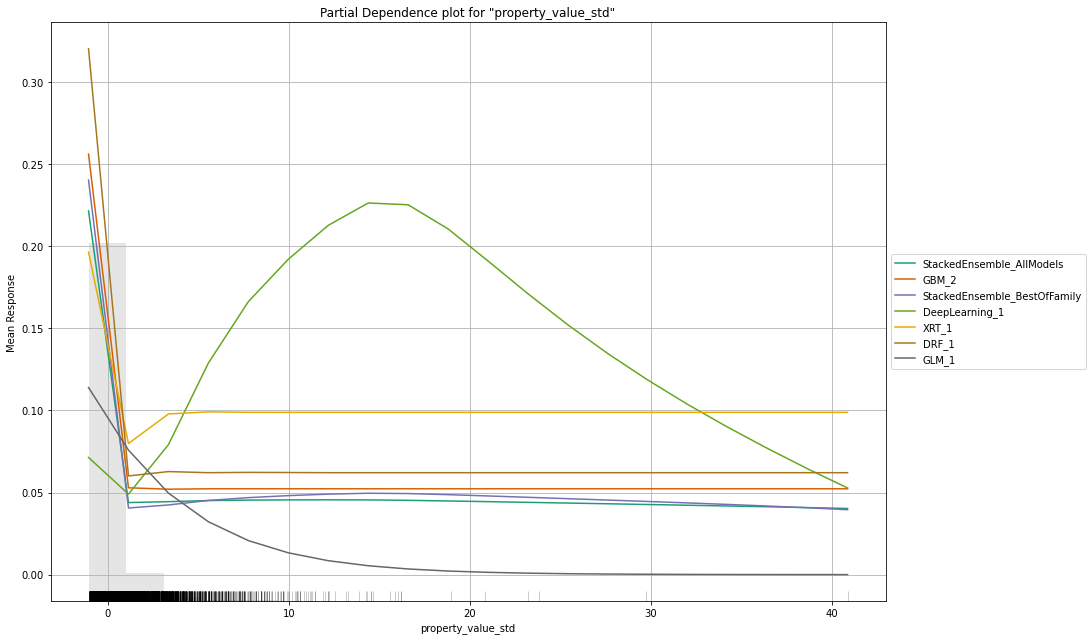

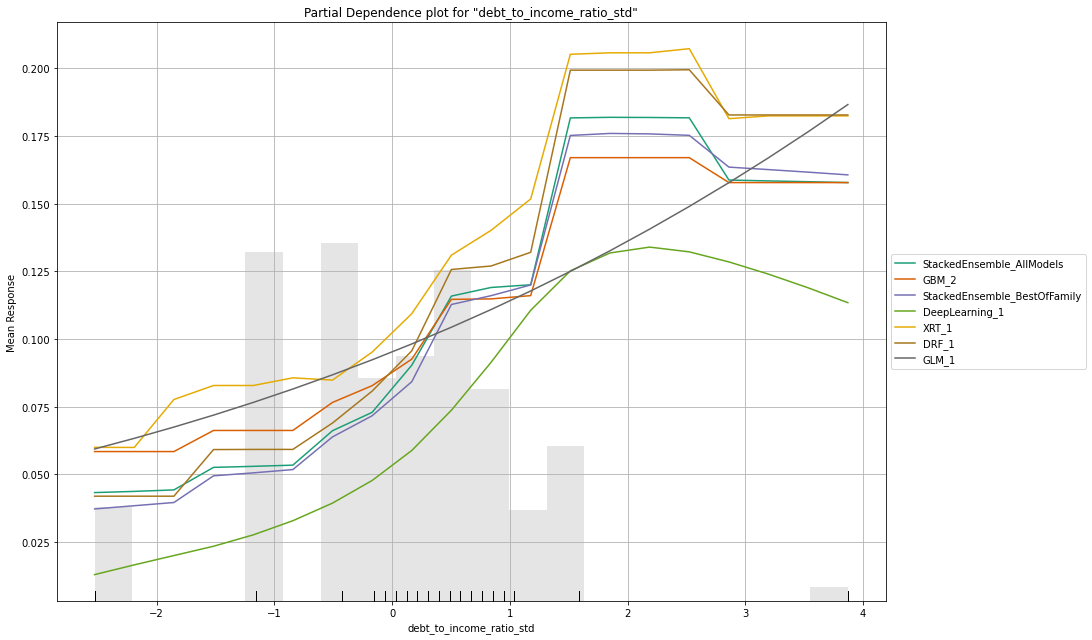

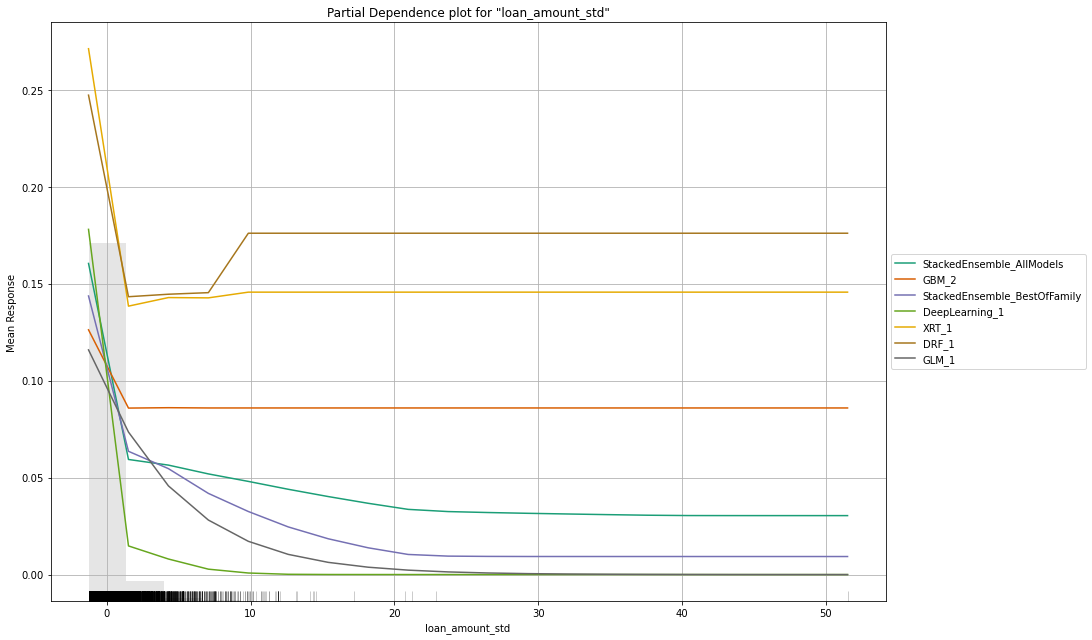

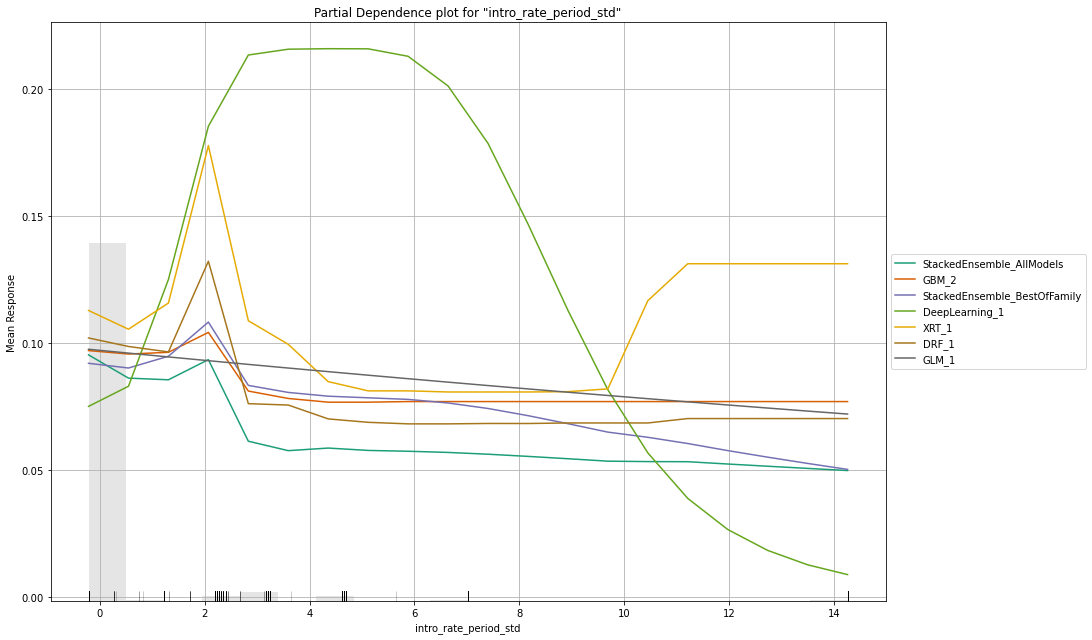

In [10]:
# preserve exact reproducibility
np.random.seed(SEED)

# use top models for submission

# Run AutoML for 3 minutes
aml = H2OAutoML(max_runtime_secs=180, seed=SEED)
aml.train(x=x_names, y=y_name, training_frame=htrain)

# Explain leader model & compare with all AutoML models
exa = aml.explain(hvalid)

In [11]:
lb = aml.leaderboard
lb

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 StackedEnsemble_AllModels_AutoML_20210609_002403 0.819913 0.255802 0.29257 0.287249 0.276565 0.0764881 
 GBM_2_AutoML_20210609_002403 0.819052 0.261273 0.291056 0.273882 0.277538 0.0770273 
 StackedEnsemble_BestOfFamily_AutoML_20210609_002403 0.818739 0.256368 0.290484 0.279961 0.276789 0.0766121 
 GBM_3_AutoML_20210609_002403 0.818446 0.262968 0.29077 0.282646 0.277881 0.0772181 
 GBM_grid__1_AutoML_20210609_002403_model_2 0.817064 0.257657 0.284891 0.273174 0.277207 0.076844 
 GBM_4_AutoML_20210609_002403 0.816987 0.265256 0.287418 0.283592 0.27854 0.0775843 
 GBM_1_AutoML_20210609_002403 0.816746 0.262165 0.288903 0.277084 0.27795 0.0772563 
 GBM_5_AutoML_20210609_002403 0.815036 0.269442 0.282996 0.285764 0.279873 0.0783286 
 GBM_grid__1_AutoML_20210609_002403_model_1 0.814985 0.258864 0.277446 0.268331 0.277755 0.077148 
 DeepLearning_1_AutoML_20210609_002403 0.793828 0.268604 0.245228 0.287661 0.281341 0.0791526

### ENSENBLE _ H2O AUTOML

In [12]:
ensenble_h2o = h2o.get_model(lb[0,"model_id"])

In [13]:
# create a submission file
ensenble_submit = ensenble_h2o.predict(h2o.H2OFrame(test)).as_data_frame() 
ensenble_submit.drop(['predict', '0.0'], axis=1, inplace=True)
ensenble_submit.columns = ['phat']
ensenble_submit.to_csv('group5_ensenble_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### GBM _ H2O AUTOML

In [16]:
gbm_h2o = h2o.get_model(lb[1,"model_id"])

In [17]:
# create a submission file
gbm_submit = gbm_h2o.predict(h2o.H2OFrame(test)).as_data_frame() 
gbm_submit.drop(['predict', '0.0'], axis=1, inplace=True)
gbm_submit.columns = ['phat']
gbm_submit.to_csv('group5_gbm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

## Calculate and Plot Global Feature Importance.

### MGBM

In [18]:
import shap

shap.initjs()

In [19]:
# must convert from Pandas to H2OFrame ... and back again ... wasteful
shap_contribs_hf = best_gbm.predict_contributions(h2o.H2OFrame(valid))
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 2.48626322e-02  4.25437726e-02 -4.36210190e-04 ...  4.41022683e-03
   3.97560075e-02 -2.93043876e+00]
 [ 2.73115318e-02  3.95920500e-03 -4.23004065e-04 ...  1.03141619e-02
   3.24757010e-01 -2.93043876e+00]
 [ 3.08780130e-02  5.10754855e-03 -4.14890994e-04 ...  5.00377920e-03
   3.41694623e-01 -2.93043876e+00]
 ...
 [ 3.73936184e-02  7.50086363e-03 -4.45956772e-04 ... -1.35175698e-02
  -5.47412395e-01 -2.93043876e+00]
 [ 4.40505445e-02  8.30681436e-03 -4.30230575e-04 ...  1.47339441e-02
  -4.82881702e-02 -2.93043876e+00]
 [-9.13815320e-01  4.55789408e-03 -4.97886853e-04 ... -2.99399123e-02
  -6.01463616e-01 -2.93043876e+00]]

Shapley contributions rows = 48356, columns = 11


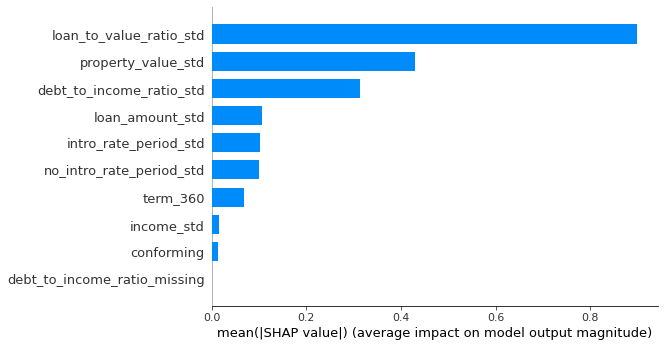

In [20]:
shap_contribs = shap_contribs_matrix[:,:-1] # remove constant intercept column
shap.summary_plot(shap_contribs, x_names, plot_type='bar', title='Variable Importance: MGBM') # use shap package for nice bar plot

### GBM

In [21]:
gbm_h2o

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20210609_002403


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               16.0                      16.0              23032.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        7.0        7.0         7.0        96.0       123.0      110.125



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0760615950122606
RMSE: 0.2757926667122616
LogLoss: 0.25796311683687545
Mean Per-Class Error: 0.23437202724505357
AUC: 0.8300673853545691
AUCPR: 0.3195264686662722
Gini: 0.6601347707091383

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16963304520381733: 


0.0      1.0   Error                 Rate
0    0.0  83283.0  17819.0  0.1762   (17819.0/101102.0)
1    1.0   4148.0   6732.0  0.3812     (4148.0/10880.0)
2  Total  87431.0  24551.0  0.1962   (21967.0/111982.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.169633       0.380006  188.0
1                        max f2   0.112976       0.544740  254.0
2                  max f0point5   0.230620       0.334611  124.0
3                  max accuracy   0.351383       0.904065   57.0
4                 max precision   0.746032       1.000000    0.0
5                    max recall   0.023297       1.000000  399.0
6               max specificity   0.746032       1.000000    0.0
7              max absolute_mcc   0.118296       0.328720  248.0
8    max min_per_class_accuracy   0.140447       0.750827  223.0
9   max mean_per_class_accuracy   0.112976       0.765628  254.0
10                      max tns   0.746032  101102.000000    0.0
11                      max fns   0.746032   10879.000000    0.0
12                      max fps   0.023297  101102.000000  399.0
13                      max tps   0.023297   10880.000000  399.0
14                      max tnr   0.746032       1.000000    0.0
15                      max fnr   0.746032       0.999908    0.0
16                      max fpr   0.023297       1.000000  399.0
17                      max tpr   0.023297       1.000000  399.0


Gains/Lift Table: Avg response rate:  9.72 %, avg score:  9.81 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010046         0.325614  5.553356   
1       2                  0.020021         0.289481  4.072756   
2       3                  0.030523         0.271124  3.780905   
3       4                  0.040658         0.259378  3.228297   
4       5                  0.050196         0.250128  3.083884   
5       6                  0.100239         0.220336  2.848610   
6       7                  0.150310         0.195860  2.505656   
7       8                  0.200077         0.177288  2.227294   
8       9                  0.300039         0.138472  1.784677   
9      10                  0.400020         0.094014  1.218989   
10     11                  0.500018         0.059639  0.635122   
11     12                  0.600016         0.042585  0.292285   
12     13                  0.700586         0.032793  0.140742   
13     14                  0.800191         0.027800  0.083971   
14     15                  0.900163         0.025294  0.048727   
15     16                  1.000000         0.023026  0.024857   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          5.553356       0.539556  0.397127                  0.539556   
1          4.815698       0.395703  0.302054                  0.467886   
2          4.459666       0.367347  0.278600                  0.433294   
3          4.152703       0.313656  0.265653                  0.403470   
4          3.949625       0.299625  0.252855                  0.383740   
5          3.399951       0.276767  0.234027                  0.330334   
6          3.102048       0.243446  0.209384                  0.301390   
7          2.884462       0.216401  0.186190                  0.280250   
8          2.518053       0.173396  0.156323                  0.244650   
9          2.193367       0.118435  0.116237                  0.213104   
10         1.881734       0.061707  0.075655                  0.182826   
11         1.616838       0.028398  0.049663                  0.157089   
12         1.404943       0.013674  0.037452                  0.136502   
13         1.240512       0.008159  0.029980                  0.120526   
14         1.108154       0.004734  0.026570                  0.107667   
15         1.000000       0.002415  0.024346                  0.097158   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.397127      0.055790                 0.055790  455.335572   
1           0.349760      0.040625                 0.096415  307.275627   
2           0.325276      0.039706                 0.136121  278.090486   
3           0.310413      0.032721                 0.168842  222.829684   
4           0.299477      0.029412                 0.198254  208.388412   
5           0.266801      0.142555                 0.340809  184.861001   
6           0.247675      0.125460                 0.466268  150.565584   
7           0.232381      0.110846                 0.577114  122.729422   
8           0.207041      0.178401                 0.755515   78.467671   
9           0.184346      0.121875                 0.877390   21.898948   
10          0.162609      0.063511                 0.940901  -36.487836   
11          0.143785      0.029228                 0.970129  -70.771537   
12          0.128521      0.014154                 0.984283  -85.925774   
13          0.116255      0.008364                 0.992647  -91.602885   
14          0.106295      0.004871                 0.997518  -95.127284   
15          0.098113      0.002482                 1.000000  -97.514343   

    cumulative_gain  kolmogorov_smirnov  
0        455.335572            0.050667  
1        381.569756            0.084615  
2        345.966590            0.116962  
3        315.270261            0.141978  
4        294.962519            0.163991  
5        239.995133            0.266458  
6        210.204765            0.349960  
7        1



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07702733872478637
RMSE: 0.27753799510118676
LogLoss: 0.26127259576086365
Mean Per-Class Error: 0.24180104822066706
AUC: 0.8190523428145368
AUCPR: 0.29105591306208717
Gini: 0.6381046856290735

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15773241527393497: 


0.0      1.0   Error                 Rate
0    0.0  80355.0  20747.0  0.2052   (20747.0/101102.0)
1    1.0   3727.0   7153.0  0.3426     (3727.0/10880.0)
2  Total  84082.0  27900.0  0.2186   (24474.0/111982.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.157732       0.368901  206.0
1                        max f2   0.116274       0.534802  252.0
2                  max f0point5   0.205020       0.313584  155.0
3                  max accuracy   0.432044       0.903333   35.0
4                 max precision   0.691289       0.875000    2.0
5                    max recall   0.015913       1.000000  398.0
6               max specificity   0.729879       0.999990    0.0
7              max absolute_mcc   0.118568       0.318094  249.0
8    max min_per_class_accuracy   0.138155       0.743566  228.0
9   max mean_per_class_accuracy   0.099512       0.758199  270.0
10                      max tns   0.729879  101101.000000    0.0
11                      max fns   0.729879   10878.000000    0.0
12                      max fps   0.015339  101102.000000  399.0
13                      max tps   0.015913   10880.000000  398.0
14                      max tnr   0.729879       0.999990    0.0
15                      max fnr   0.729879       0.999816    0.0
16                      max fpr   0.015339       1.000000  399.0
17                      max tpr   0.015913       1.000000  398.0


Gains/Lift Table: Avg response rate:  9.72 %, avg score:  9.81 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010002         0.327827  4.815402   
1       2                  0.020003         0.293855  3.436948   
2       3                  0.030058         0.275499  3.409493   
3       4                  0.040006         0.263483  3.326110   
4       5                  0.050044         0.252835  3.204949   
5       6                  0.100007         0.221539  2.711544   
6       7                  0.150060         0.197285  2.513895   
7       8                  0.200095         0.177286  2.224553   
8       9                  0.300138         0.139425  1.829179   
9      10                  0.400029         0.093083  1.269766   
10     11                  0.500027         0.059188  0.692108   
11     12                  0.599998         0.041916  0.305234   
12     13                  0.700095         0.031915  0.171709   
13     14                  0.800066         0.027608  0.092857   
14     15                  0.899993         0.025152  0.052428   
15     16                  1.000000         0.014292  0.040438   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.815402       0.467857  0.402678                  0.467857   
1          4.126175       0.333929  0.309325                  0.400893   
2          3.886429       0.331261  0.284662                  0.377600   
3          3.747100       0.323160  0.269608                  0.364063   
4          3.638360       0.311388  0.257945                  0.353498   
5          3.175325       0.263450  0.236162                  0.308510   
6          2.954704       0.244246  0.208766                  0.287075   
7          2.772125       0.216134  0.187006                  0.269335   
8          2.457819       0.177720  0.157703                  0.238798   
9          2.161151       0.123368  0.116653                  0.209974   
10         1.867363       0.067244  0.074942                  0.181430   
11         1.607082       0.029656  0.049144                  0.156142   
12         1.401859       0.016683  0.036572                  0.136202   
13         1.238294       0.009022  0.029437                  0.120311   
14         1.106626       0.005094  0.026500                  0.107518   
15         1.000000       0.003929  0.021179                  0.097158   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.402678      0.048162                 0.048162  381.540244   
1           0.356002      0.034375                 0.082537  243.694754   
2           0.332137      0.034283                 0.116820  240.949271   
3           0.316588      0.033088                 0.149908  232.611020   
4           0.304826      0.032169                 0.182077  220.494852   
5           0.270522      0.135478                 0.317555  171.154438   
6           0.249923      0.125827                 0.443382  151.389512   
7           0.234190      0.111305                 0.554688  122.455345   
8           0.208695      0.182996                 0.737684   82.917918   
9           0.185711      0.126838                 0.864522   26.976571   
10          0.163559      0.069210                 0.933732  -30.789205   
11          0.144495      0.030515                 0.964246  -69.476572   
12          0.129065      0.017188                 0.981434  -82.829060   
13          0.116616      0.009283                 0.990717  -90.714258   
14          0.106610      0.005239                 0.995956  -94.757190   
15          0.098067      0.004044                 1.000000  -95.956171   

    cumulative_gain  kolmogorov_smirnov  
0        381.540244            0.042267  
1        312.617499            0.069263  
2        288.642923            0.096098  
3        274.709990            0.121729  
4        263.836004            0.146242  
5        217.532463            0.240959  
6        195.470380            0.324888  
7        1



Cross-Validation Metrics Summary: 


mean            sd   cv_1_valid  \
0                  accuracy   0.7846886   0.008610752   0.79157925   
1                       auc  0.81939936  0.0060373545    0.8236409   
2                       err   0.2153114   0.008610752   0.20842077   
3                 err_count      4822.2      192.8502       4668.0   
4                  f0point5  0.29394183   0.011116947   0.30321836   
5                        f1   0.3697095    0.00938843   0.37776592   
6                        f2   0.4984438  0.0068341205    0.5009191   
7            lift_top_group   4.7617364    0.21686947     4.561268   
8                   logloss  0.26127255  0.0057280445   0.26343885   
9       max_per_class_error  0.35017586   0.020372009   0.35998192   
10                      mcc  0.30962873  0.0079464605   0.31500524   
11  mean_per_class_accuracy   0.7245448  0.0063345074    0.7241115   
12     mean_per_class_error  0.27545515  0.0063345074    0.2758885   
13                      mse  0.07702733  0.0017367491  0.078041494   
14                   pr_auc  0.29229048   0.005763627    0.2950536   
15                precision  0.25863618   0.011368735    0.2679652   
16                       r2  0.12183984   0.005205133   0.12392373   
17                   recall  0.64982414   0.020372009   0.64001805   
18                     rmse  0.27752388  0.0031279882   0.27935907   
19              specificity  0.79926556   0.011649076   0.80820495   

    cv_2_valid  cv_3_valid   cv_4_valid  cv_5_valid  
0    0.7776488   0.7757635    0.7954992   0.7829523  
1   0.81091094   0.8163616    0.8198798  0.82620347  
2   0.22235121  0.22423647   0.20450081  0.21704769  
3       4980.0      5022.0       4580.0      4861.0  
4   0.28335637  0.28341052    0.3074526  0.29227132  
5   0.35890836  0.36123124   0.37957194     0.37107  
6   0.48939756  0.49796605    0.4958941   0.5080422  
7    4.9576306   5.0178657    4.7144604   4.5574565  
8   0.26333308  0.25918037   0.26780945  0.25260103  
9    0.3540315  0.33395872   0.37677935  0.32612783  
10   0.2980485  0.30492684   0.31308118   0.3170819  
11   0.7188289  0.72667444   0.71897084  0.73413855  
12   0.2811711   0.2733256   0.28102913  0.26586142  
13  0.07703314  0.07588061  0.079294525  0.07488689  
14   0.2867089  0.28686193   0.30032635  0.29250154  
15  0.24848485   0.2478185   0.27288663   0.2560257  
16  0.11525768   0.1190336   0.12187597  0.12910827  
17   0.6459685  0.66604125    0.6232206   0.6738722  
18  0.27754843  0.27546436   0.28159285   0.2736547  
19  0.79168934  0.78730756   0.81472105    0.794405


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0    2021-06-09 00:24:41   6.643 sec              0.0       0.296173   
1    2021-06-09 00:24:41   6.971 sec              5.0       0.284162   
2    2021-06-09 00:24:41   7.322 sec             10.0       0.278577   
3    2021-06-09 00:24:42   7.656 sec             15.0       0.276079   
4    2021-06-09 00:24:42   7.776 sec             16.0       0.275793   

   training_logloss  training_auc  training_pr_auc  training_lift  \
0          0.318794      0.500000         0.097158       1.000000   
1          0.282914      0.820519         0.296508       5.059472   
2          0.266691      0.826978         0.311106       5.302178   
3          0.258839      0.829740         0.318584       5.576973   
4          0.257963      0.830067         0.319526       5.553356   

   training_classification_error  
0                       0.902842  
1                       0.209480  
2                       0.200434  
3                       0.198523  
4                       0.196165


Variable Importances: 


variable  relative_importance  scaled_importance  \
0       loan_to_value_ratio_std          2449.005127           1.000000   
1            property_value_std          1624.943970           0.663512   
2      debt_to_income_ratio_std           822.258179           0.335752   
3               loan_amount_std           293.615265           0.119892   
4         intro_rate_period_std           266.112946           0.108662   
5                    income_std           205.756409           0.084016   
6      no_intro_rate_period_std           100.231216           0.040927   
7                      term_360            30.908360           0.012621   
8                    conforming            19.384808           0.007915   
9  debt_to_income_ratio_missing             2.808784           0.001147   

   percentage  
0    0.421151  
1    0.279439  
2    0.141402  
3    0.050493  
4    0.045763  
5    0.035384  
6    0.017237  
7    0.005315  
8    0.003334  
9    0.000483

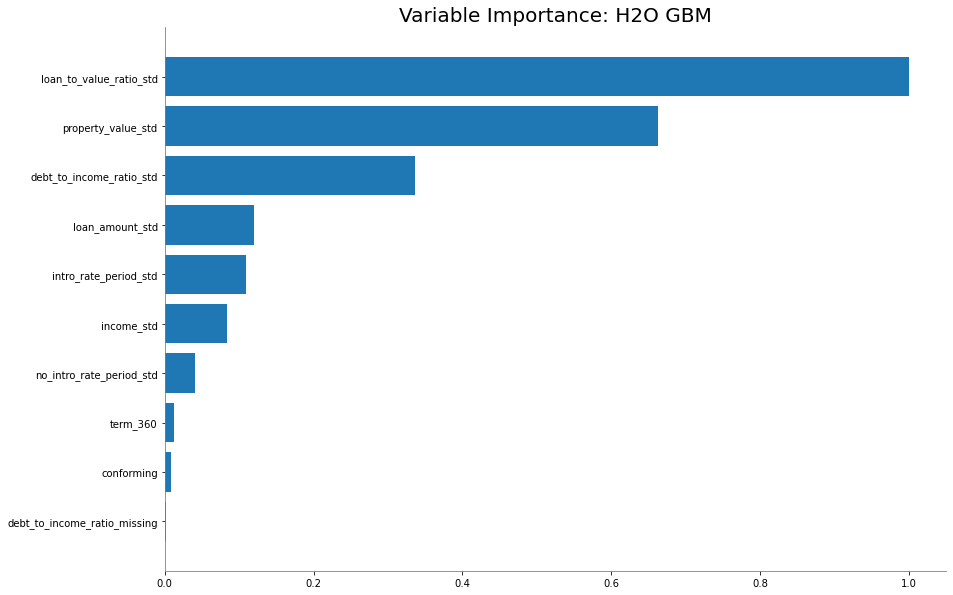

In [22]:
gbm_h2o.varimp_plot()

## Calculate and Plot Local Feature Importance.

### MGBM

In [23]:
from rmltk import explain

In [24]:
# merge MGBM predictions onto validation data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_gbm.predict(h2o.H2OFrame(valid))['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_high_priced', mgbm_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
mgbm_percentile_dict

{0: 18583,
 99: 139587,
 10: 44472,
 20: 99509,
 30: 101853,
 40: 12439,
 50: 144149,
 60: 46930,
 70: 137605,
 80: 117884,
 90: 130927}

In [25]:
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True) # Pandas index will now start from 0
valid_idx_map[0:5] # Shapley array index on left, ID on right

0     2
1     4
2     6
3    11
4    13
Name: row_id, dtype: int64

In [26]:
local_coef_dict = {10: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names),
                   50: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names),
                   90: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names)}
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(mgbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['mgbm Contribution'], index=x_names)
        local_coef_dict[percentile]['mgbm Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### Ensenble

In [27]:
# merge ensenble predictions onto validation data
ensenble_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             ensenble_h2o.predict(h2o.H2OFrame(valid))['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
ensenble_yhat_valid = ensenble_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
ensenble_percentile_dict = explain.get_percentile_dict('p_high_priced', ensenble_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
ensenble_percentile_dict

{0: 12046,
 99: 149667,
 10: 117908,
 20: 53723,
 30: 72047,
 40: 76286,
 50: 154274,
 60: 128914,
 70: 158891,
 80: 106822,
 90: 31574}

In [28]:
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(ensenble_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['Ensenble Contribution'], index=x_names)
        local_coef_dict[percentile]['Ensenble Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### GBM

In [29]:
# merge gbm predictions onto validation data
gbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             gbm_h2o.predict(h2o.H2OFrame(valid))['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
gbm_yhat_valid = gbm_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
gbm_percentile_dict = explain.get_percentile_dict('p_high_priced', gbm_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
gbm_percentile_dict

{0: 438,
 99: 22404,
 10: 30172,
 20: 140715,
 30: 83139,
 40: 50877,
 50: 92281,
 60: 157694,
 70: 57230,
 80: 2172,
 90: 23495}

In [30]:
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(gbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['gbm Contribution'], index=x_names)
        local_coef_dict[percentile]['gbm Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### Comparison

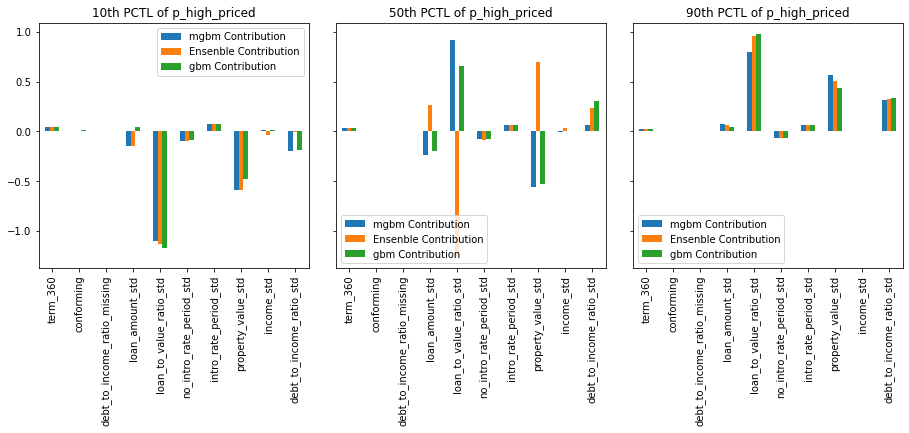

In [31]:
## init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_coef_dict[10].plot(kind='bar',
                           ax=ax0,
                           title='10th PCTL of p_high_priced')

_ = local_coef_dict[50].plot(kind='bar',
                           ax=ax1,
                           title='50th PCTL of p_high_priced')

_ = local_coef_dict[90].plot(kind='bar',
                           ax=ax2,
                           title='90th PCTL of p_high_priced')

### H2O Analysis: Ensenble

No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

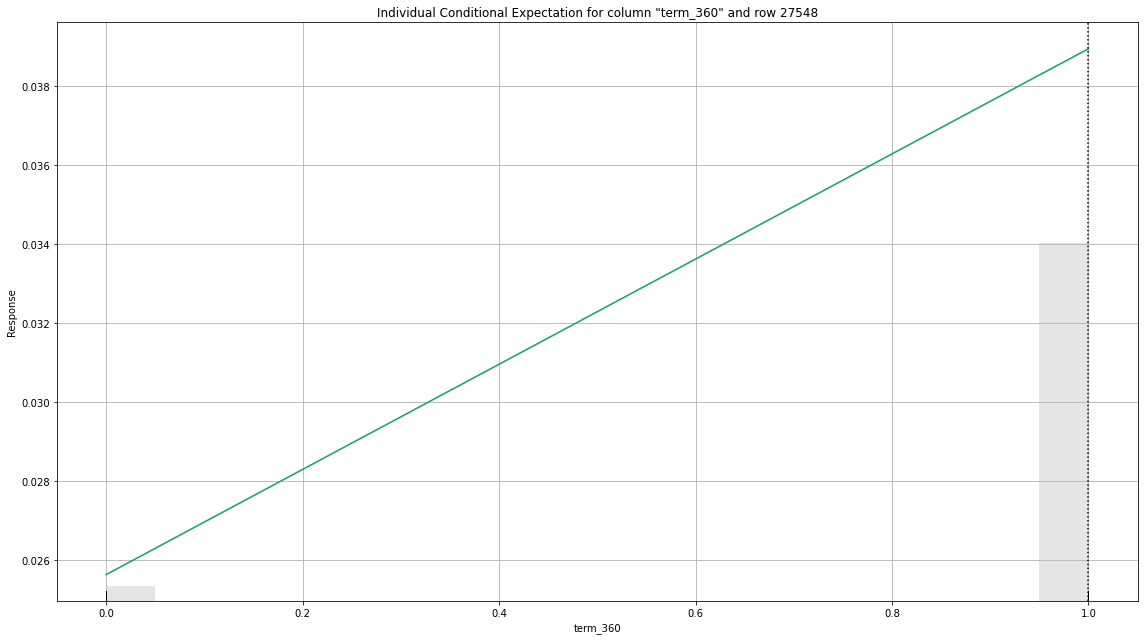

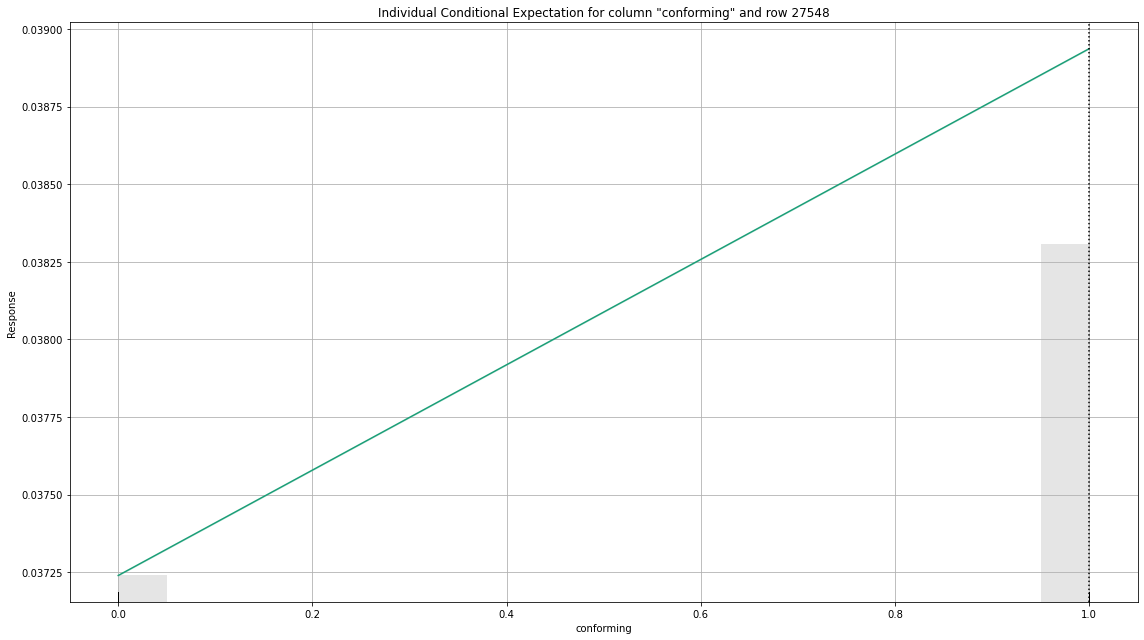

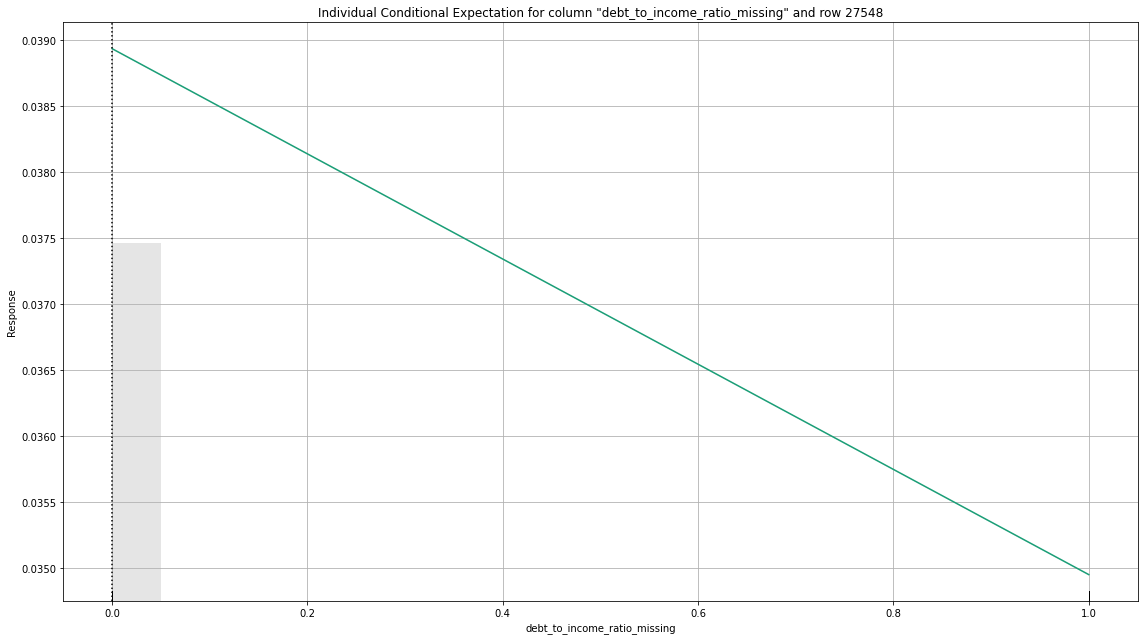

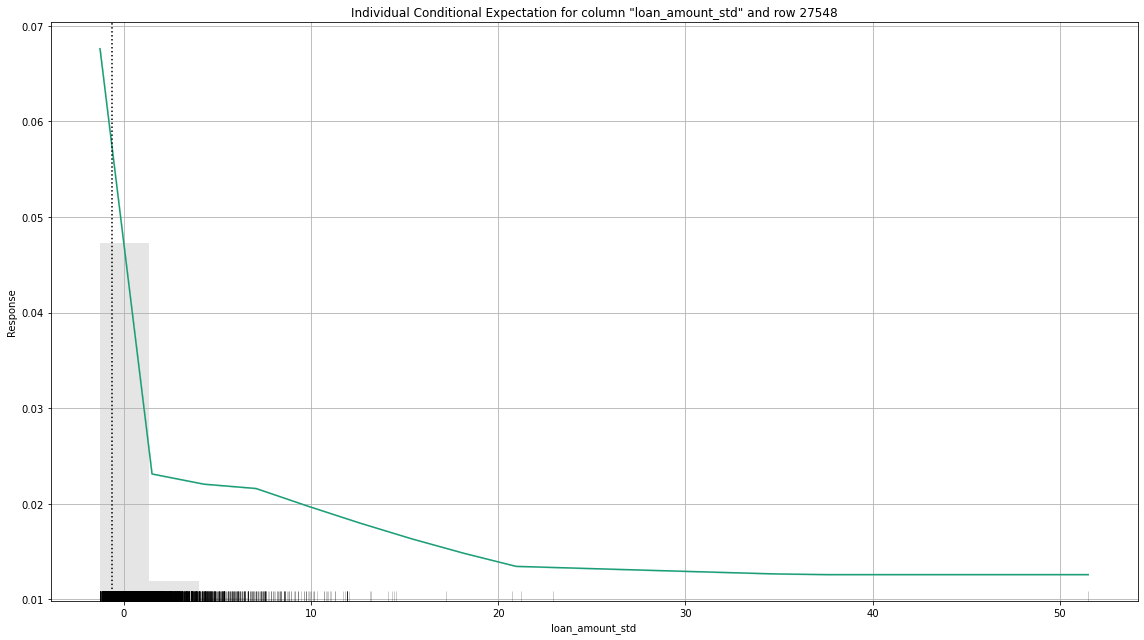

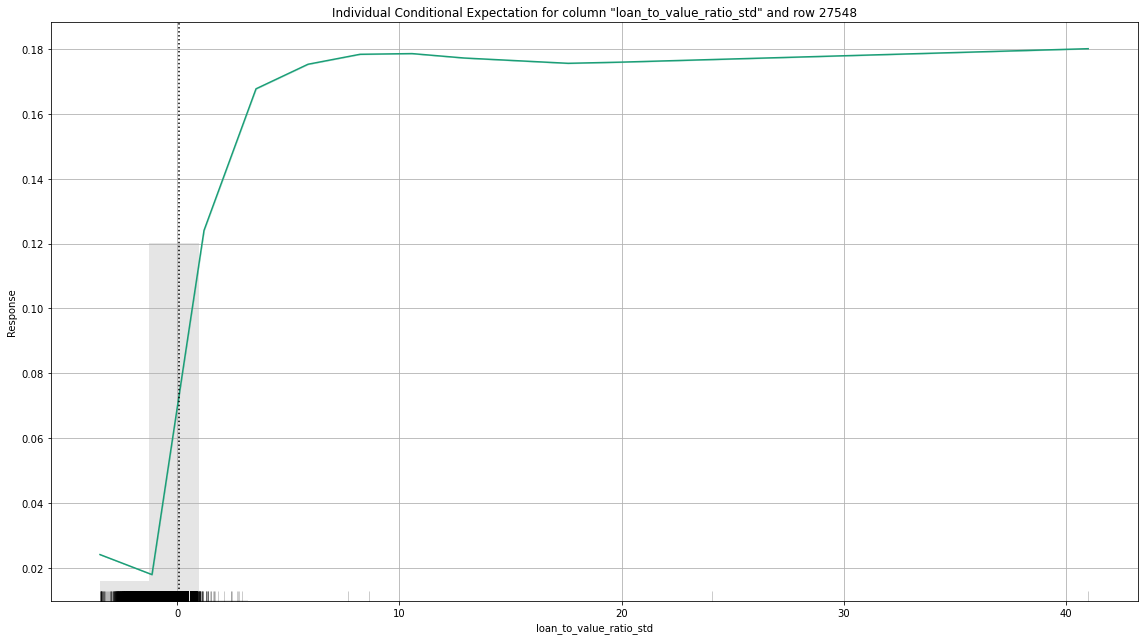

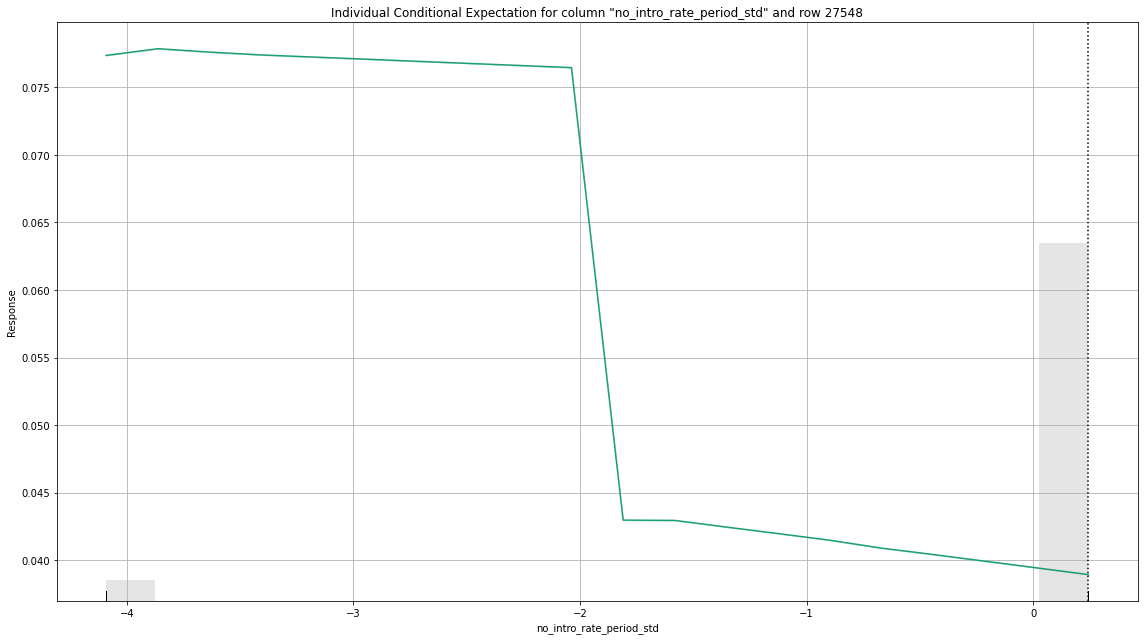

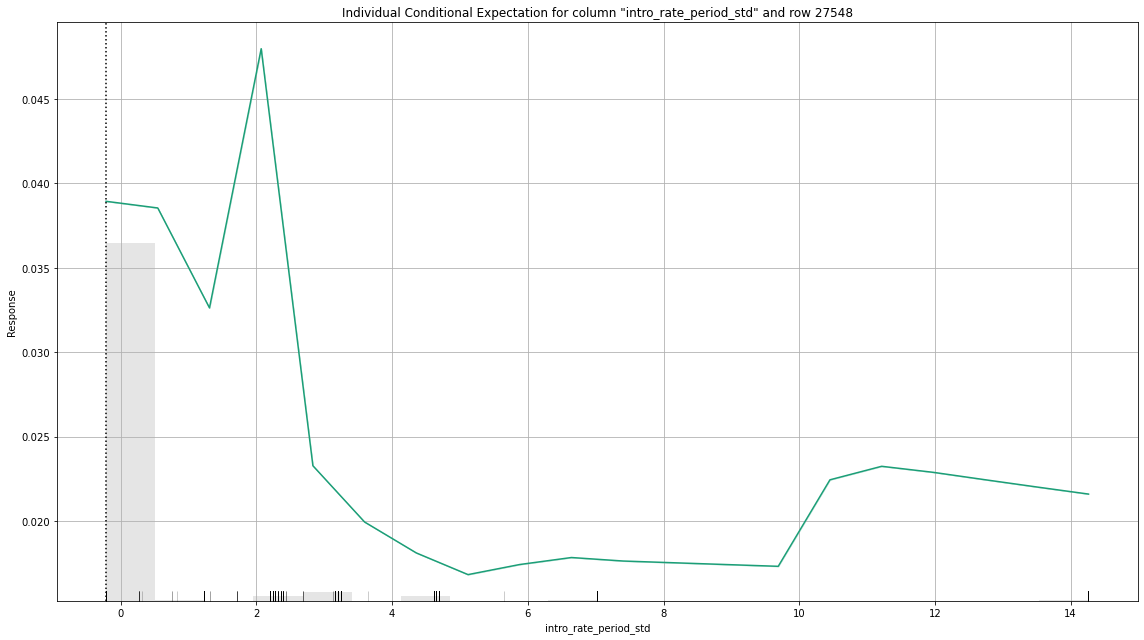

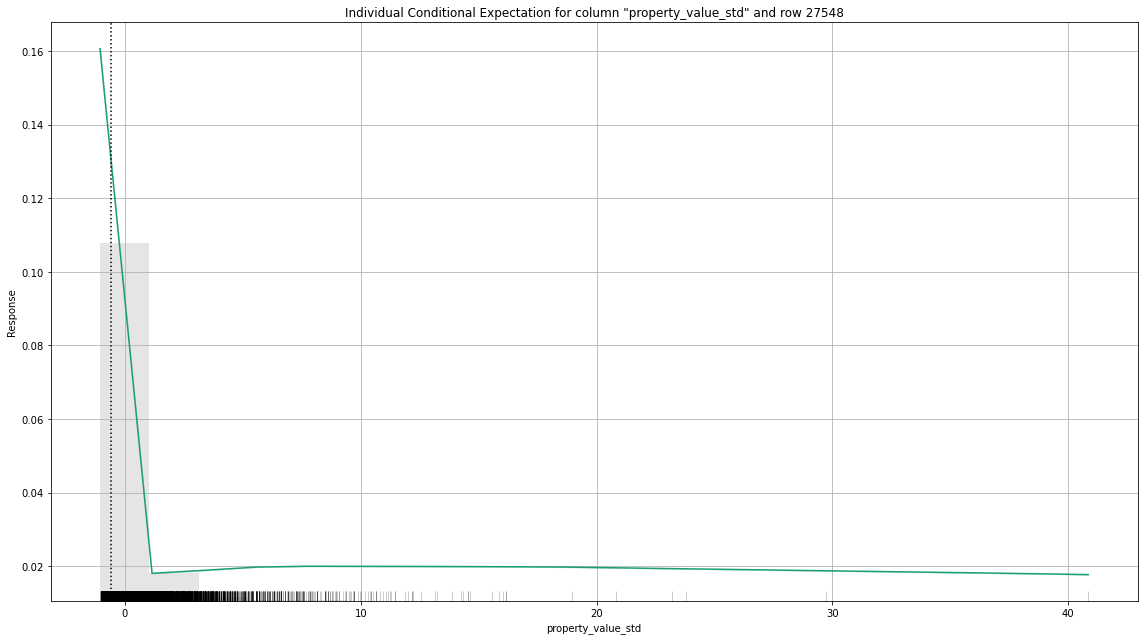

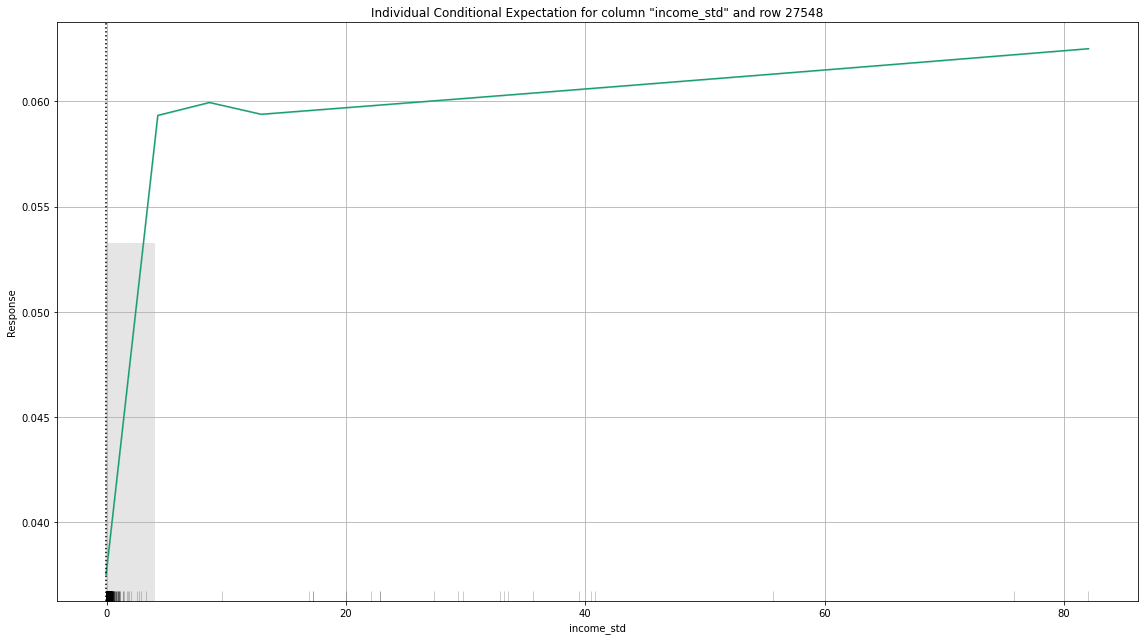

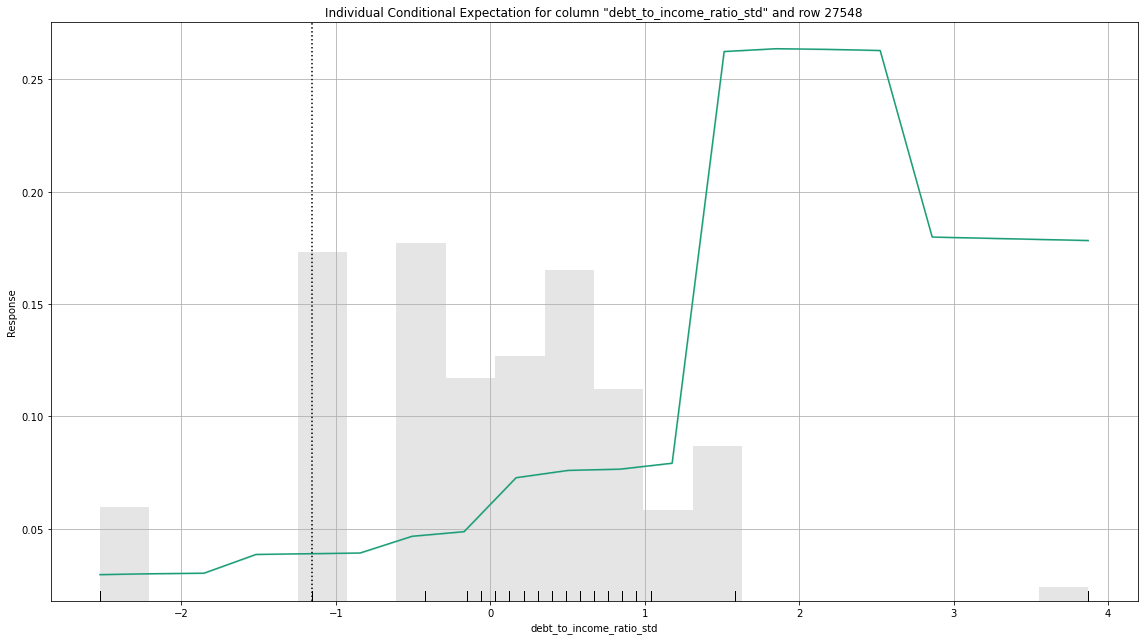

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

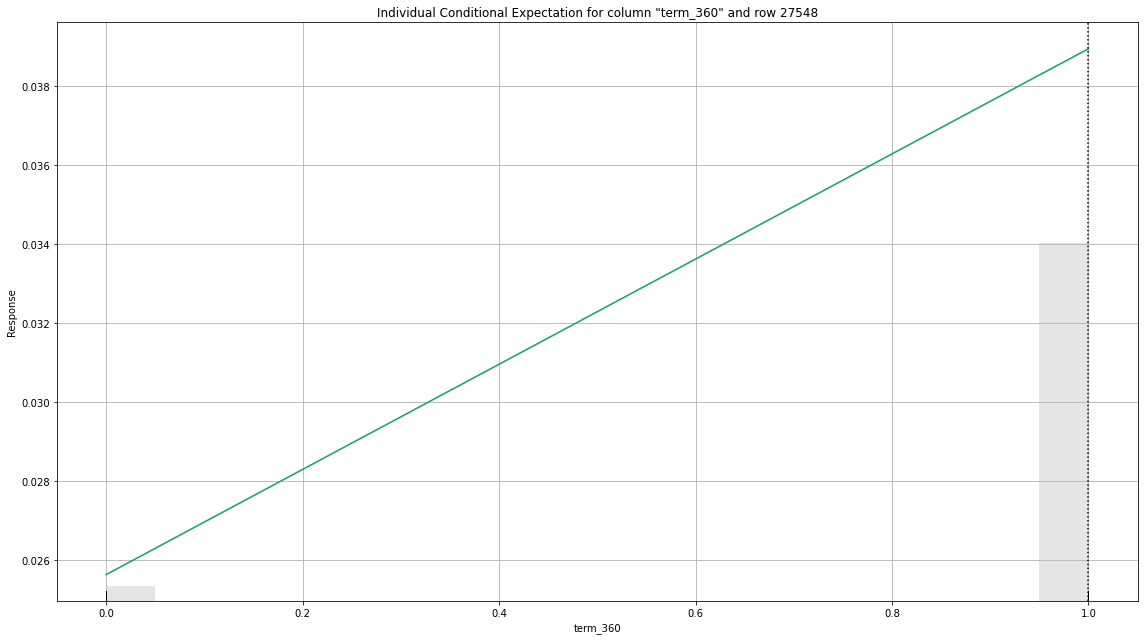

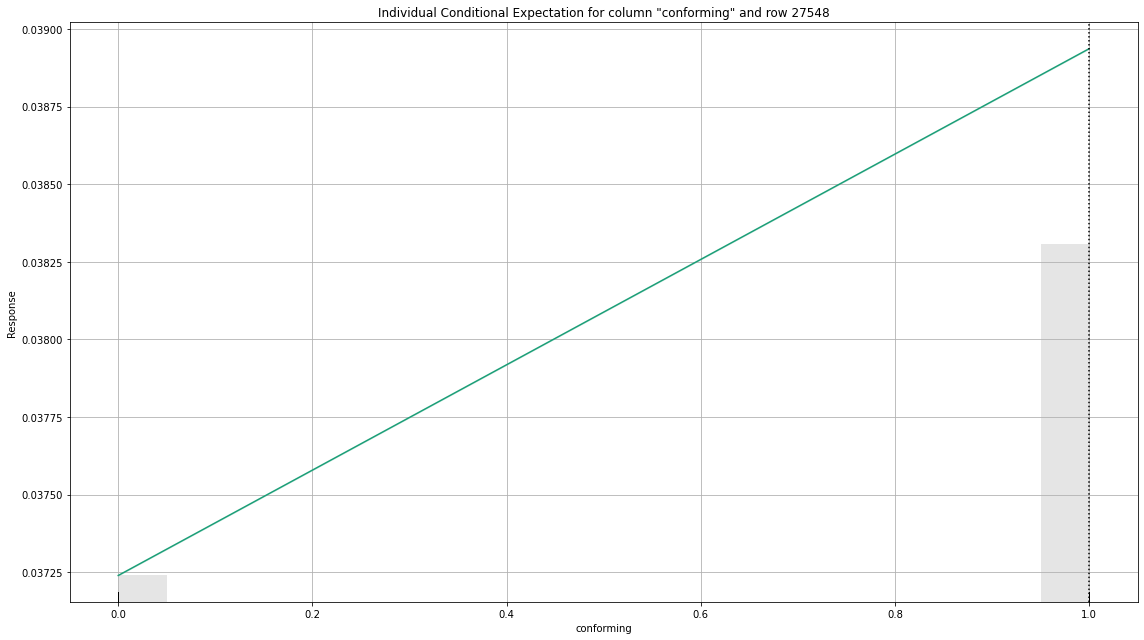

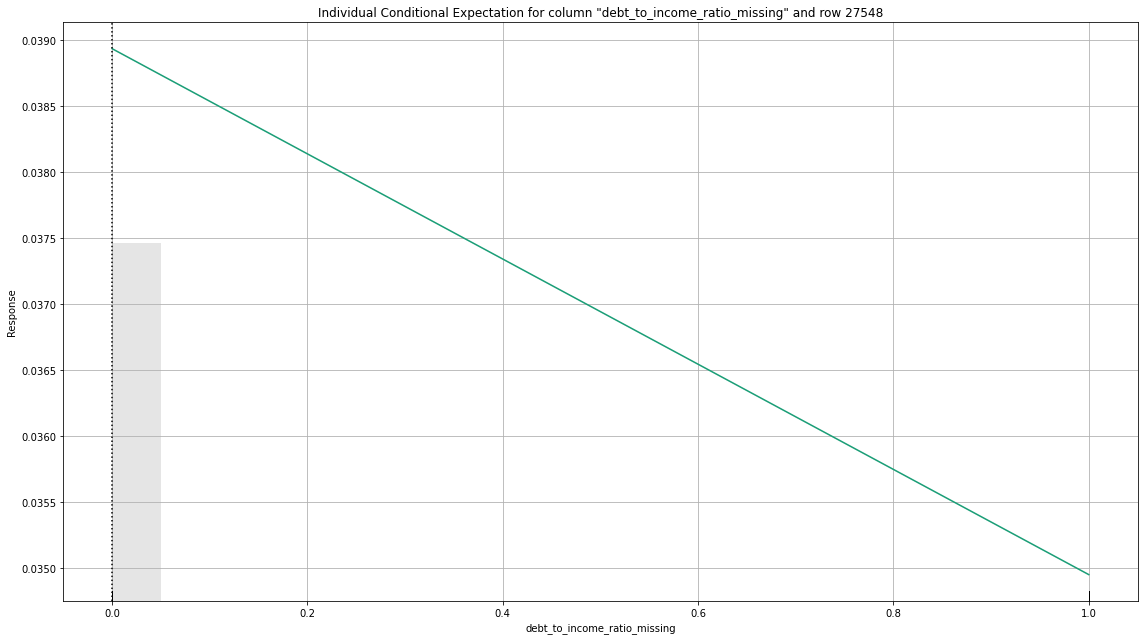

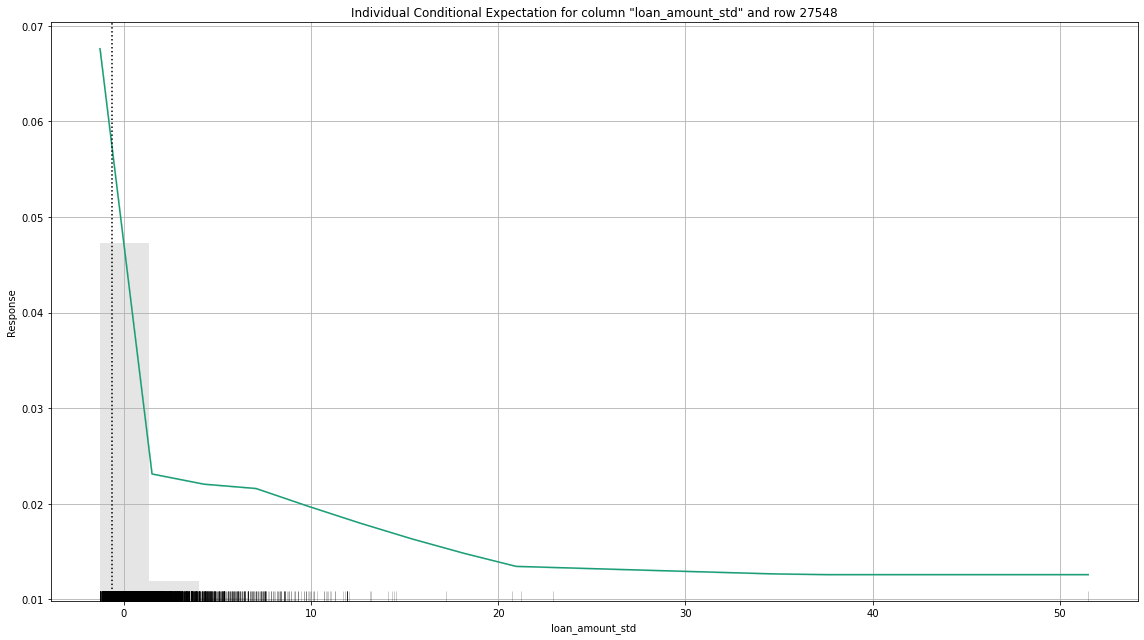

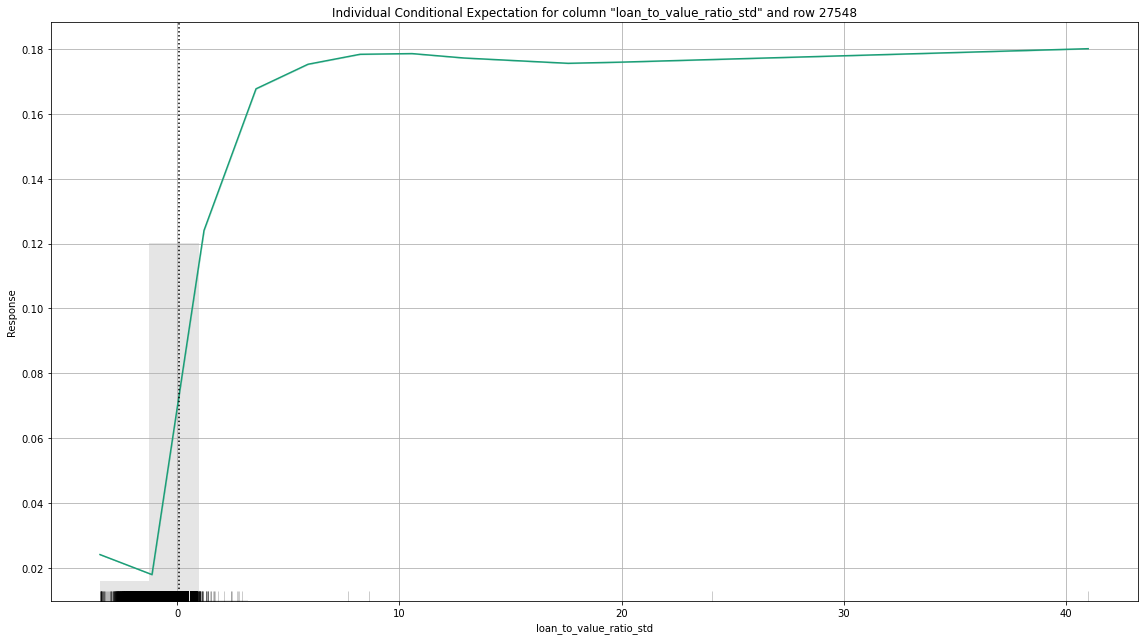

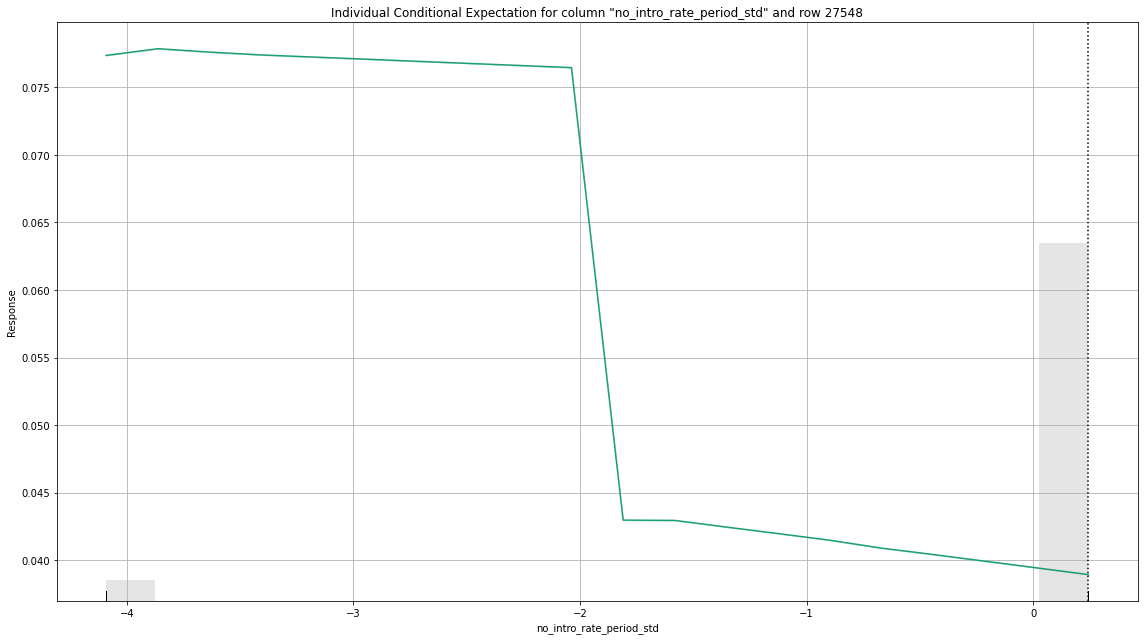

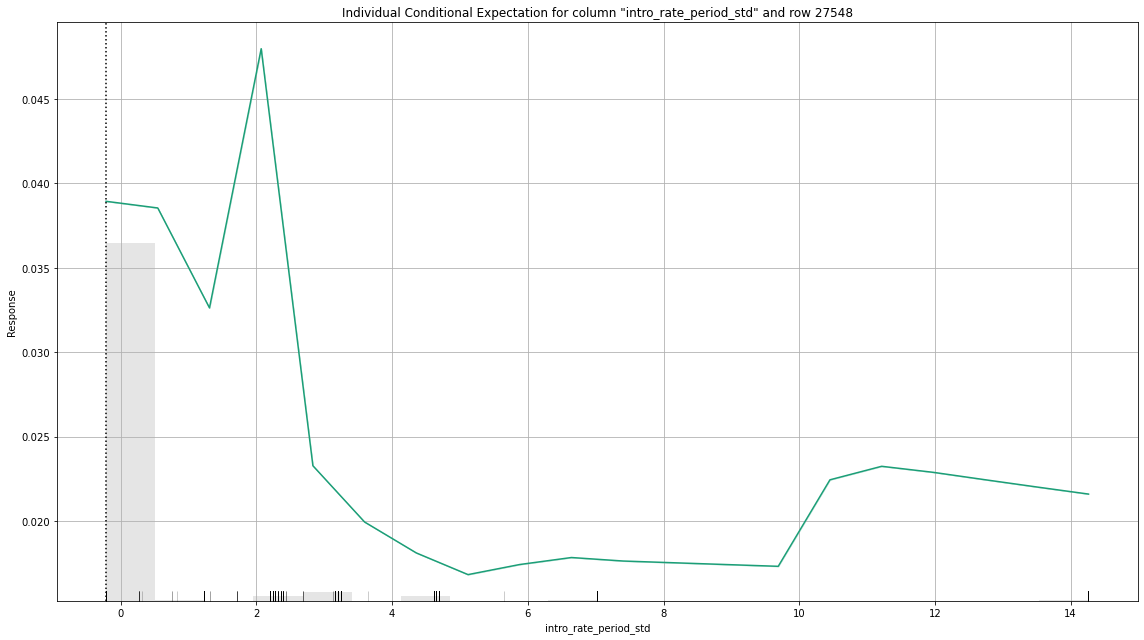

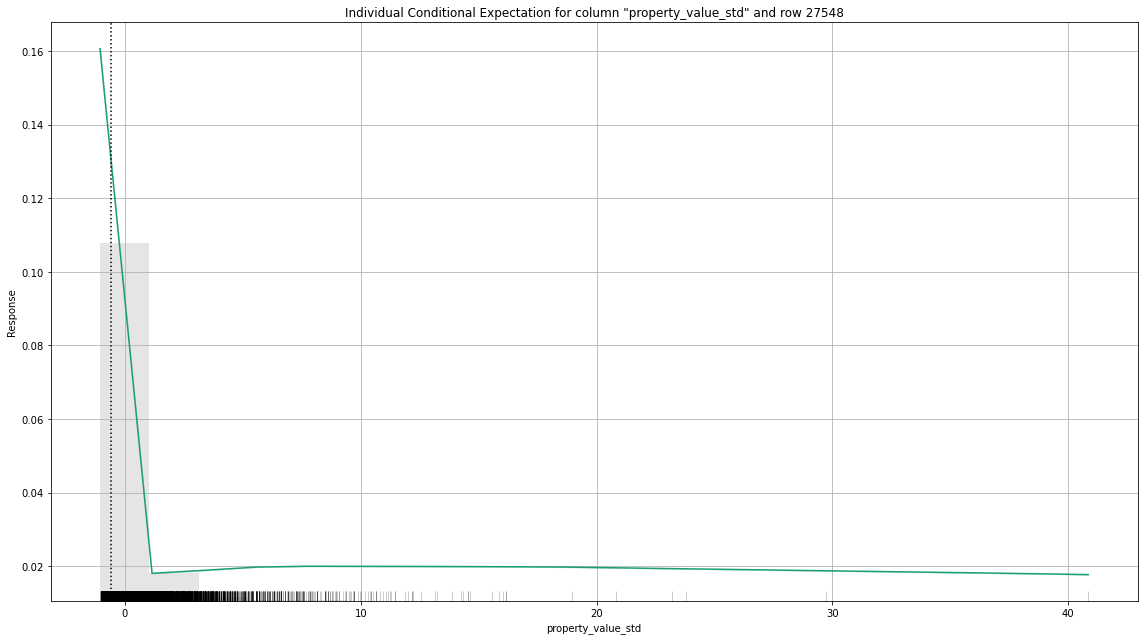

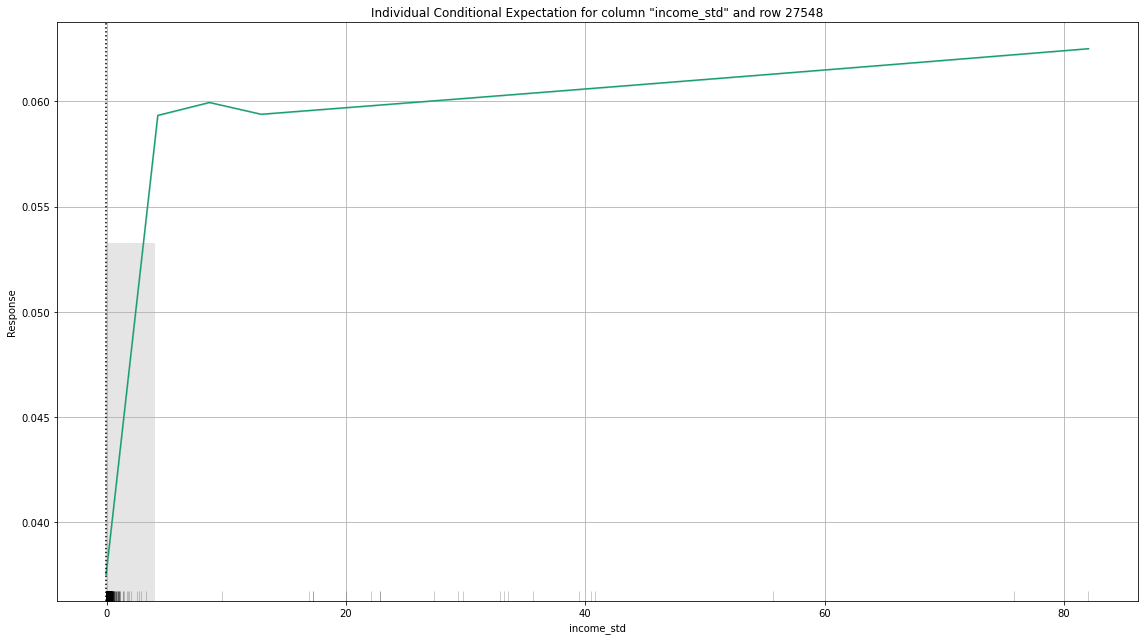

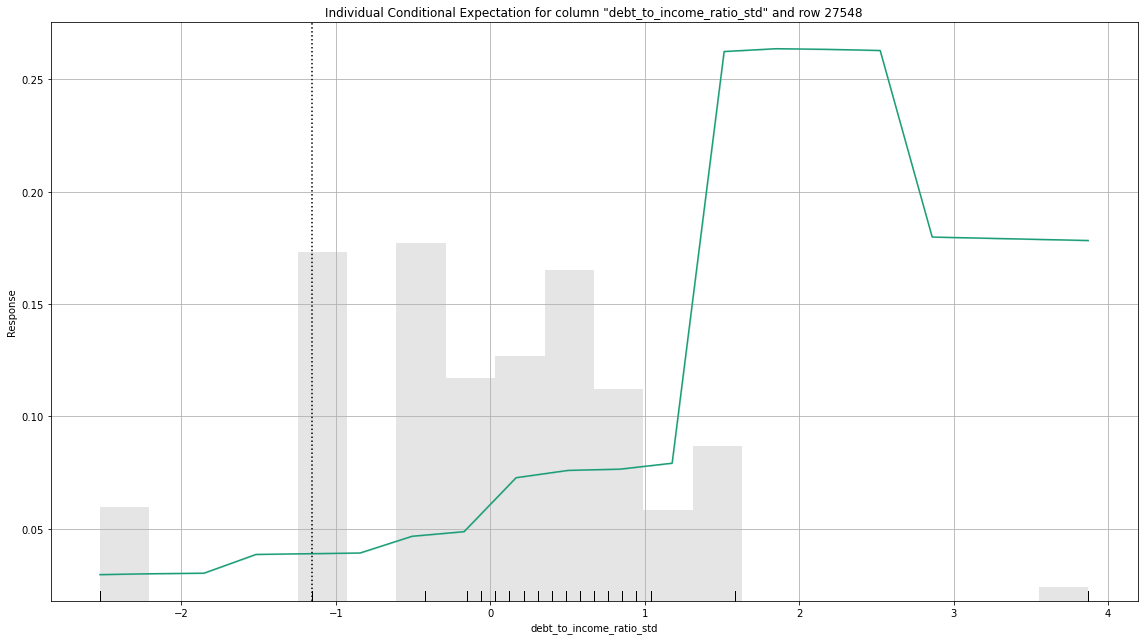

In [32]:
# Explain 10 percentile
ensenble_h2o.explain_row(hvalid, row_index=27548)


No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

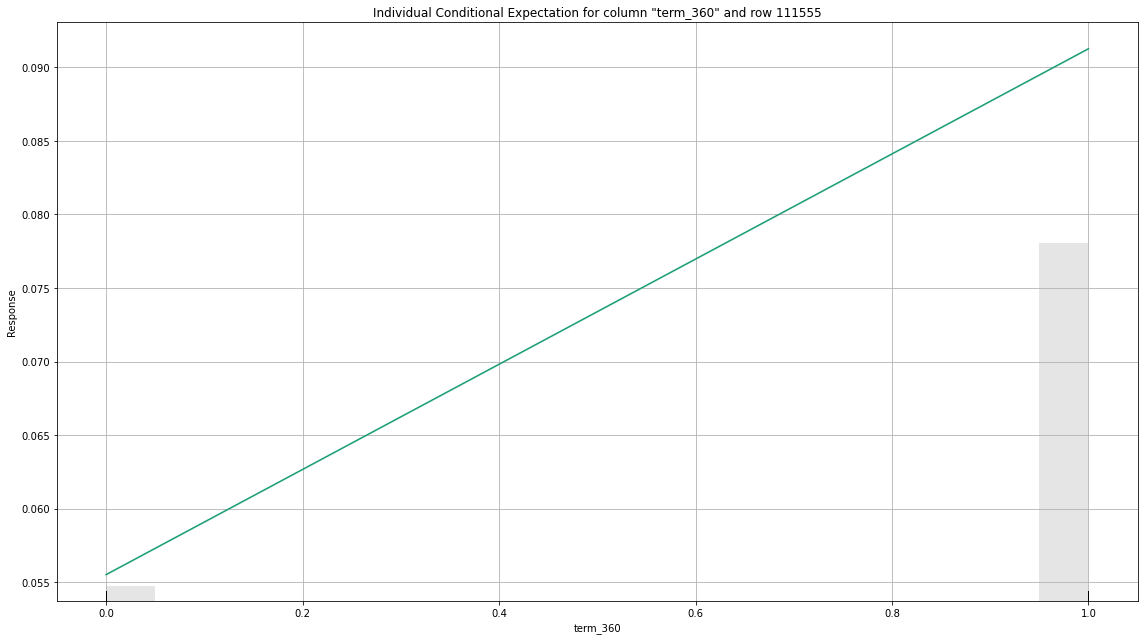

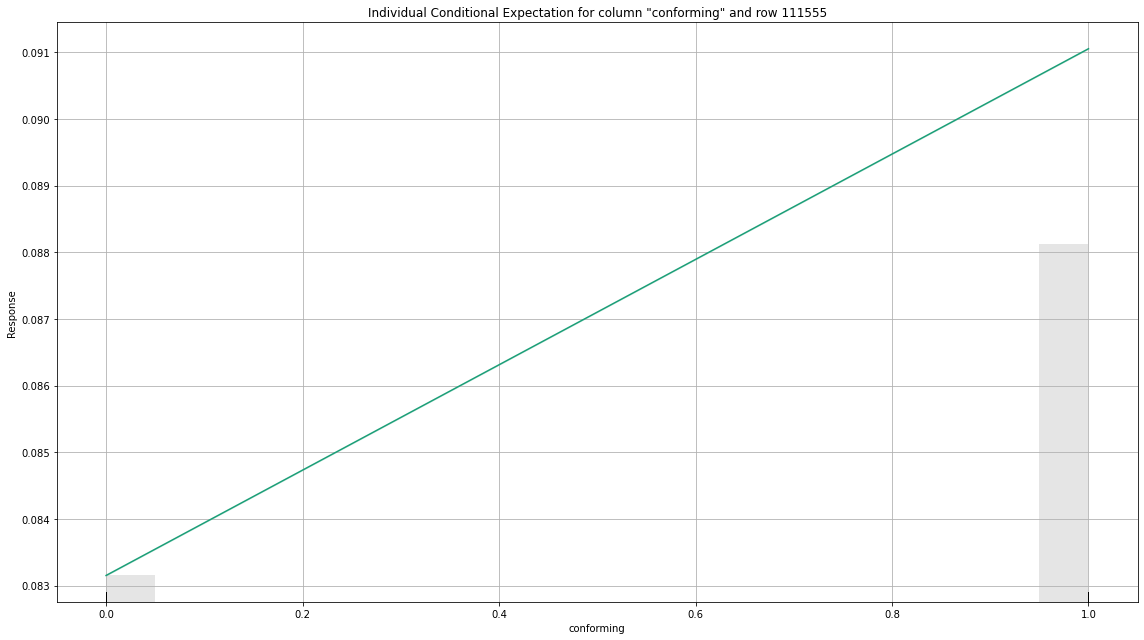

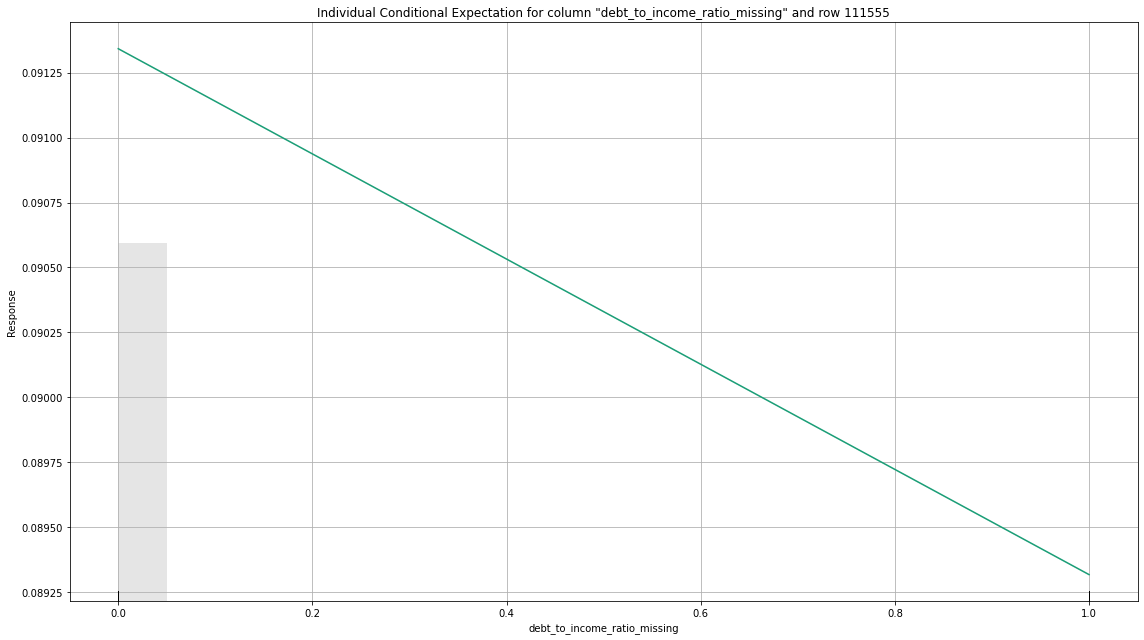

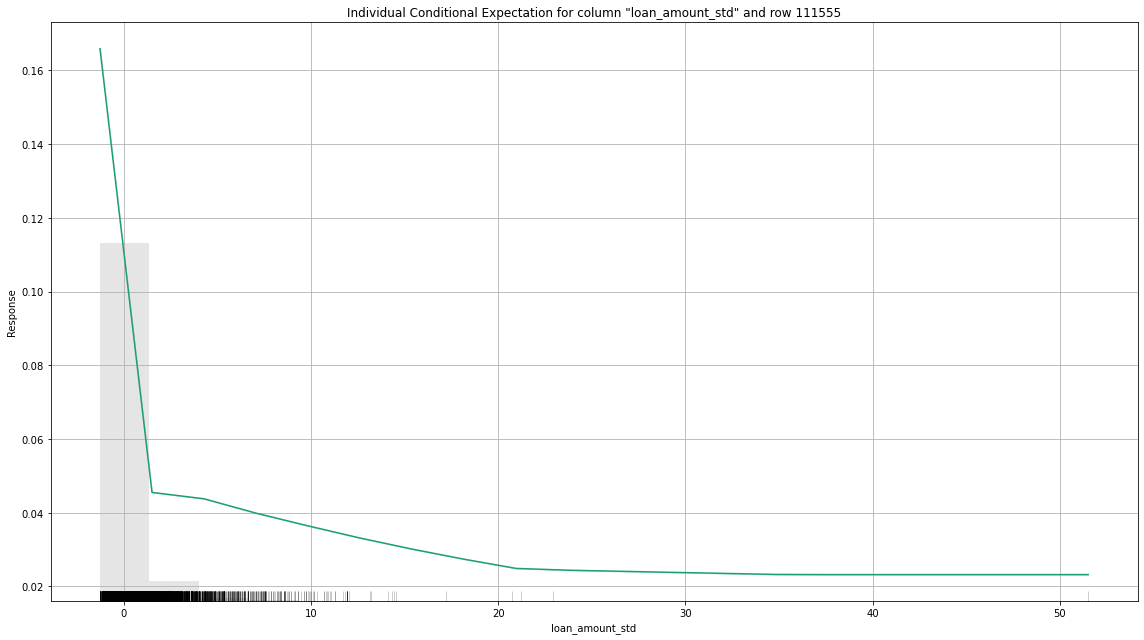

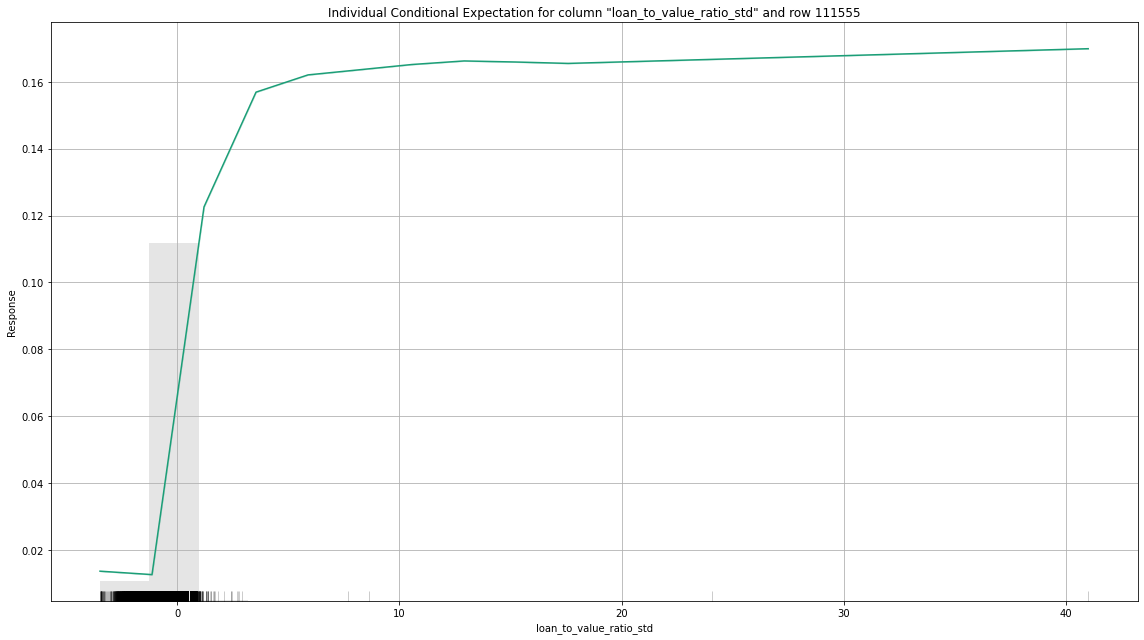

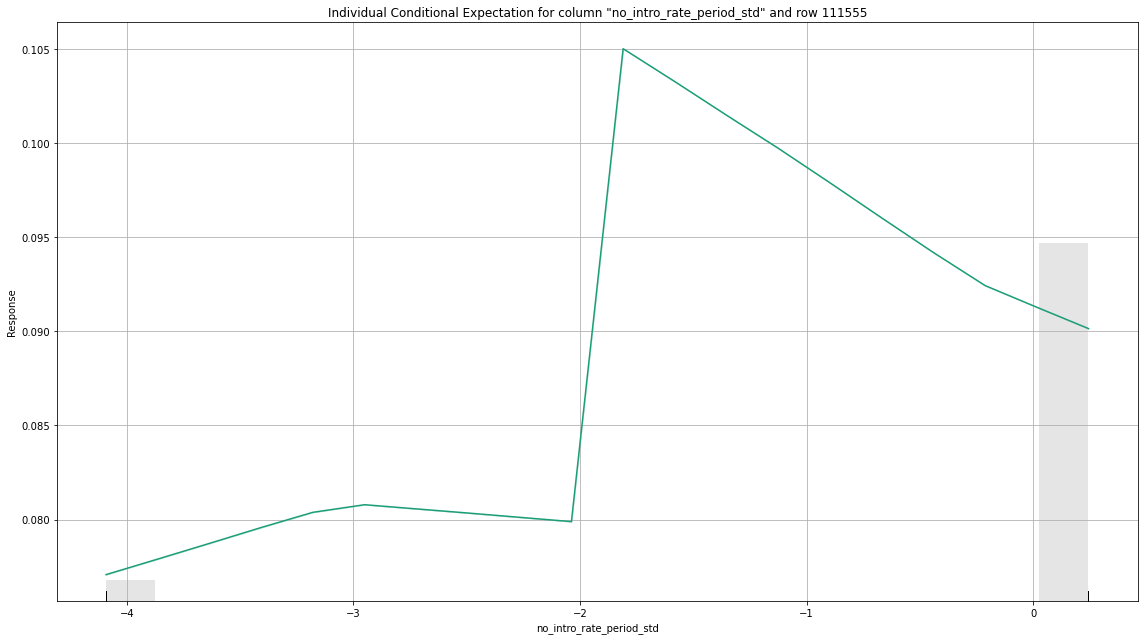

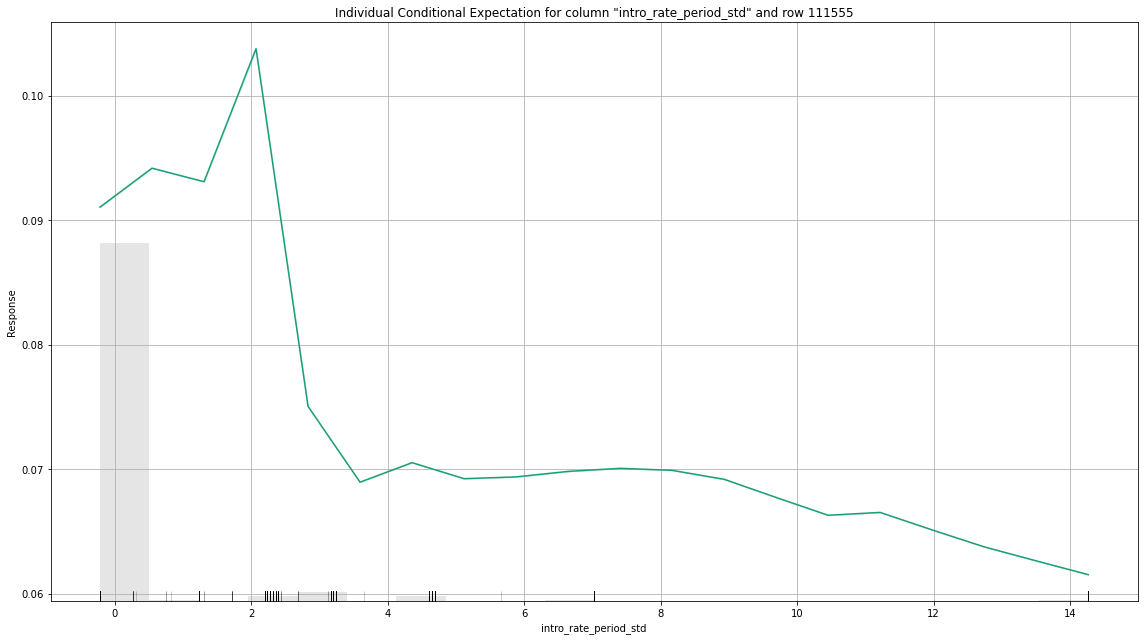

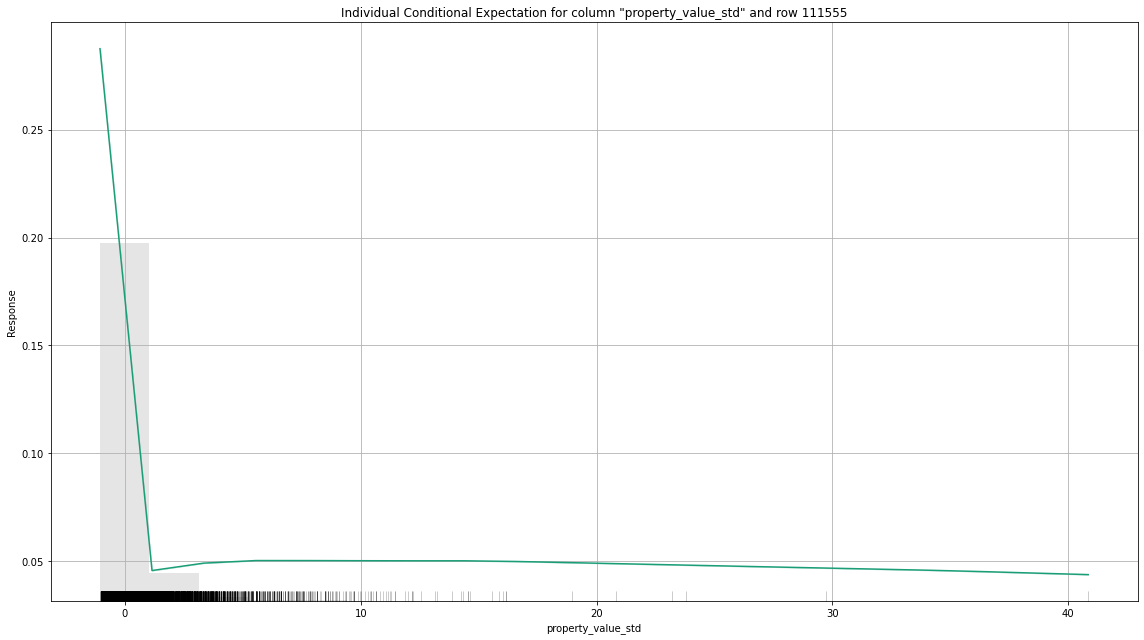

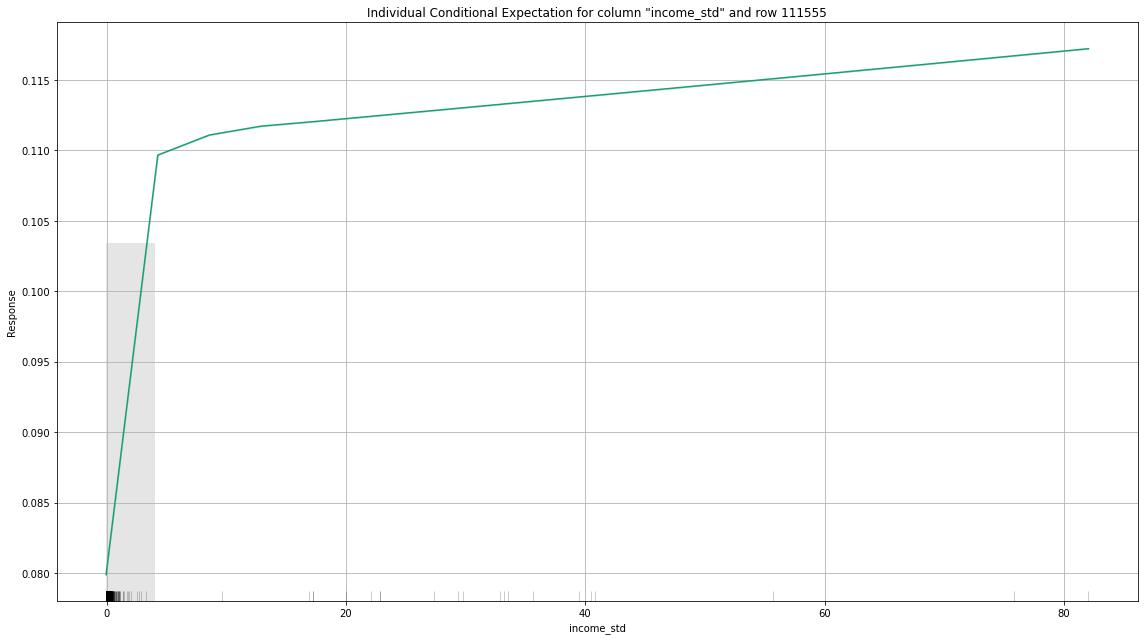

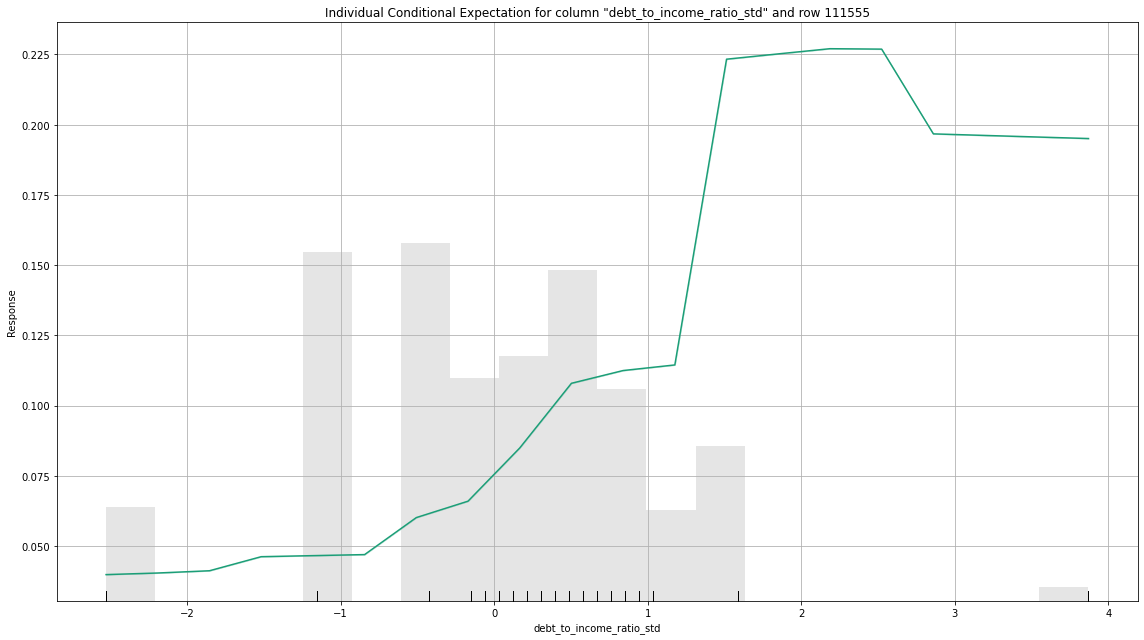

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

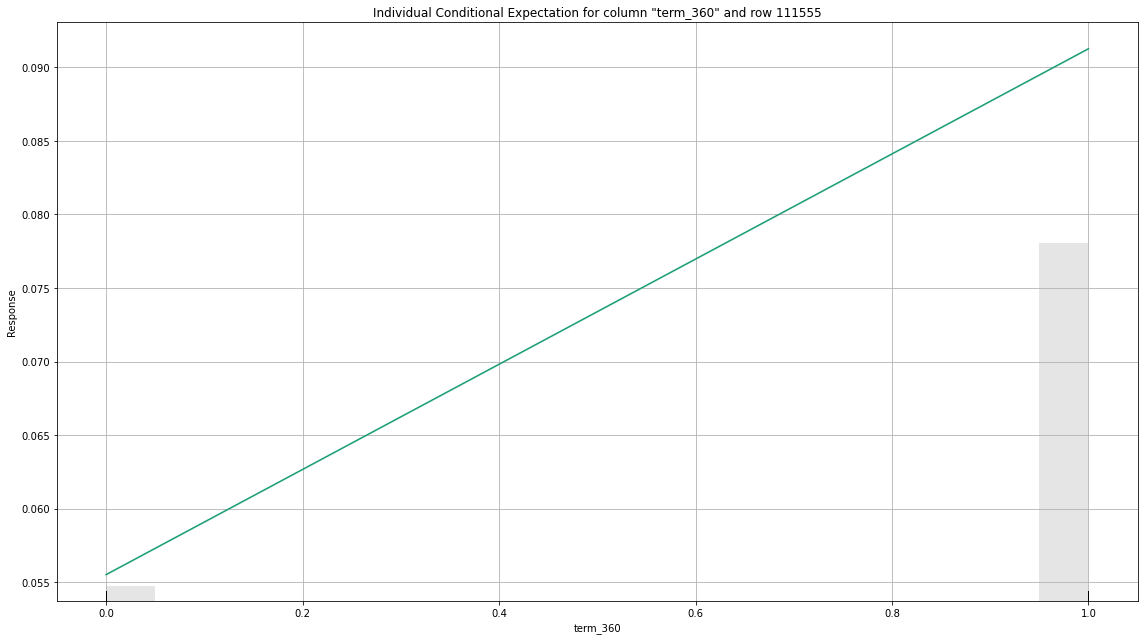

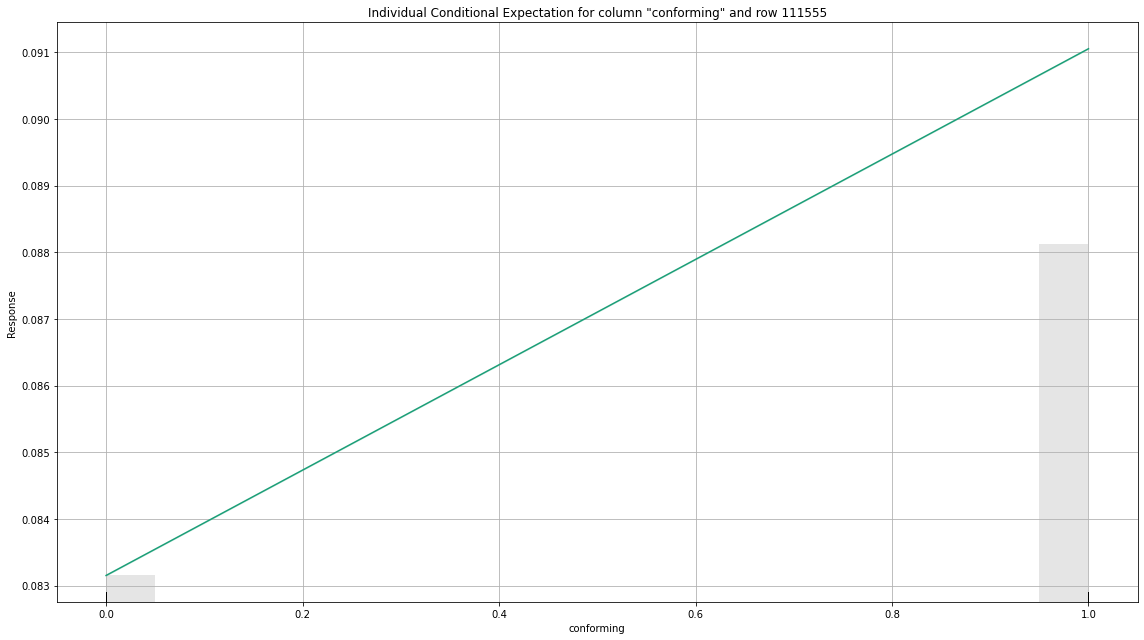

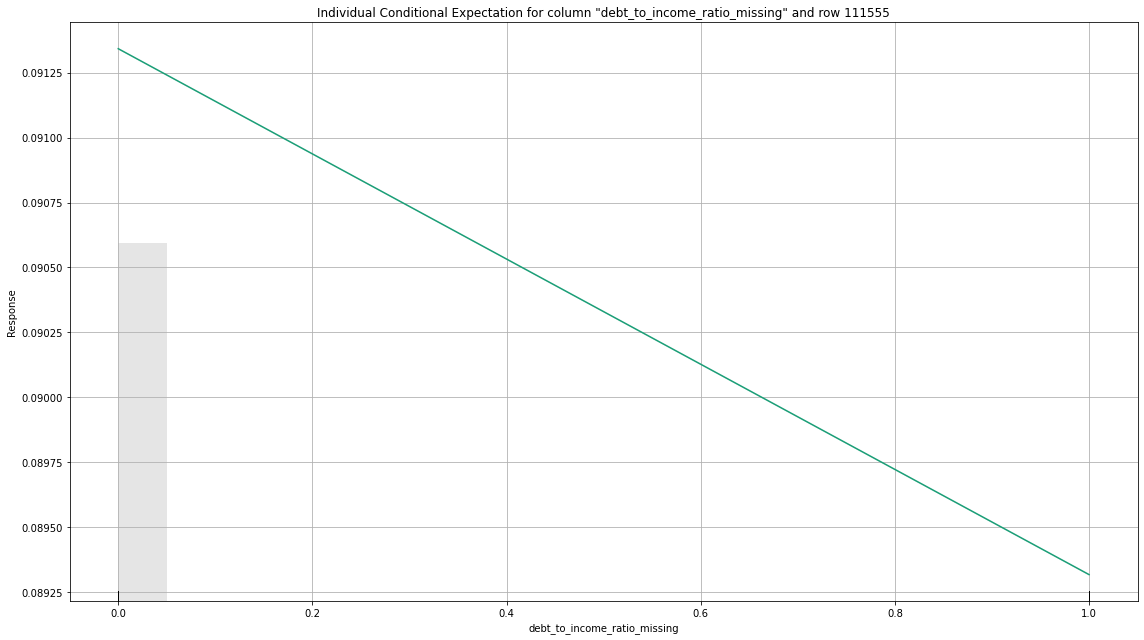

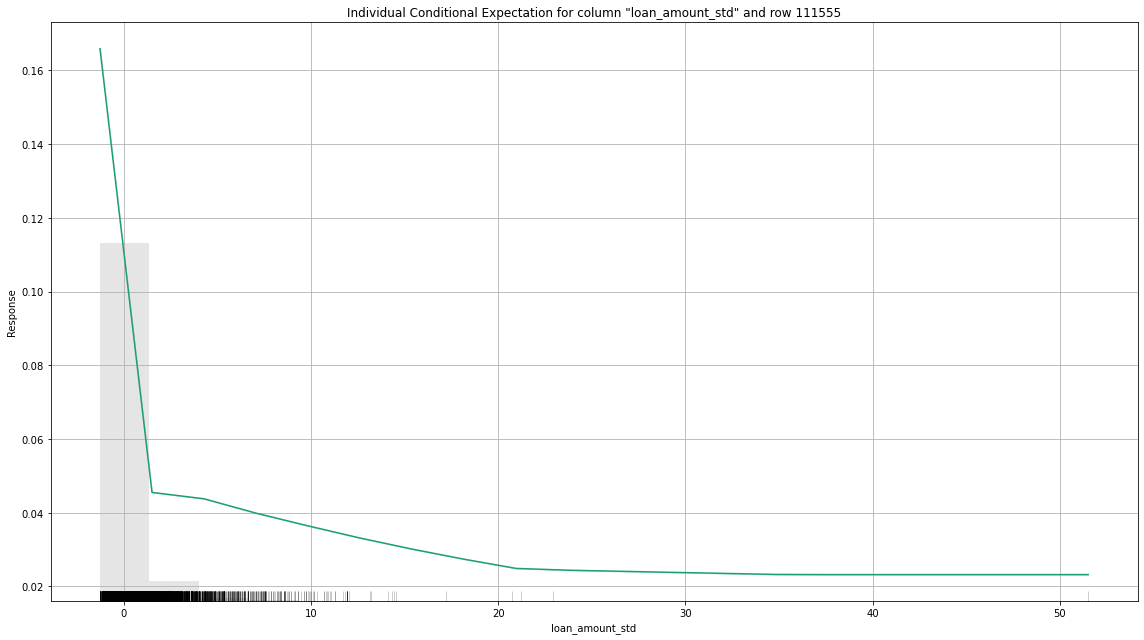

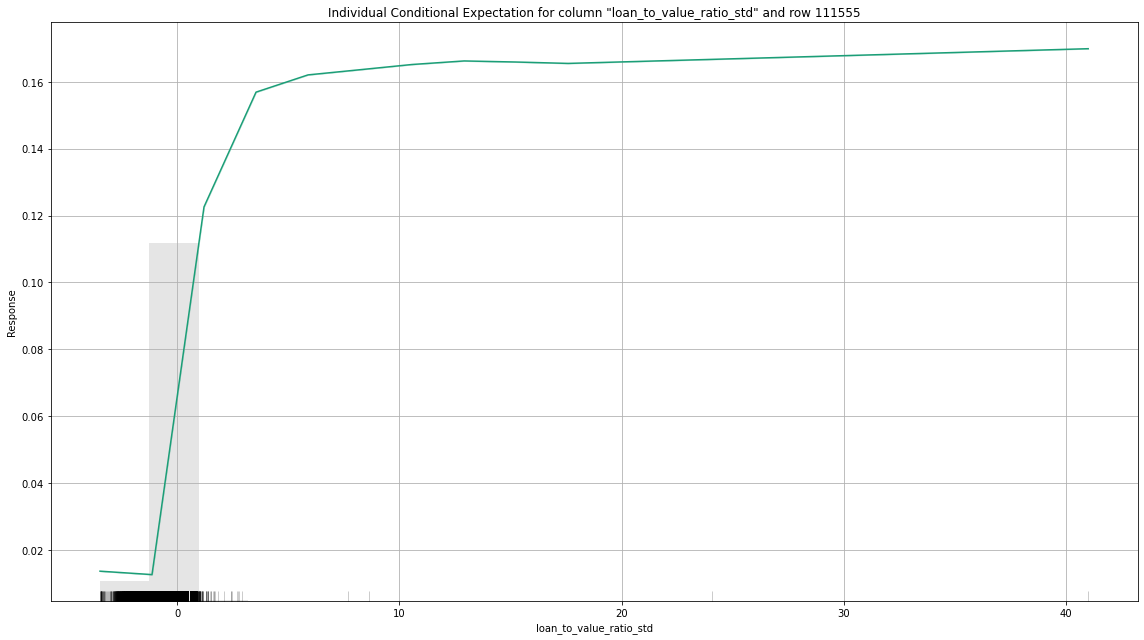

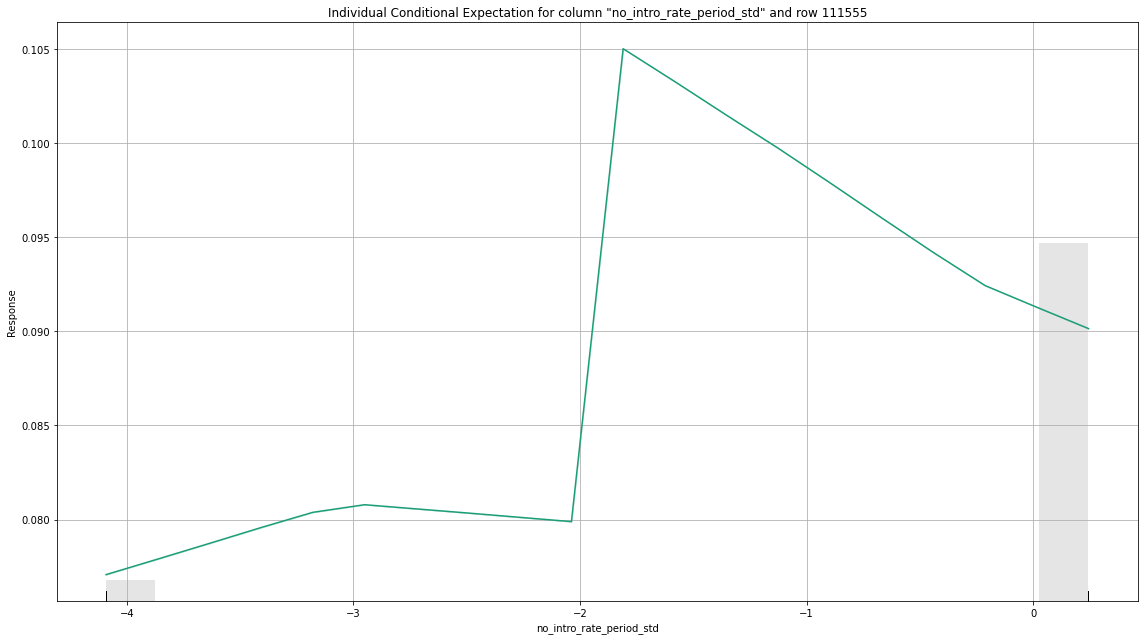

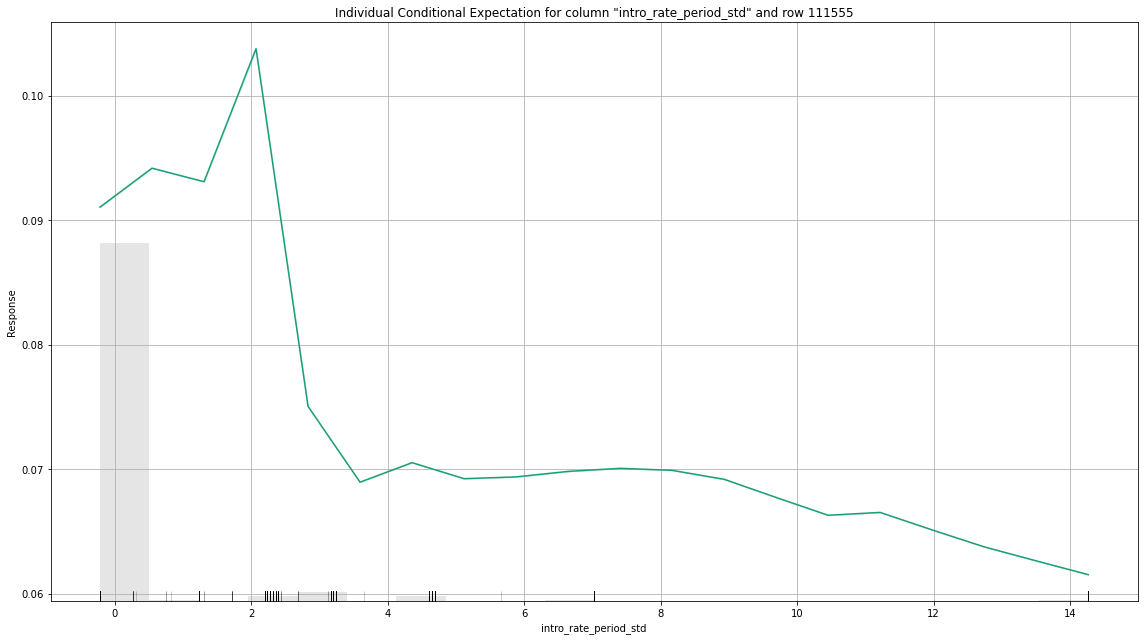

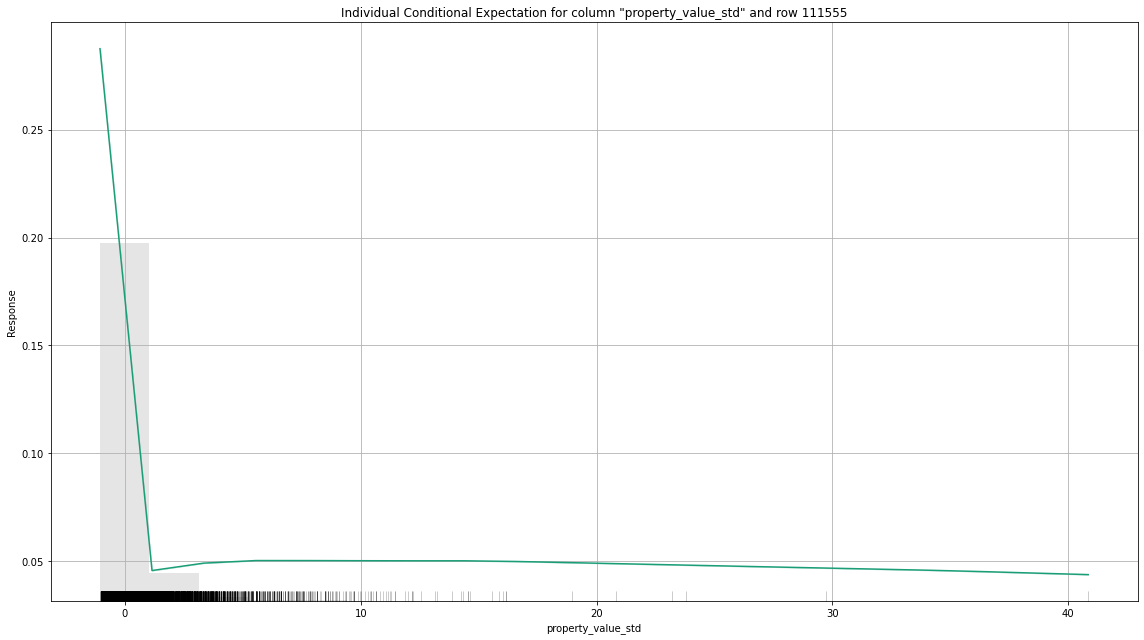

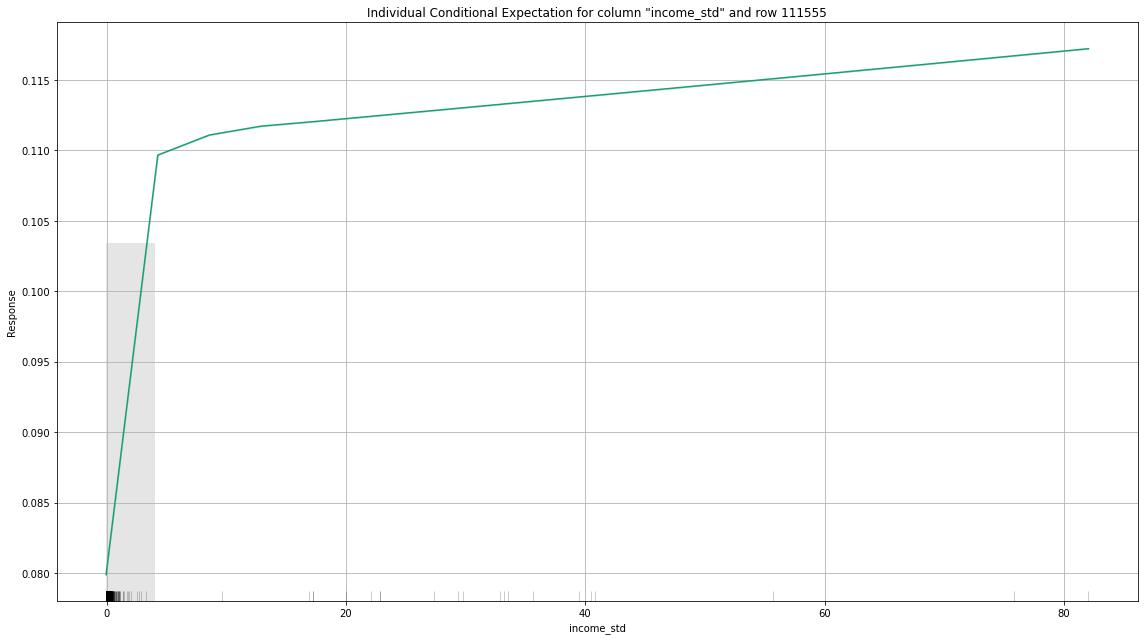

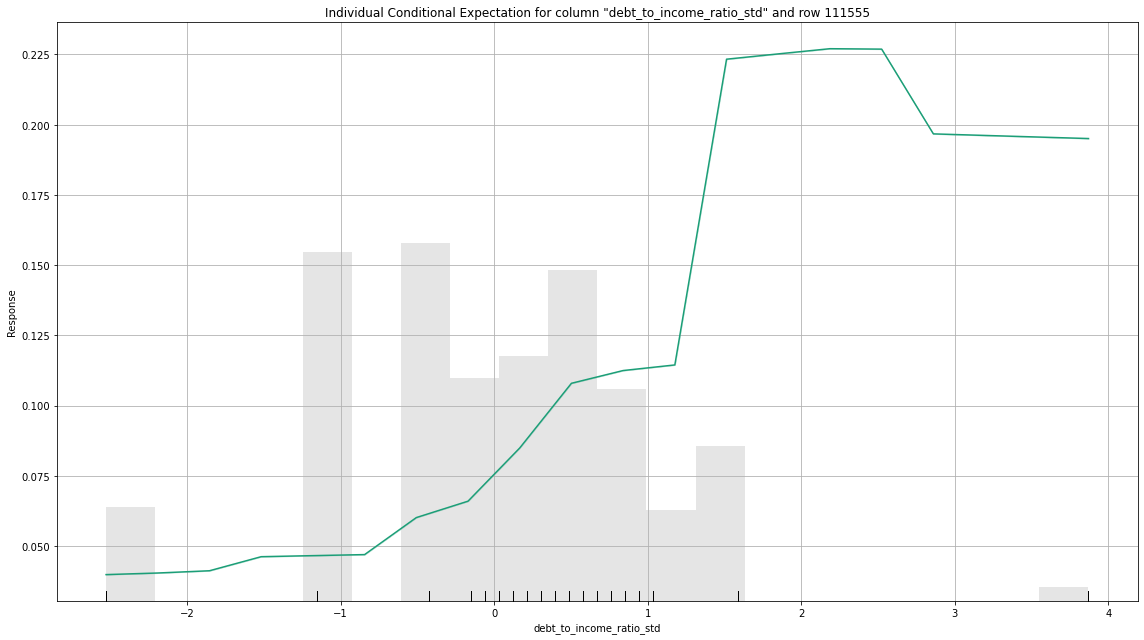

In [33]:
# Explain 50 percentile
ensenble_h2o.explain_row(hvalid, row_index=111555)

No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

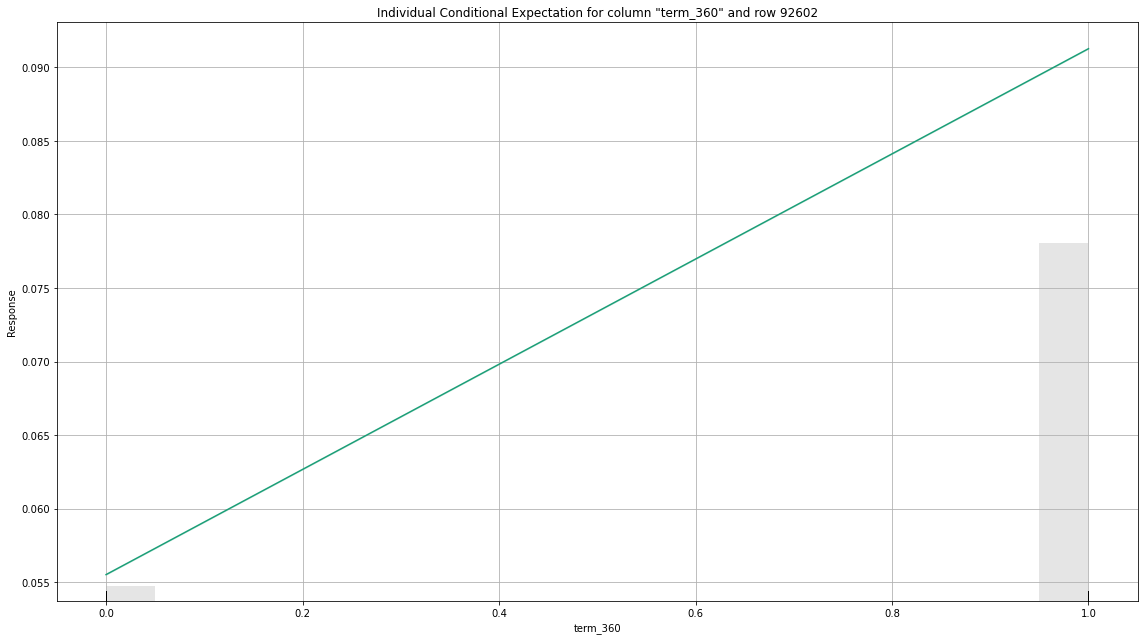

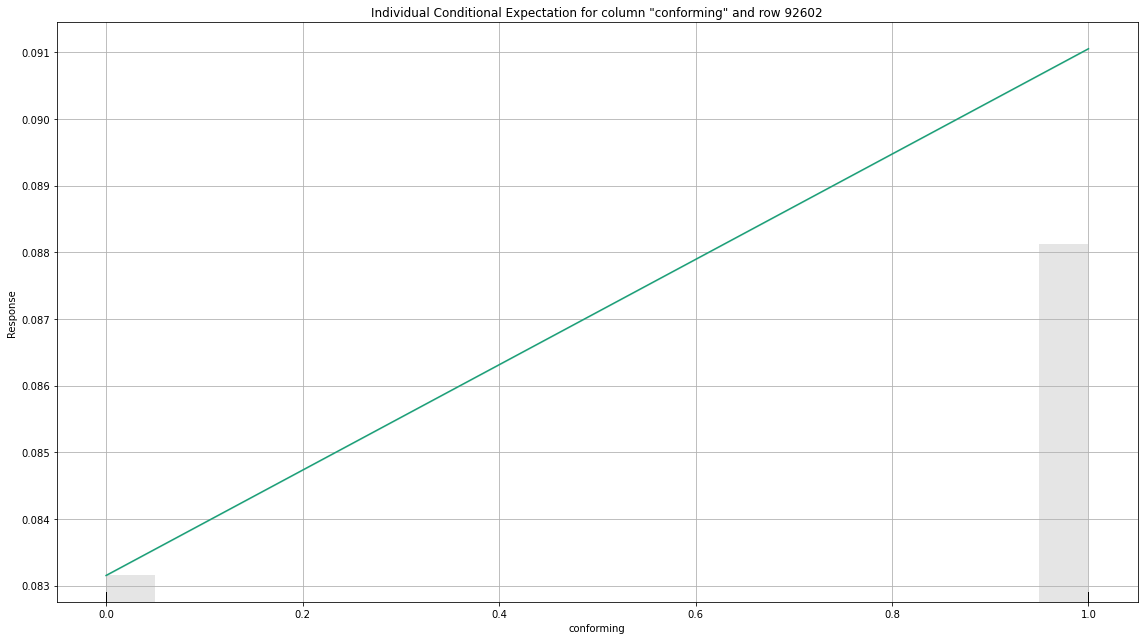

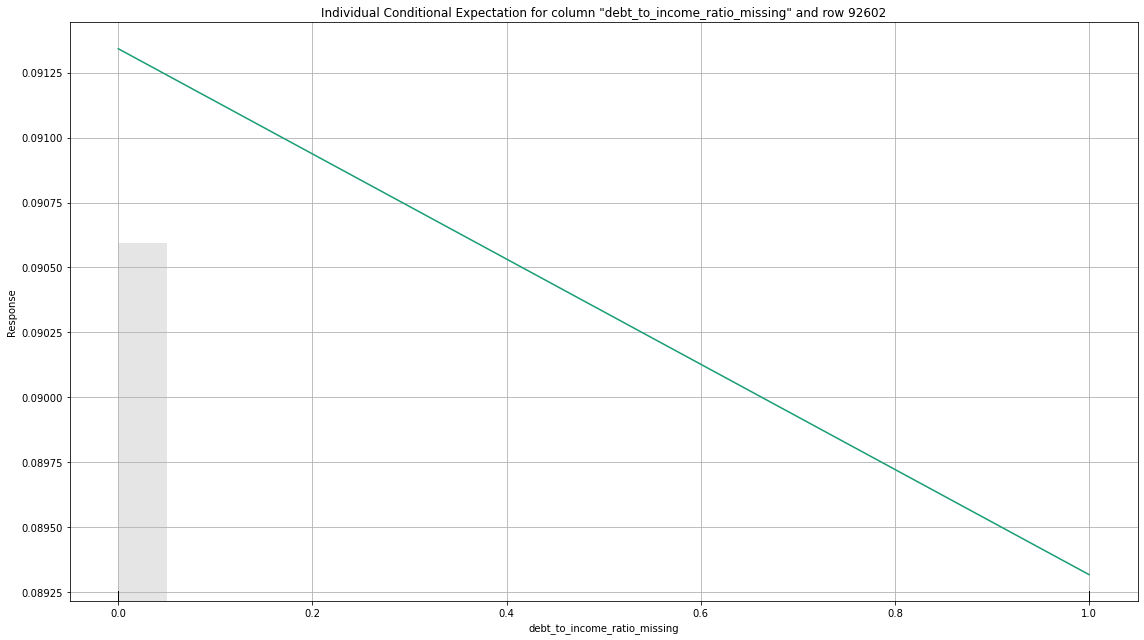

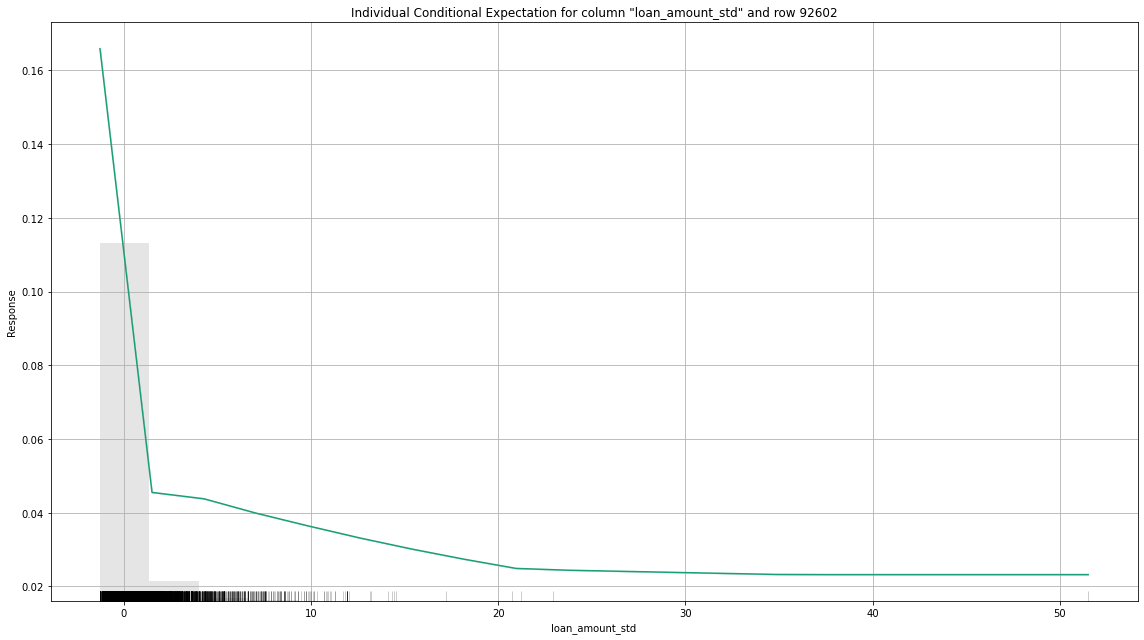

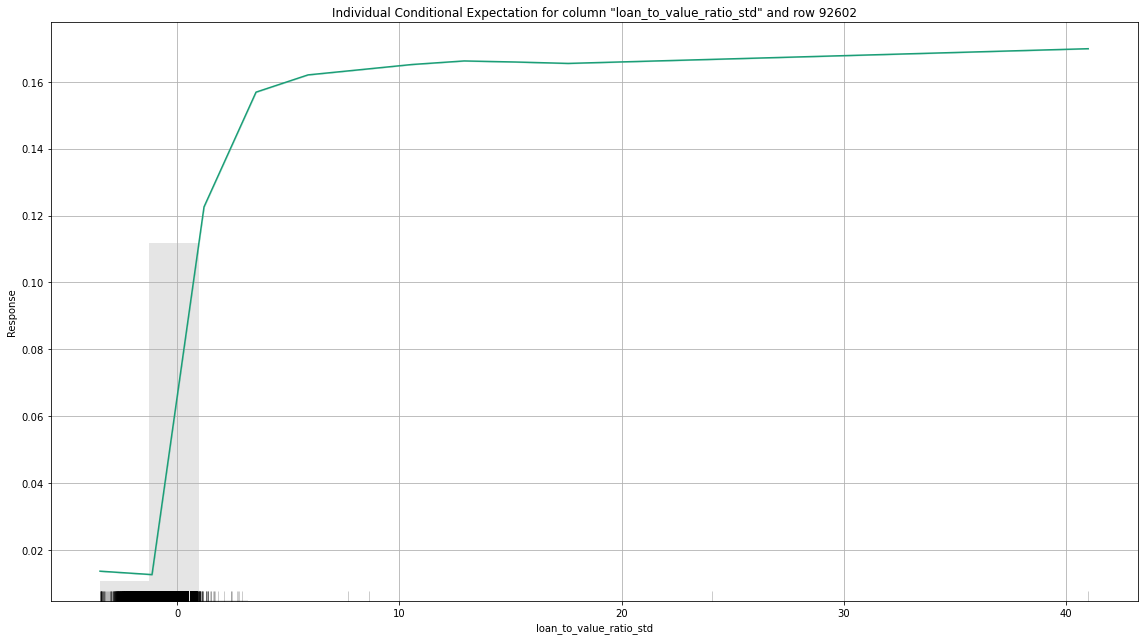

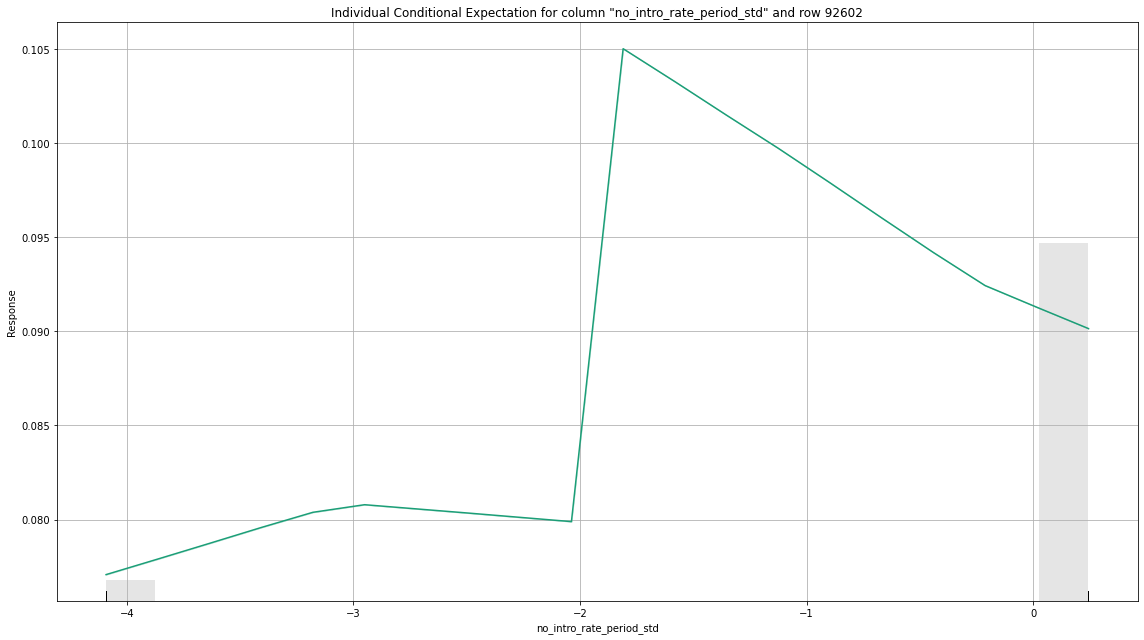

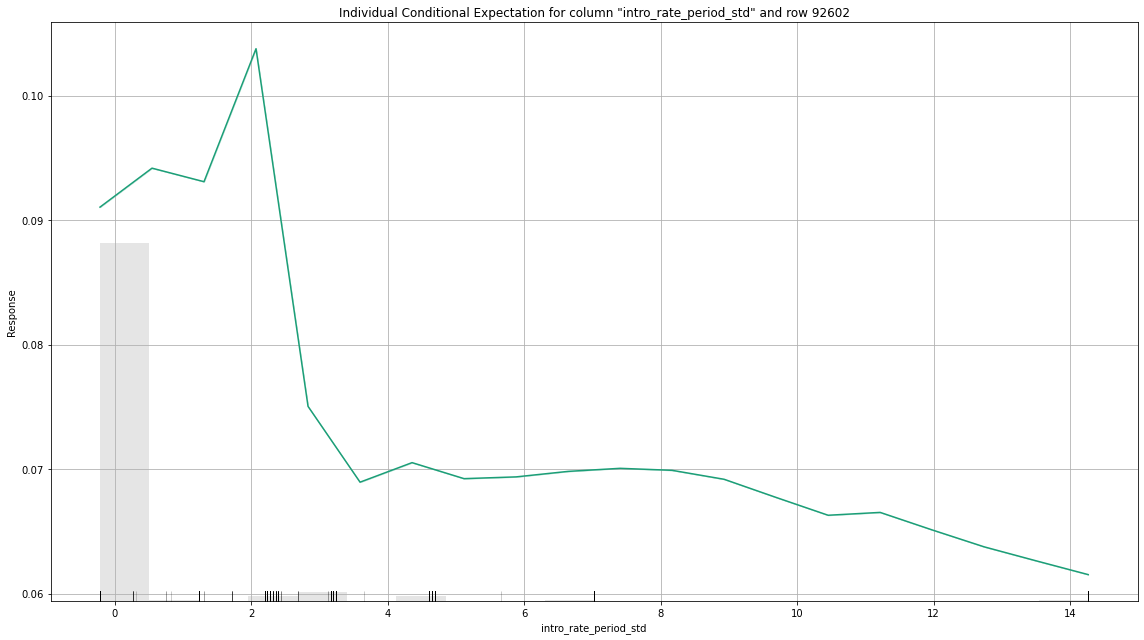

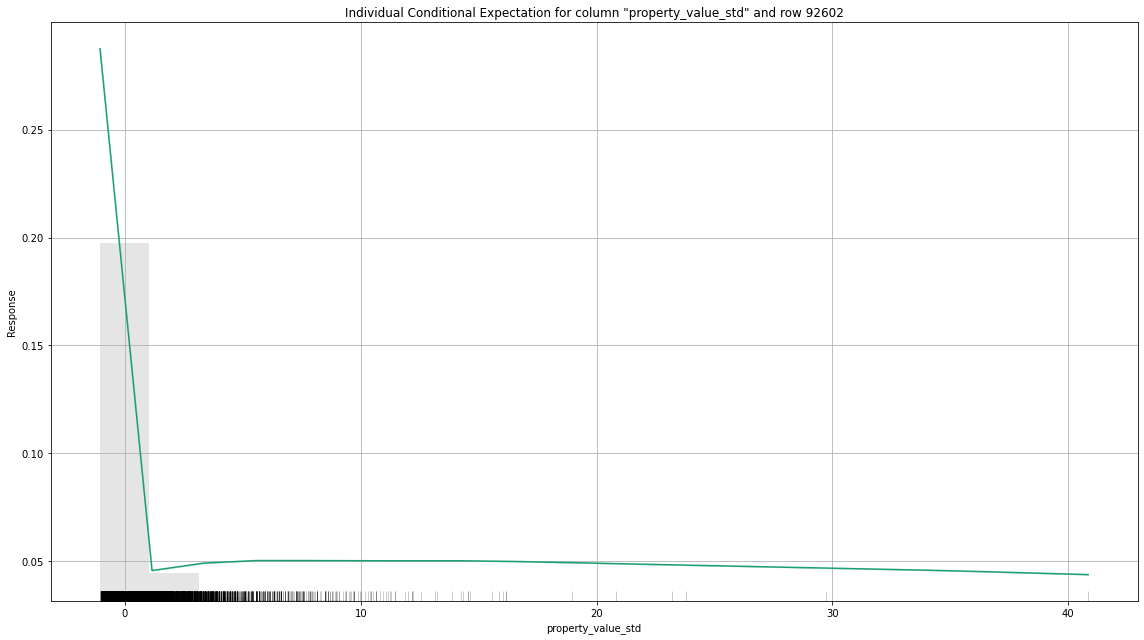

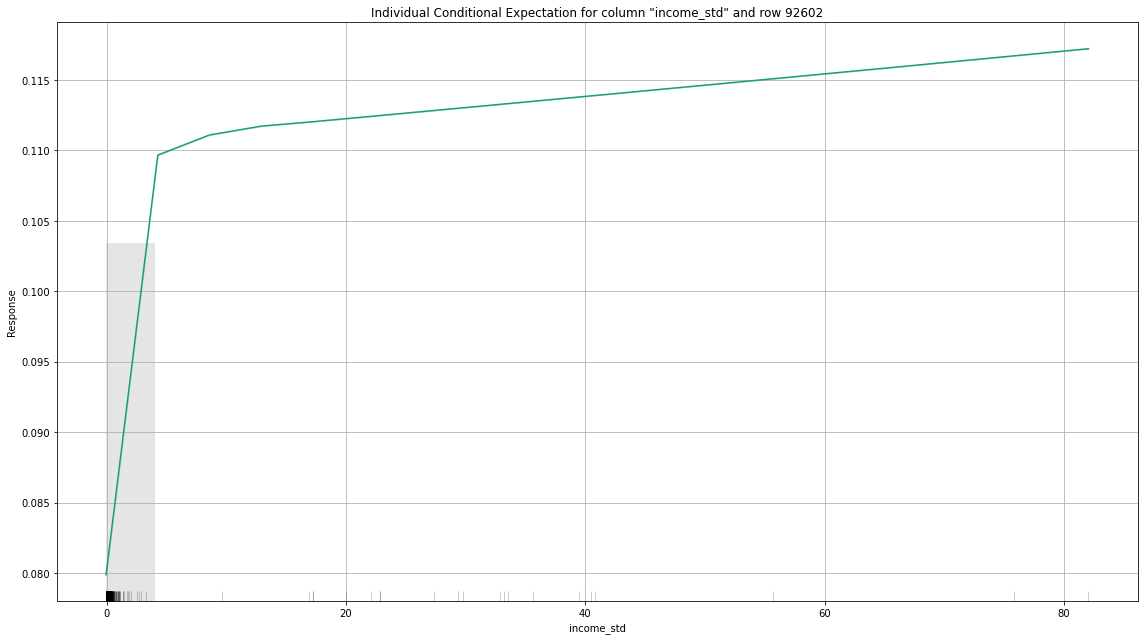

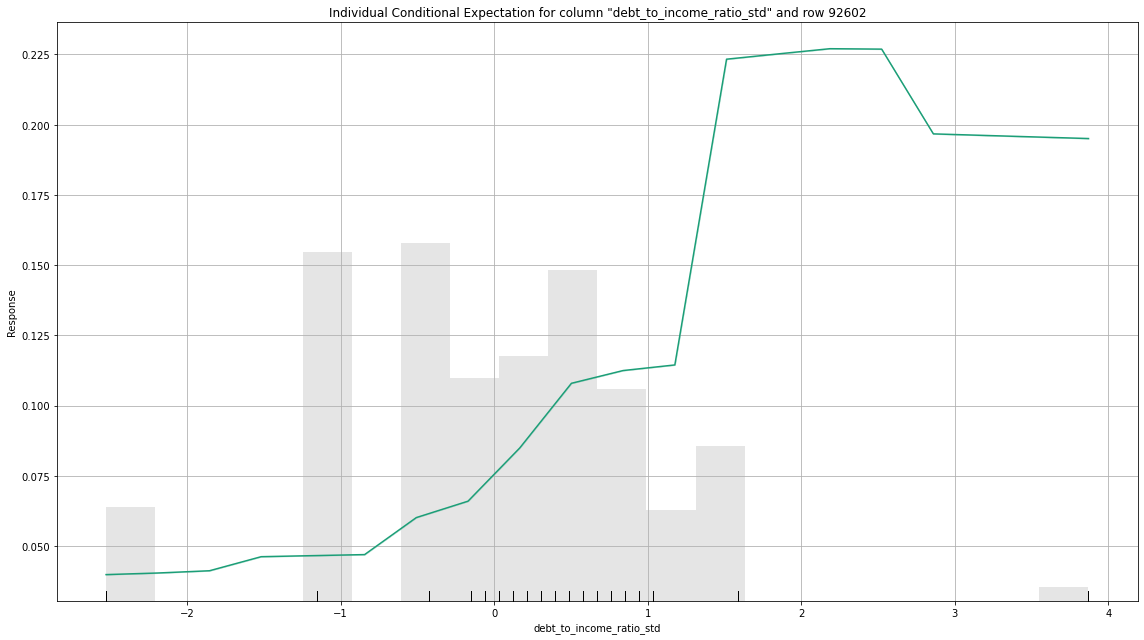

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

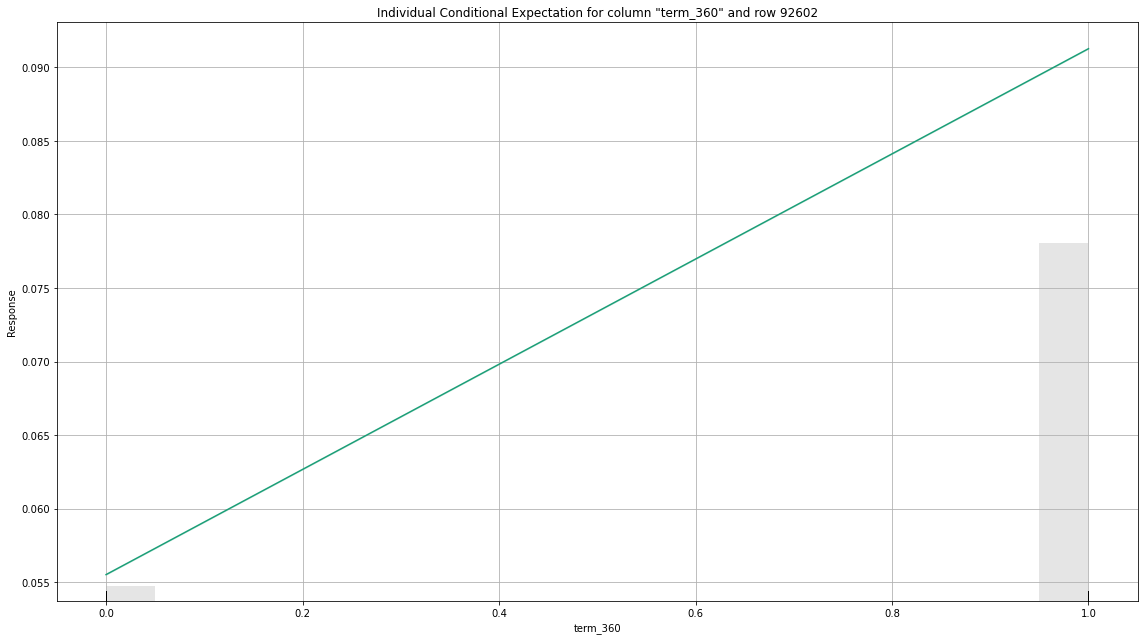

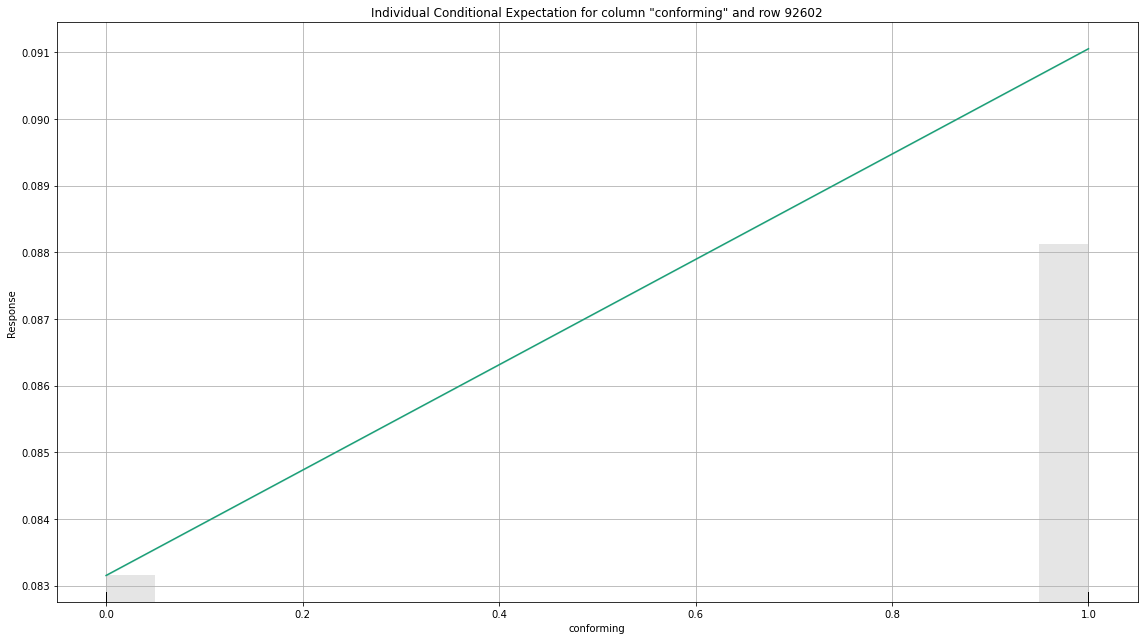

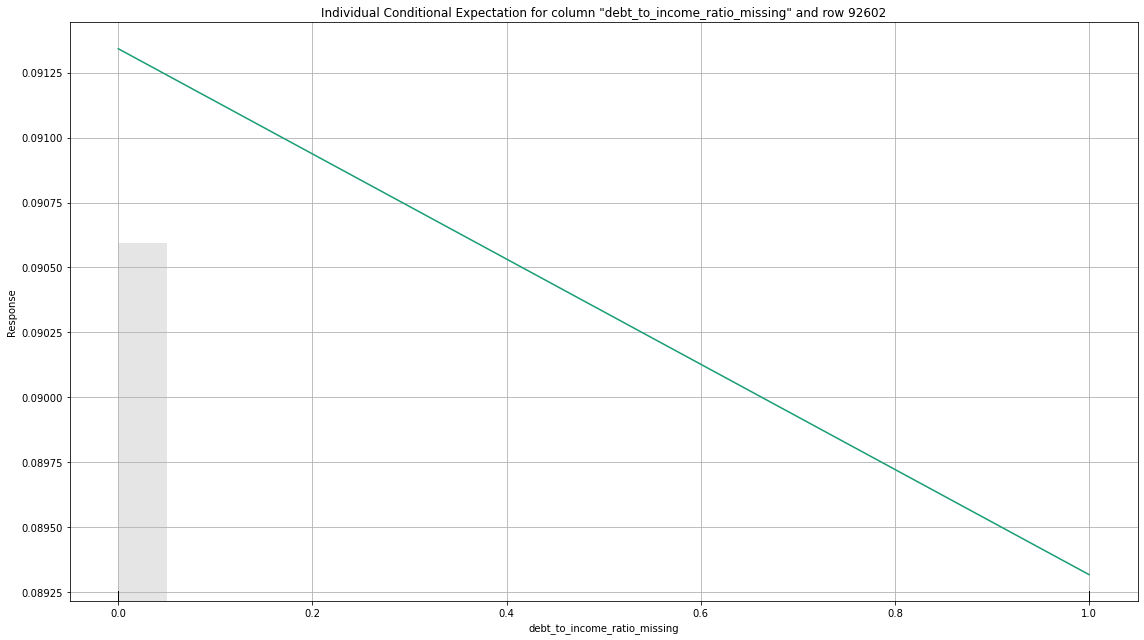

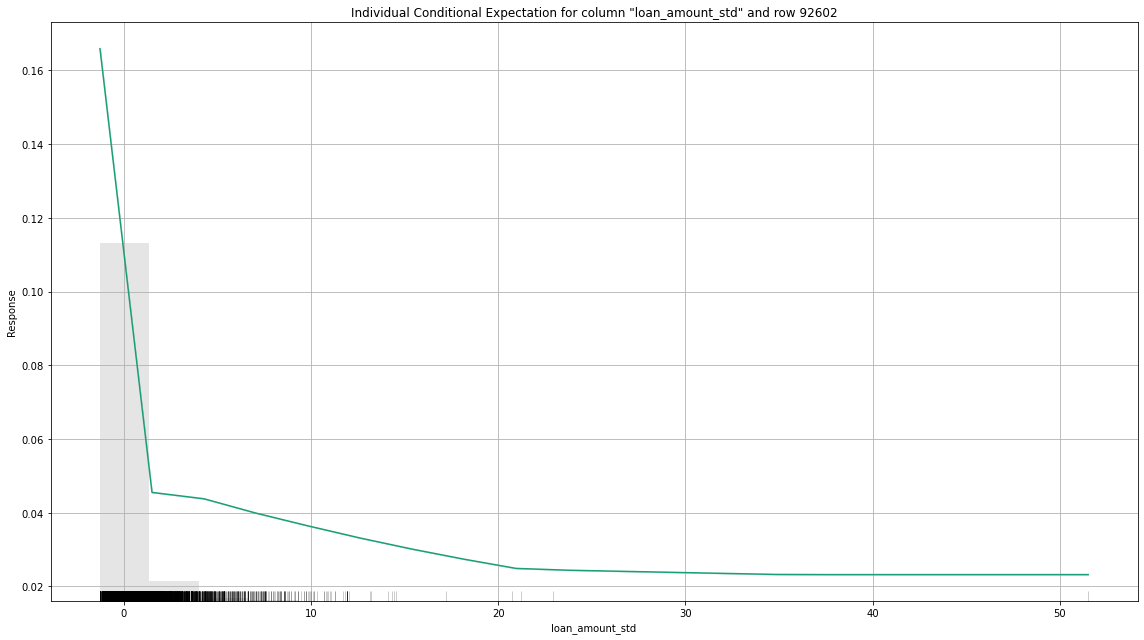

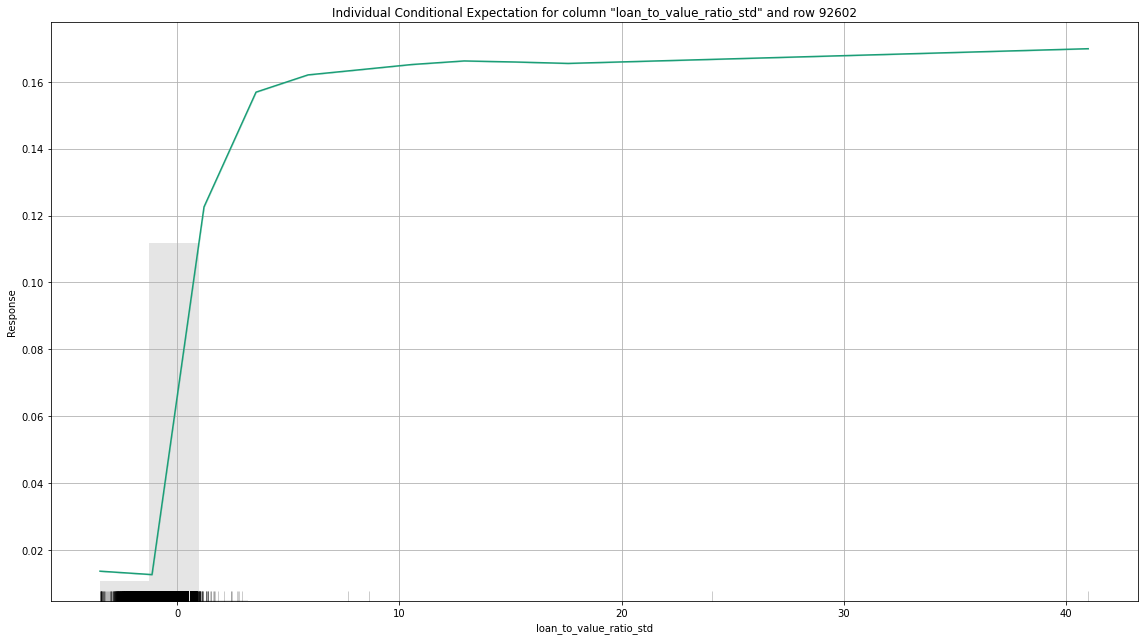

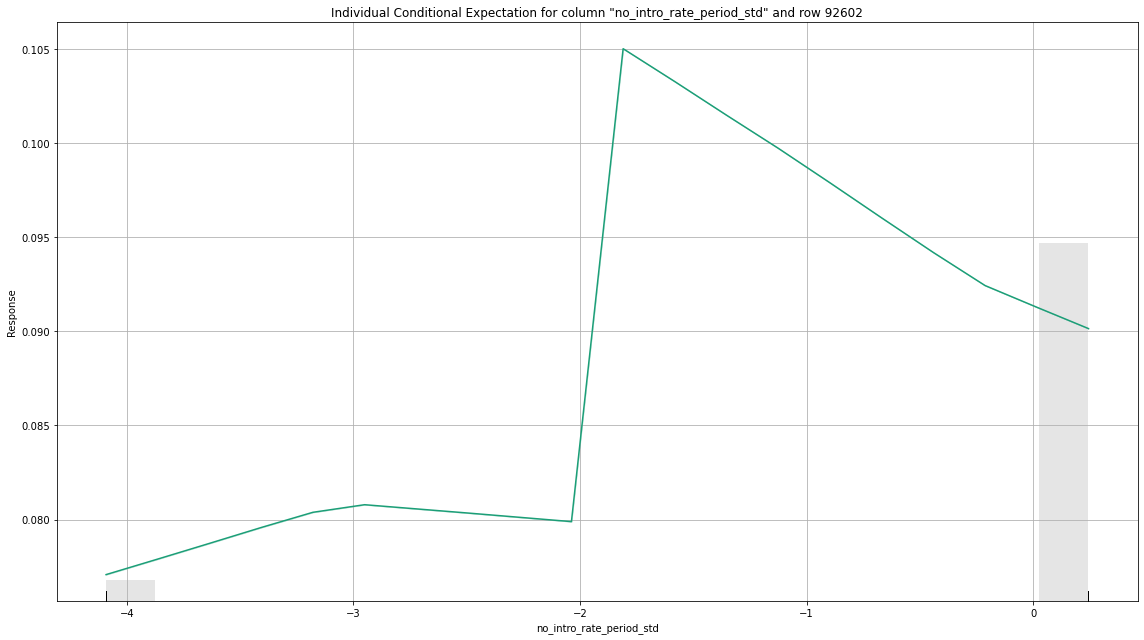

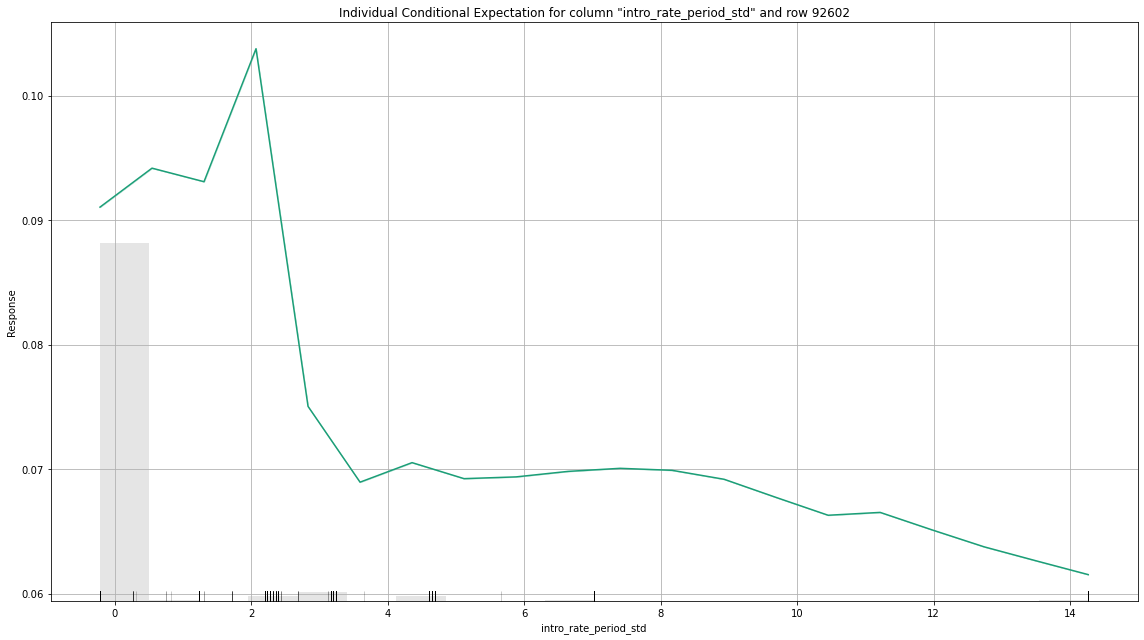

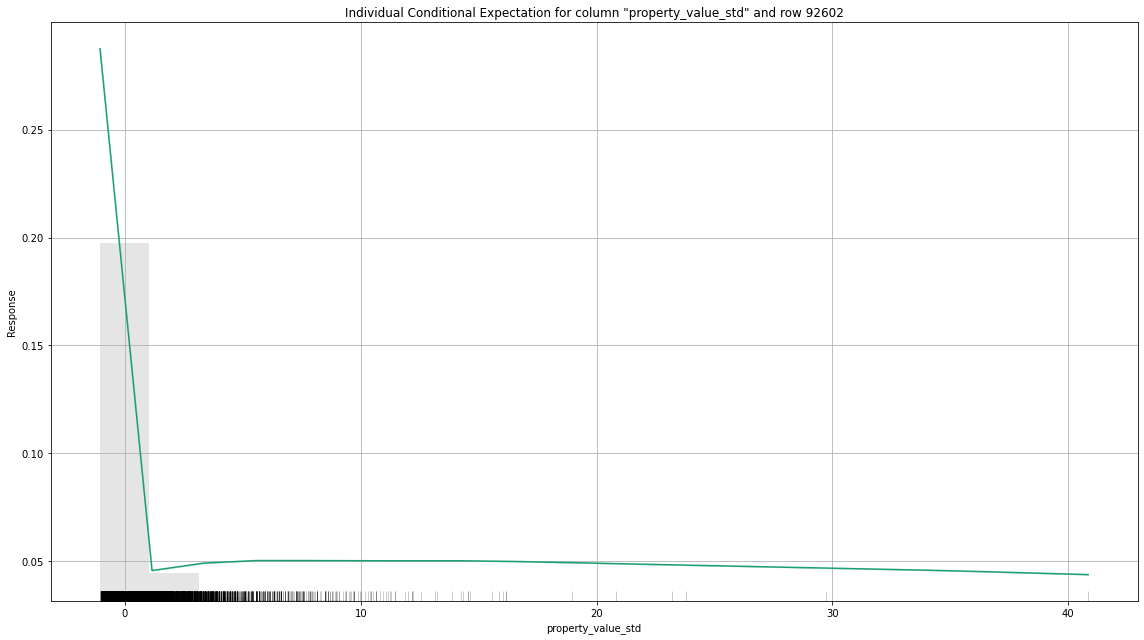

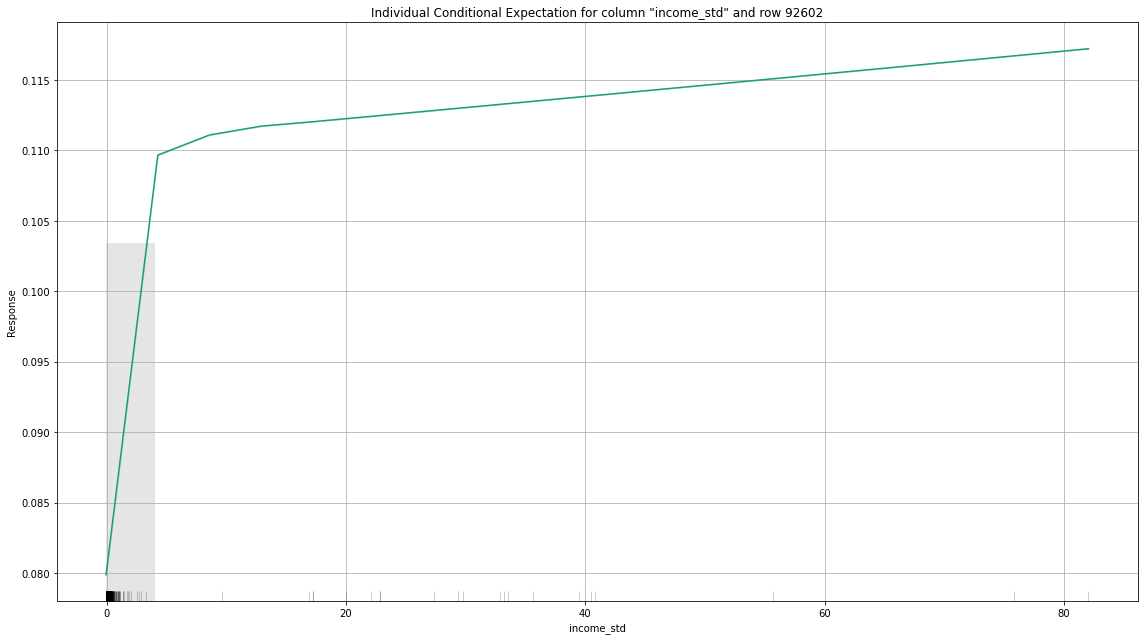

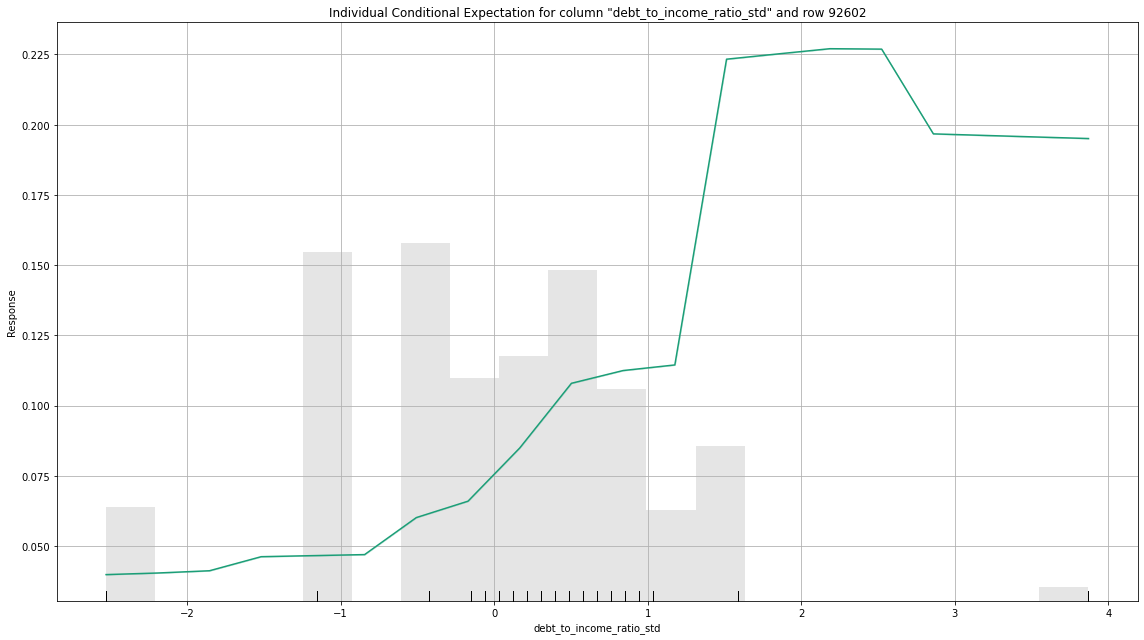

In [34]:
# Explain 90 percentile
ensenble_h2o.explain_row(hvalid, row_index=92602)

### H2O Analysis: gbm

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

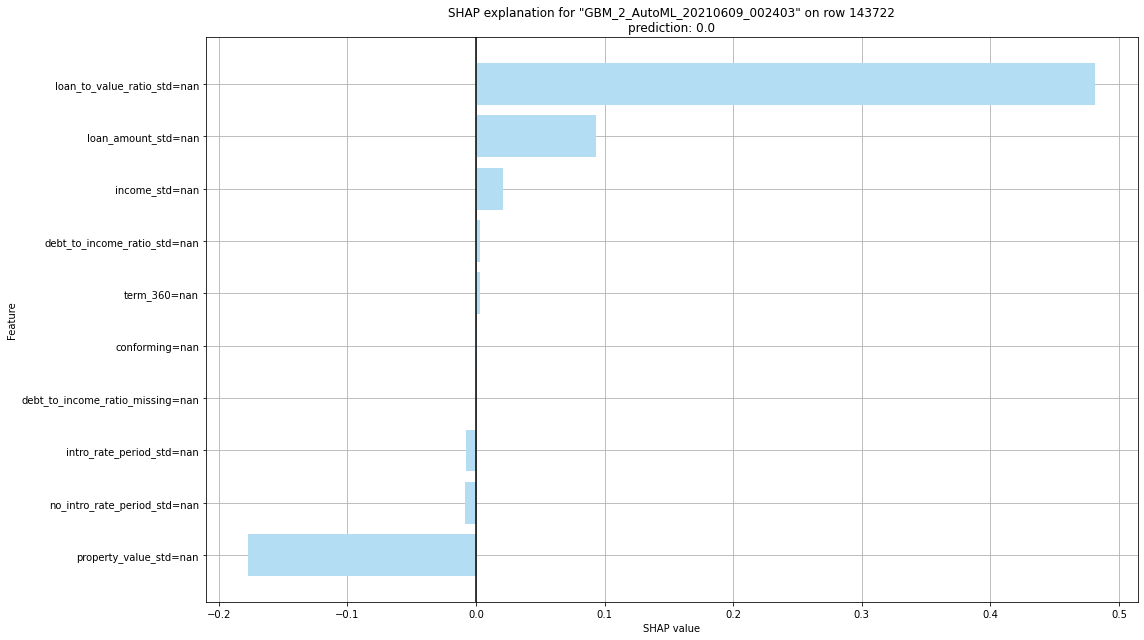

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

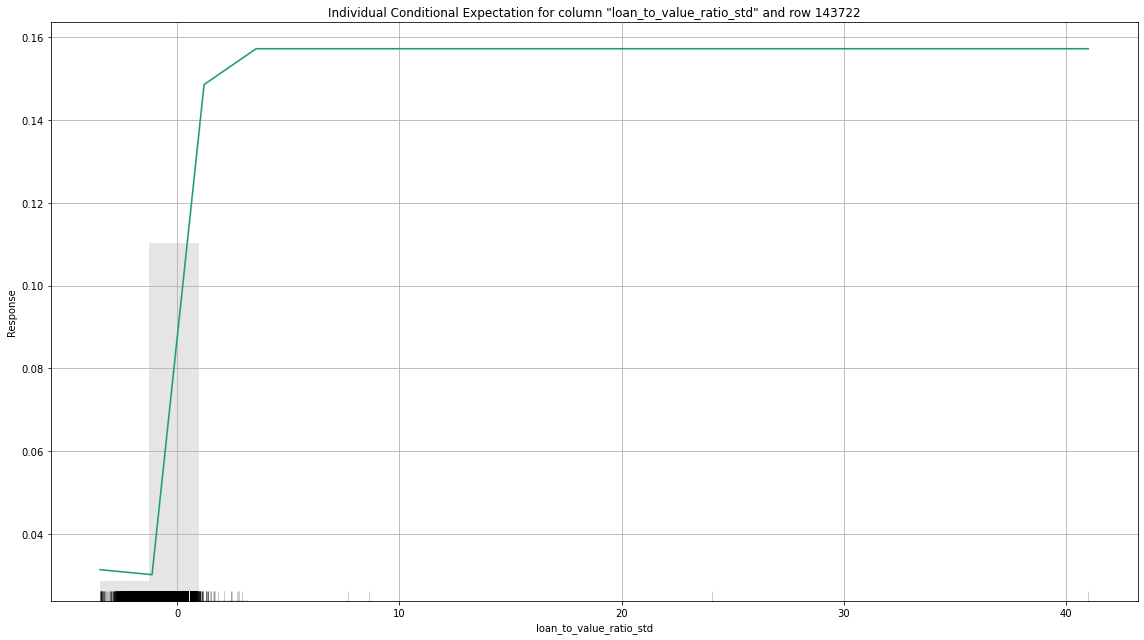

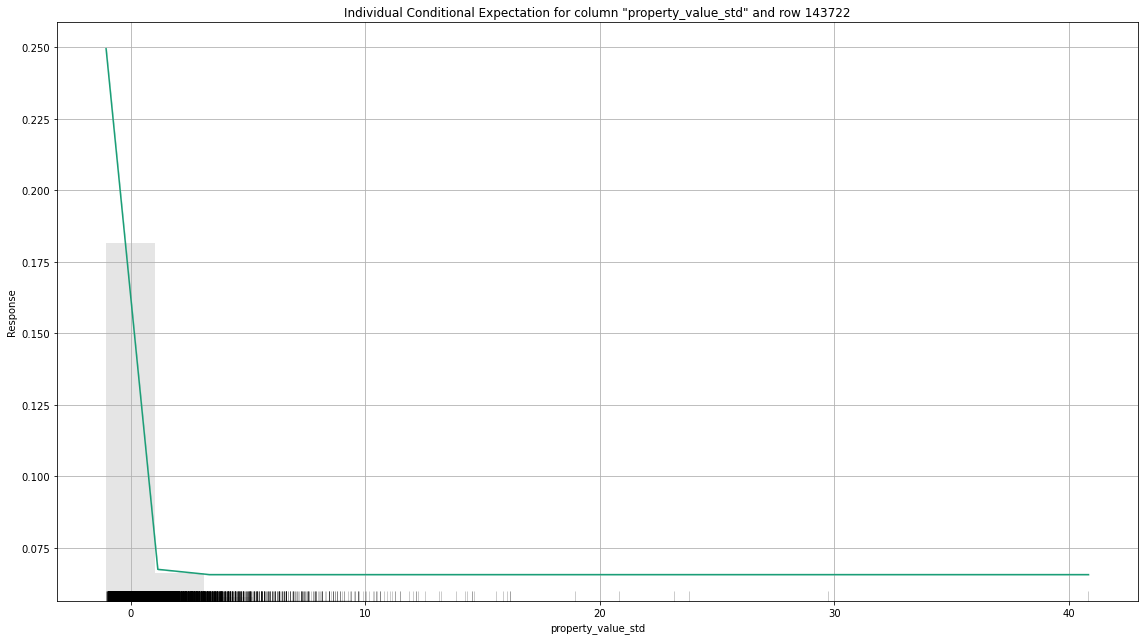

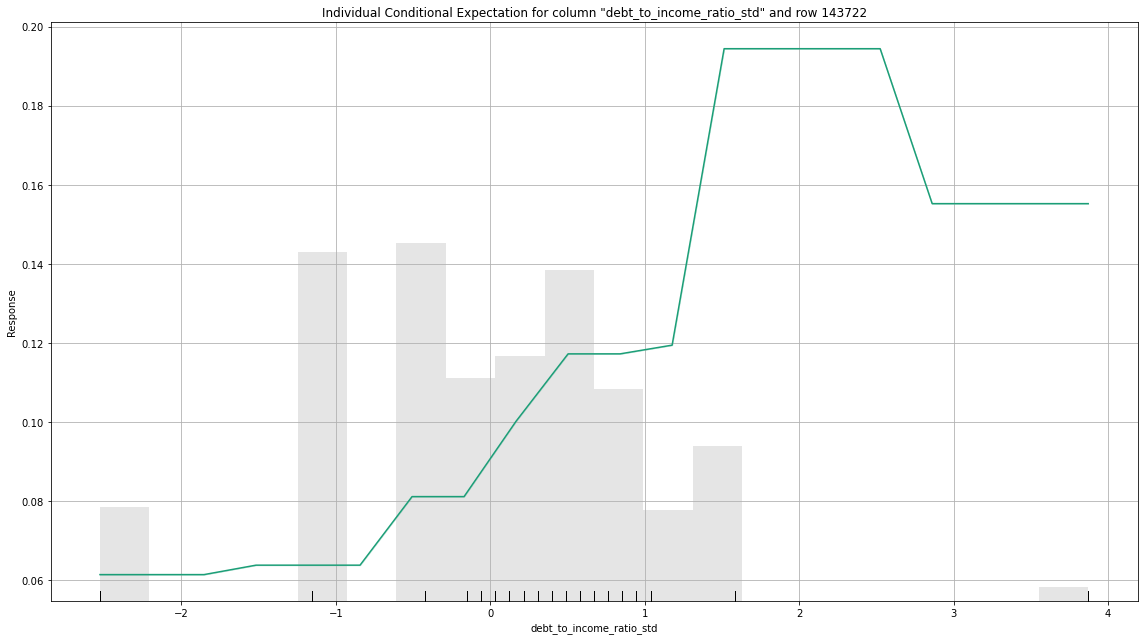

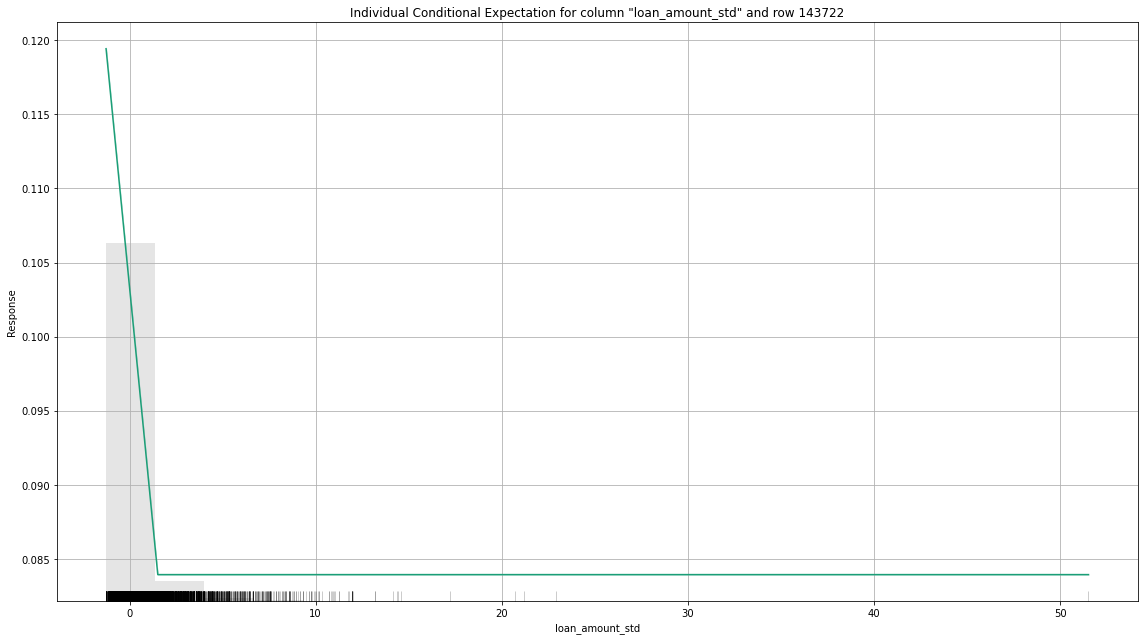

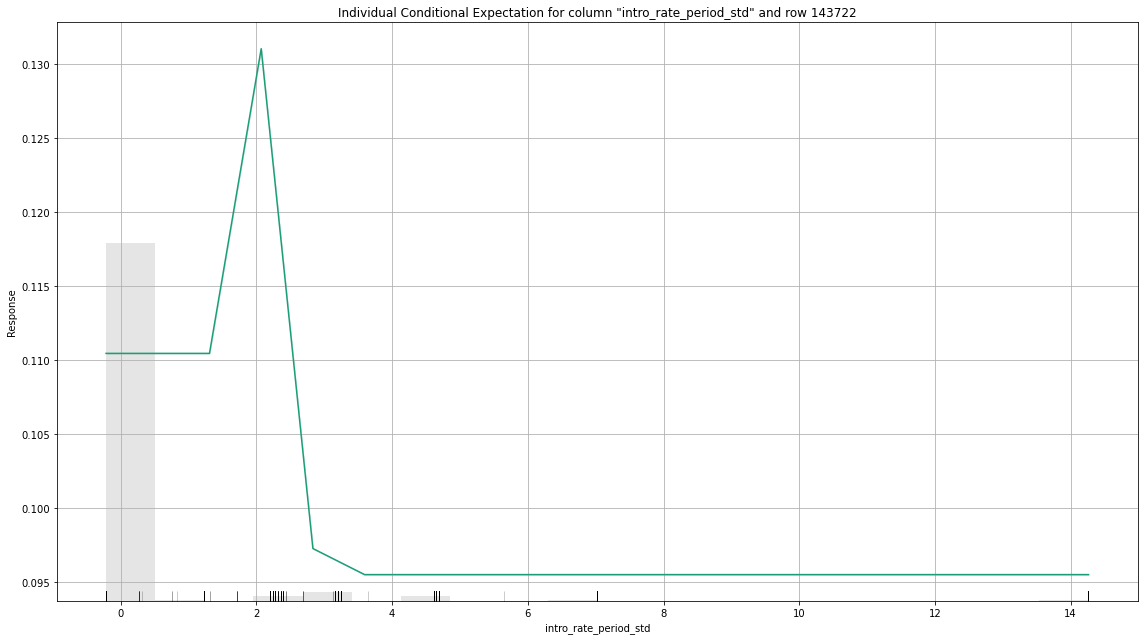

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

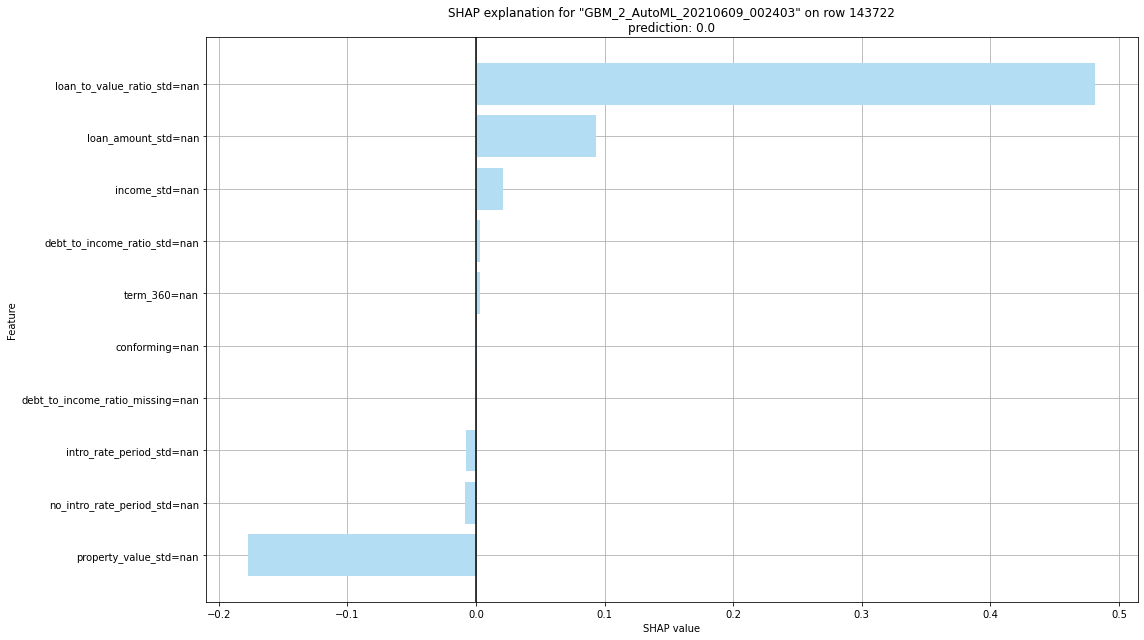

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

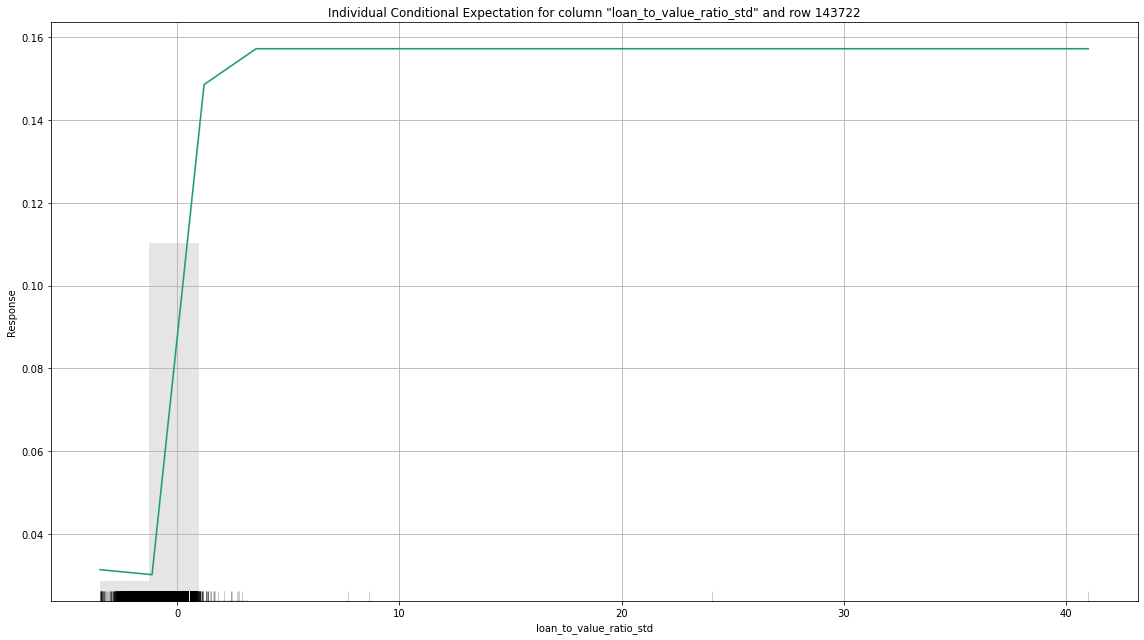

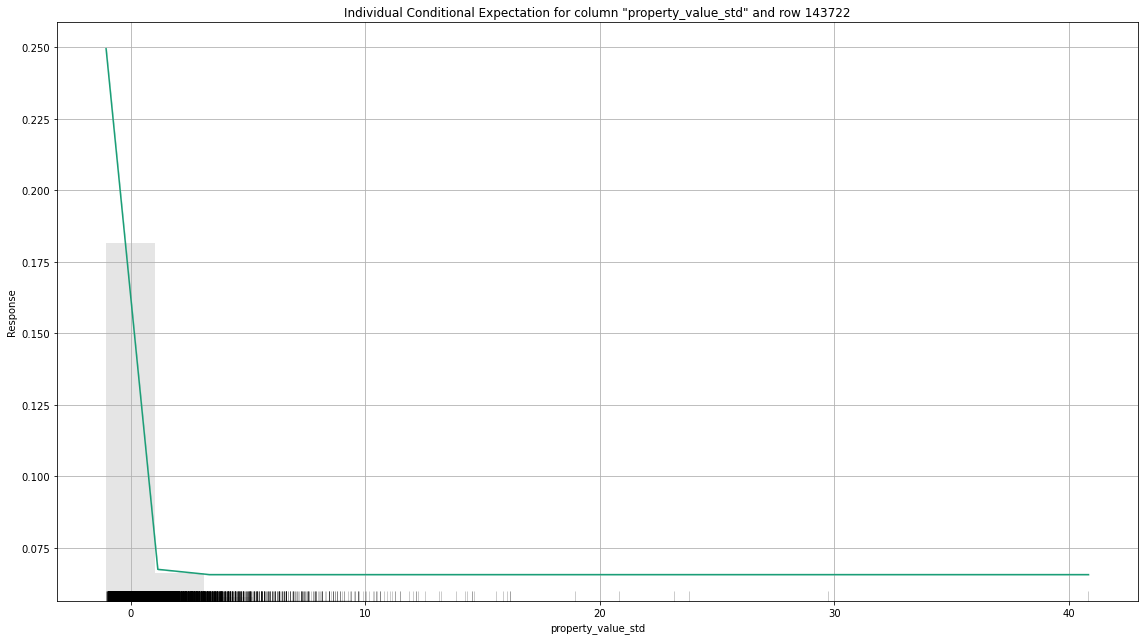

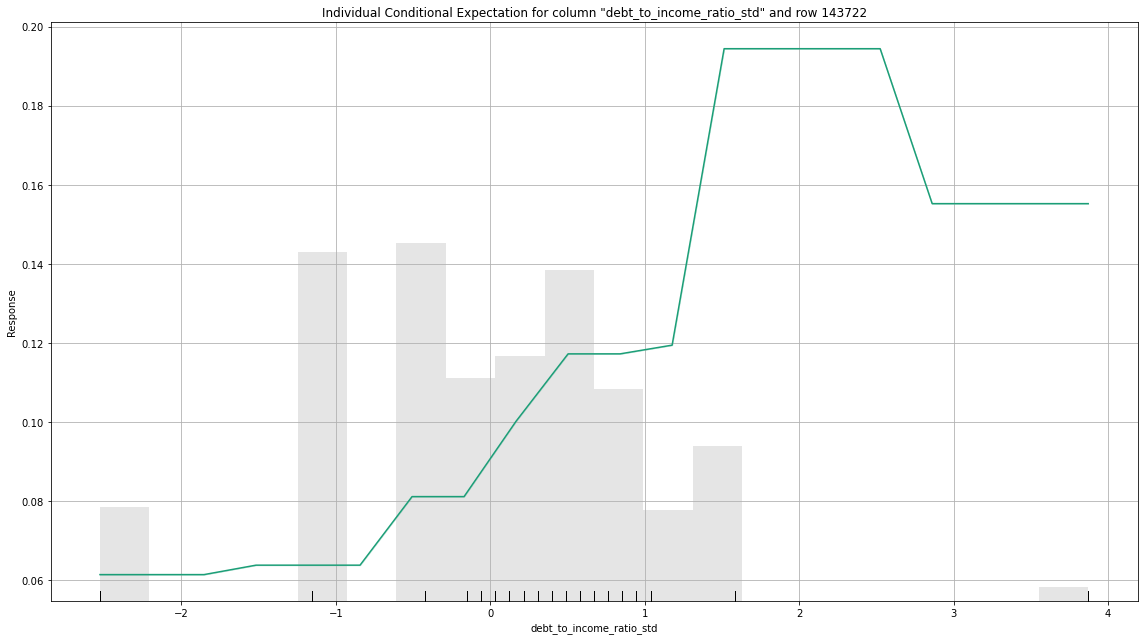

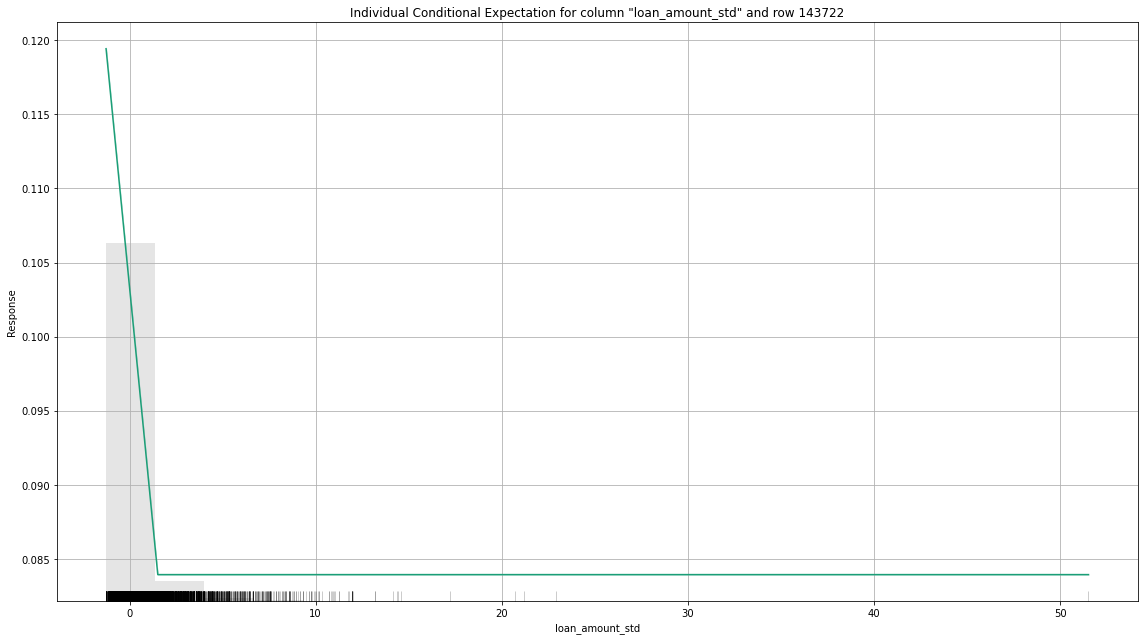

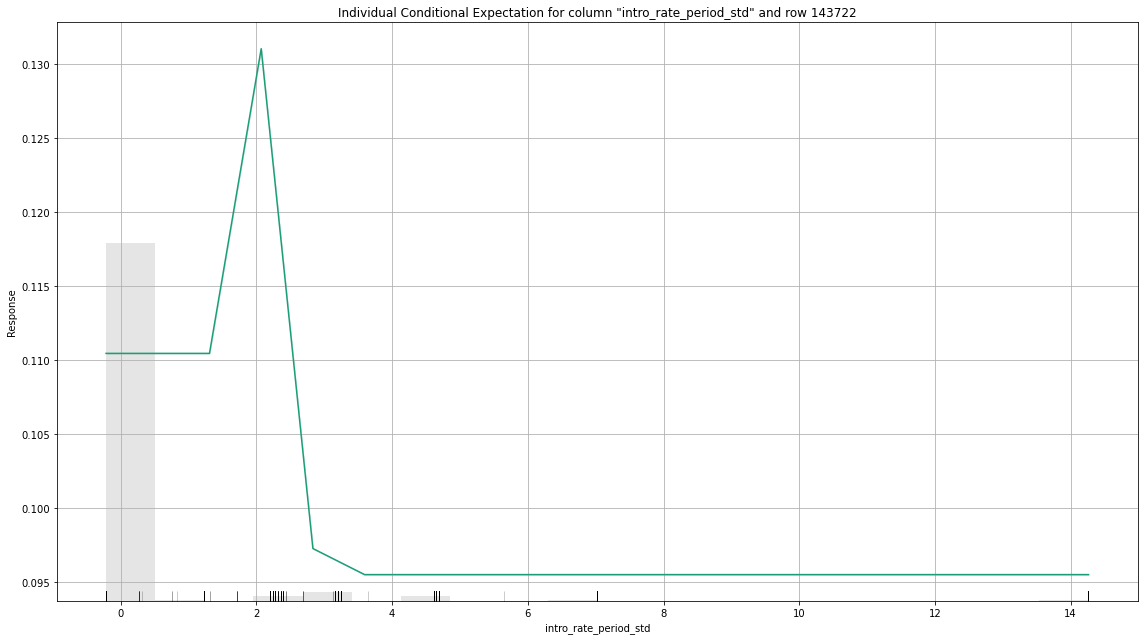

In [35]:
# Explain 10 percentile
gbm_h2o.explain_row(hvalid, row_index=143722)

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

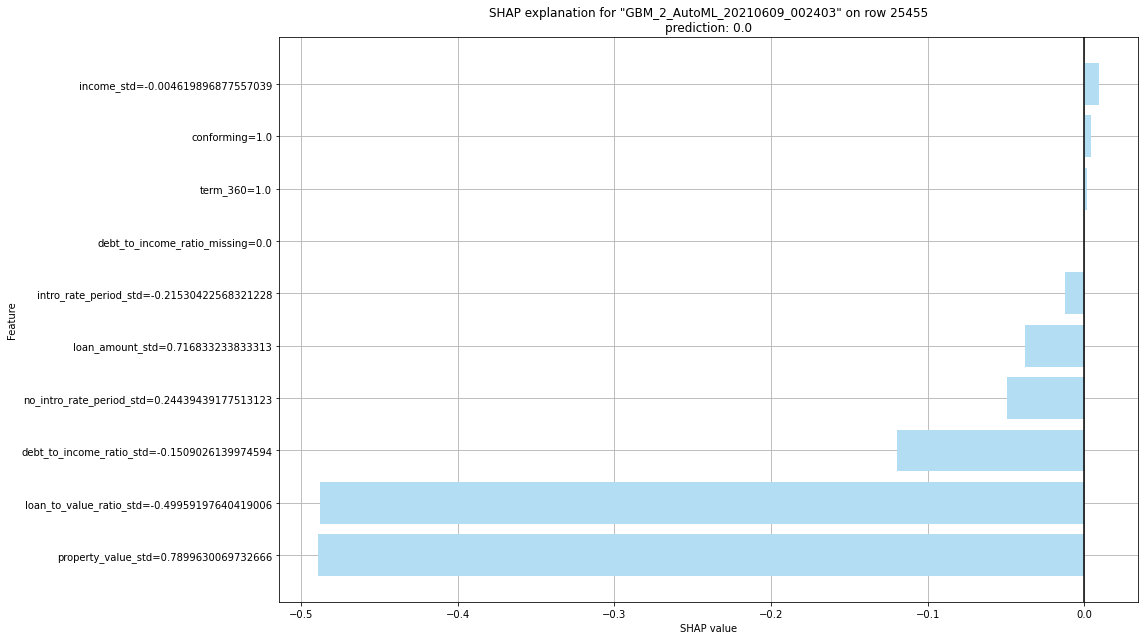

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

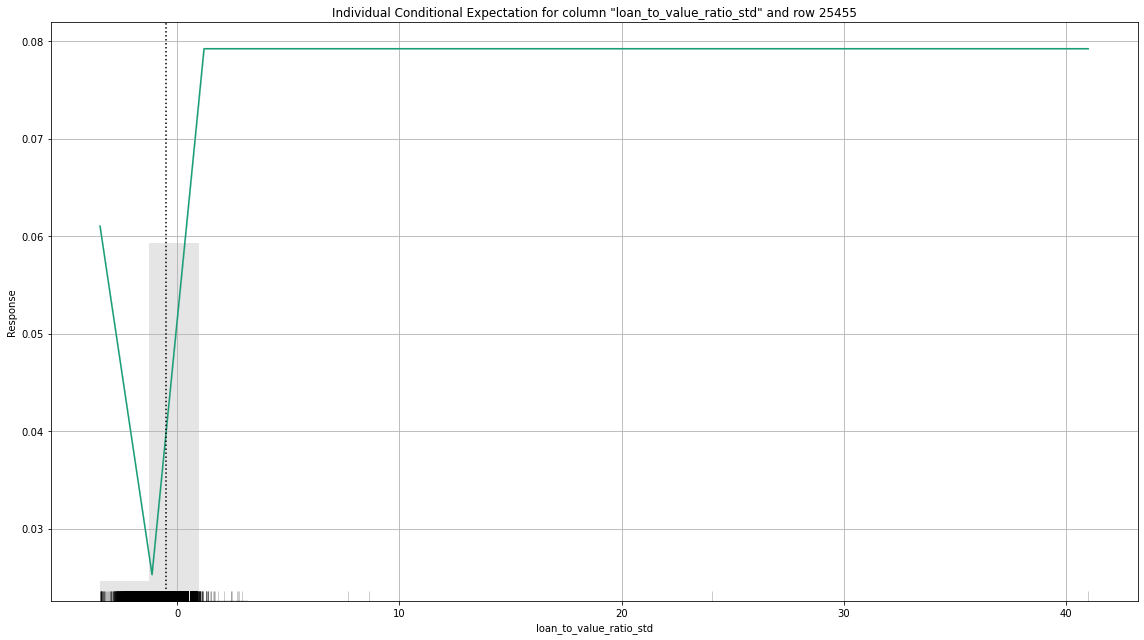

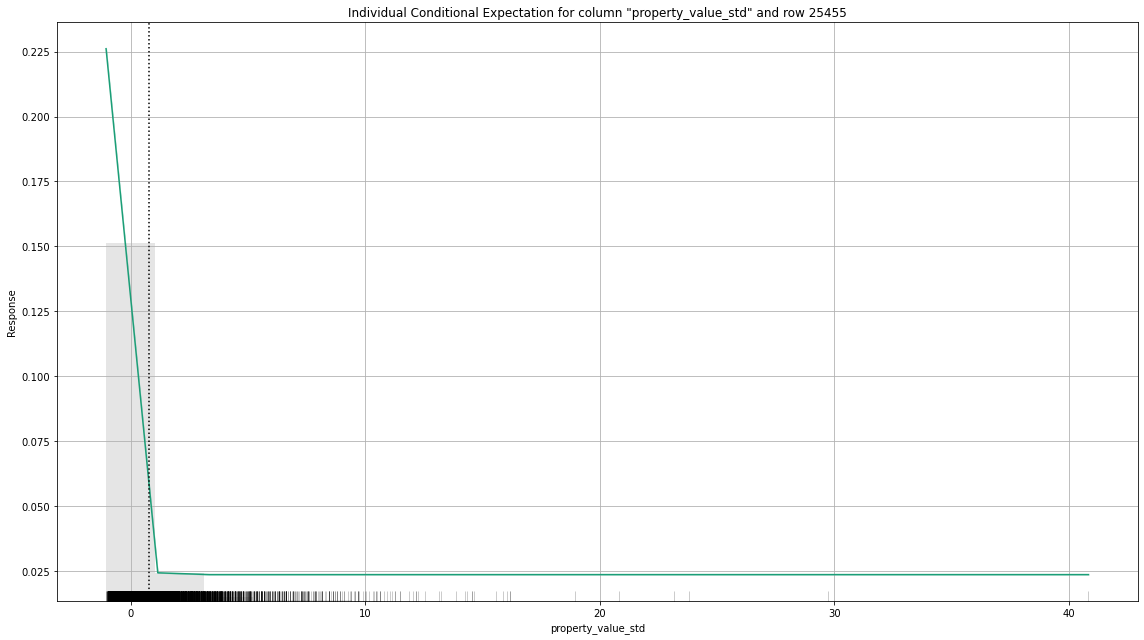

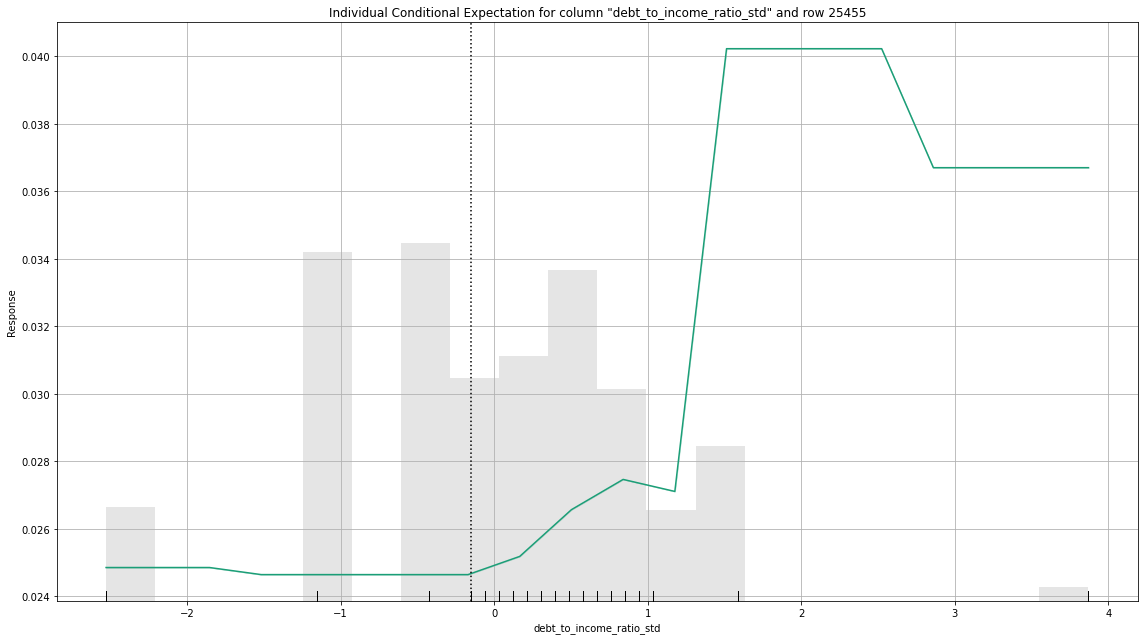

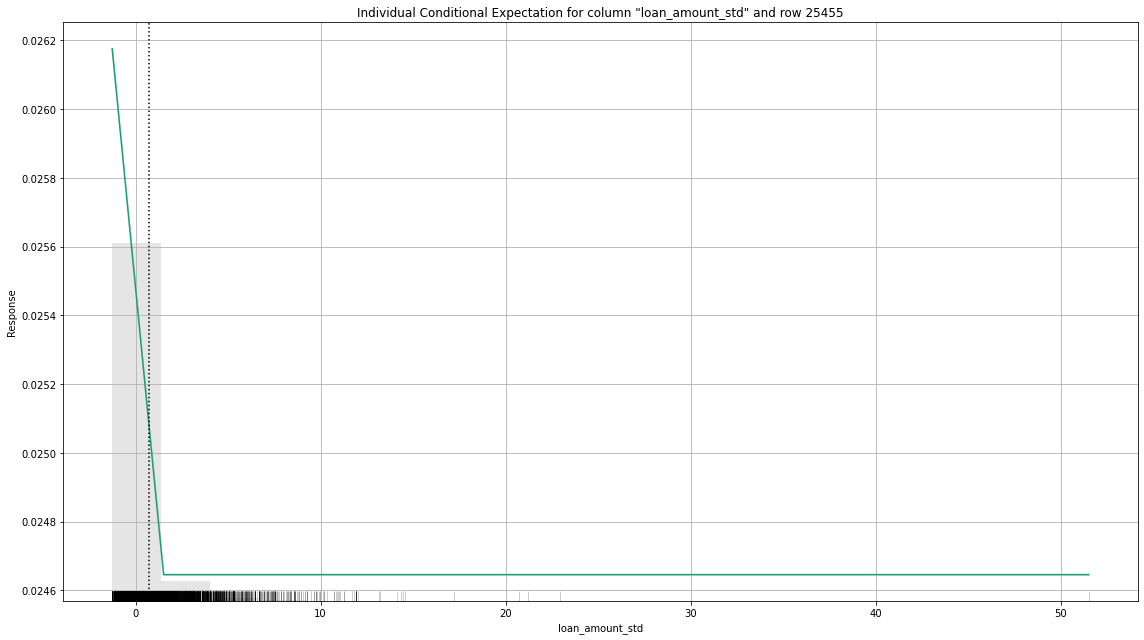

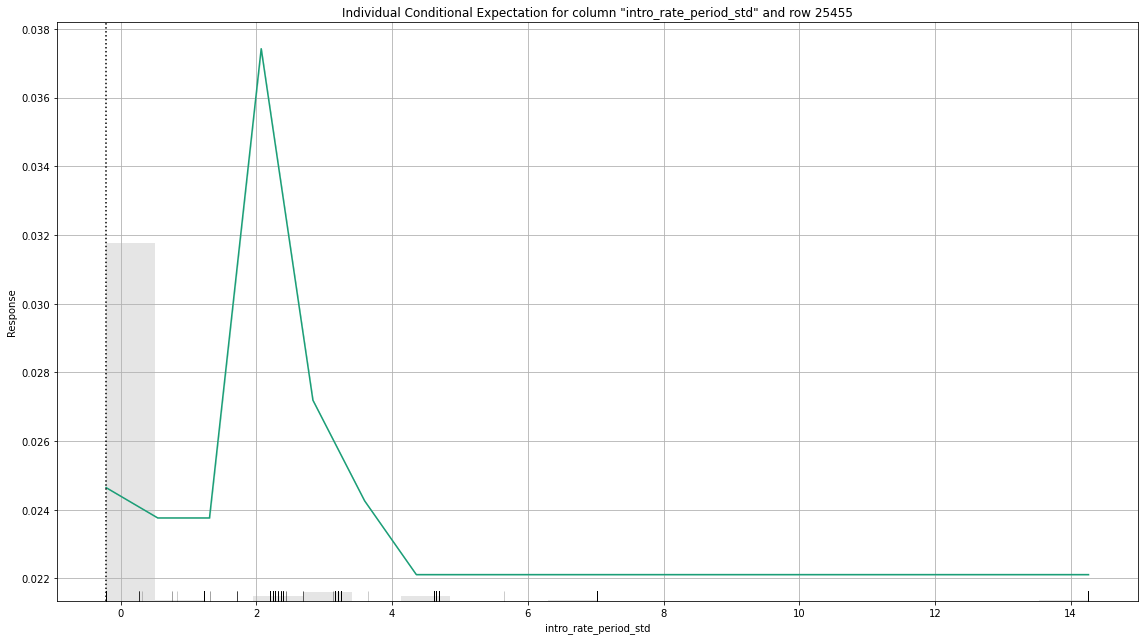

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

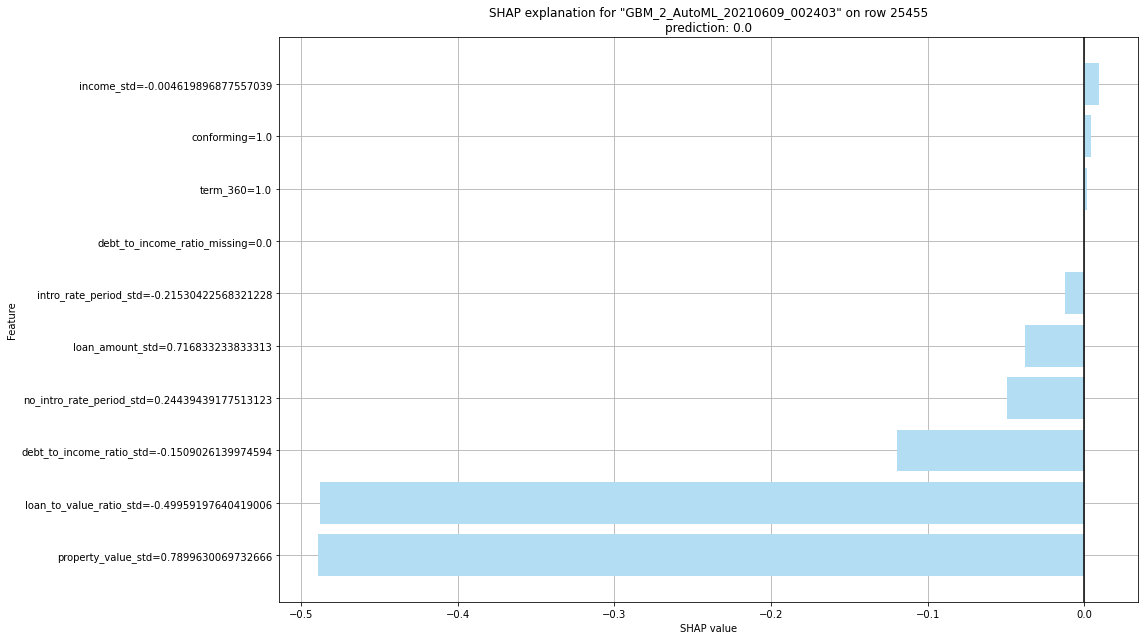

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

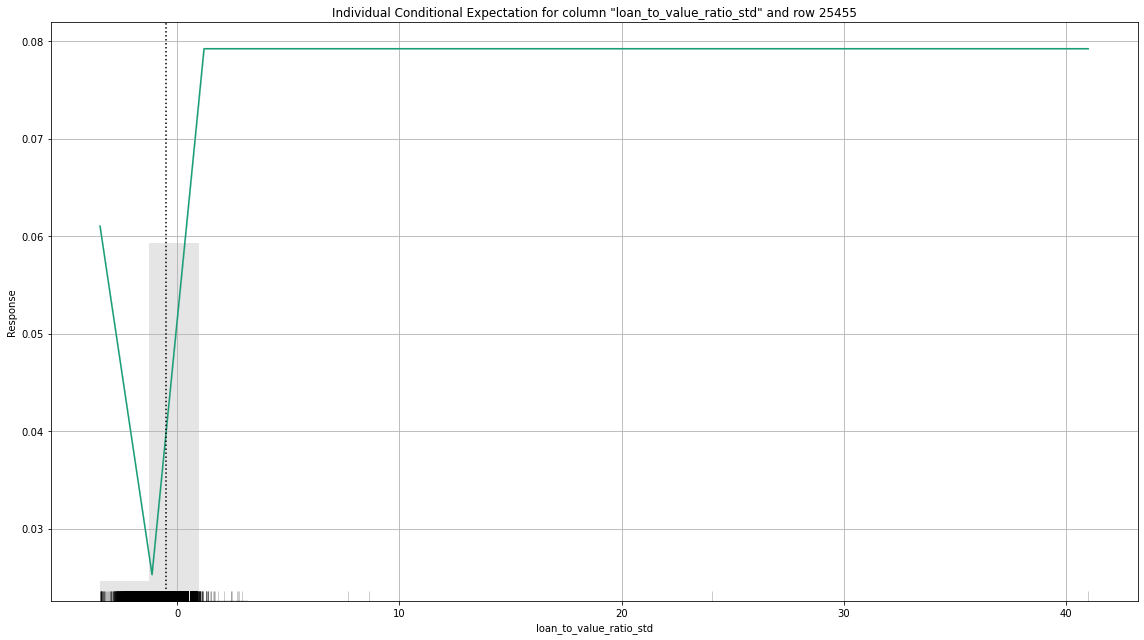

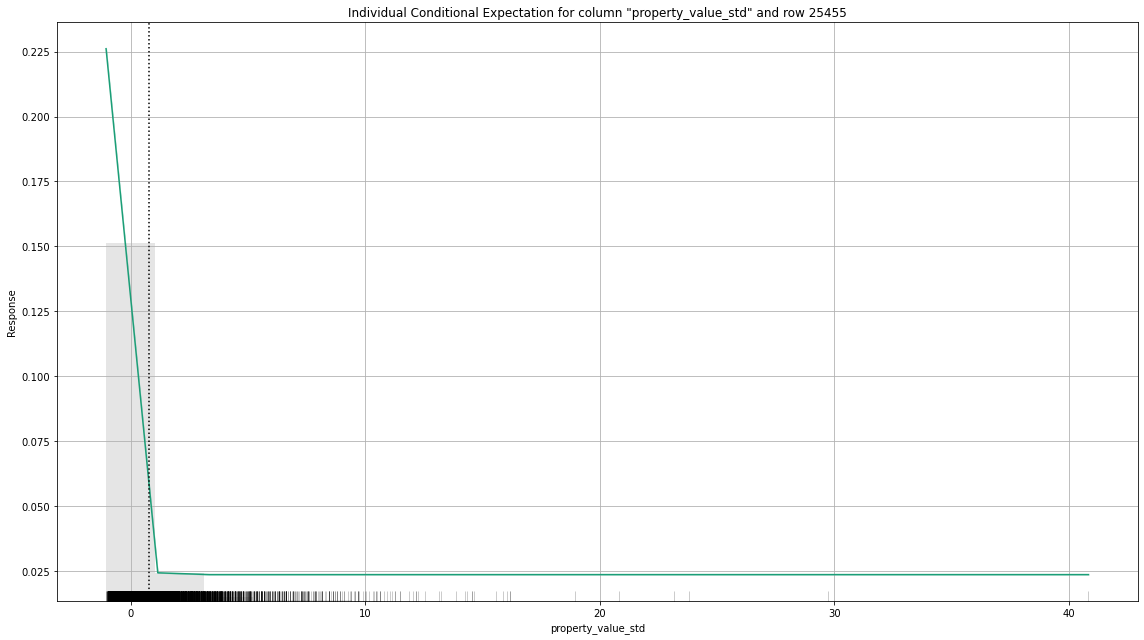

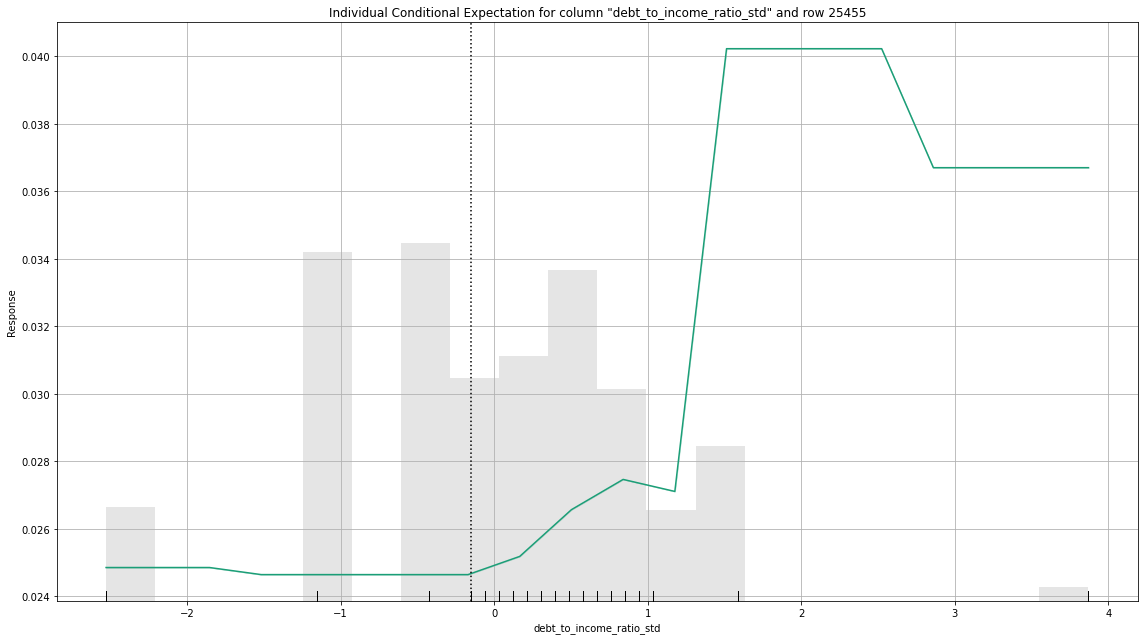

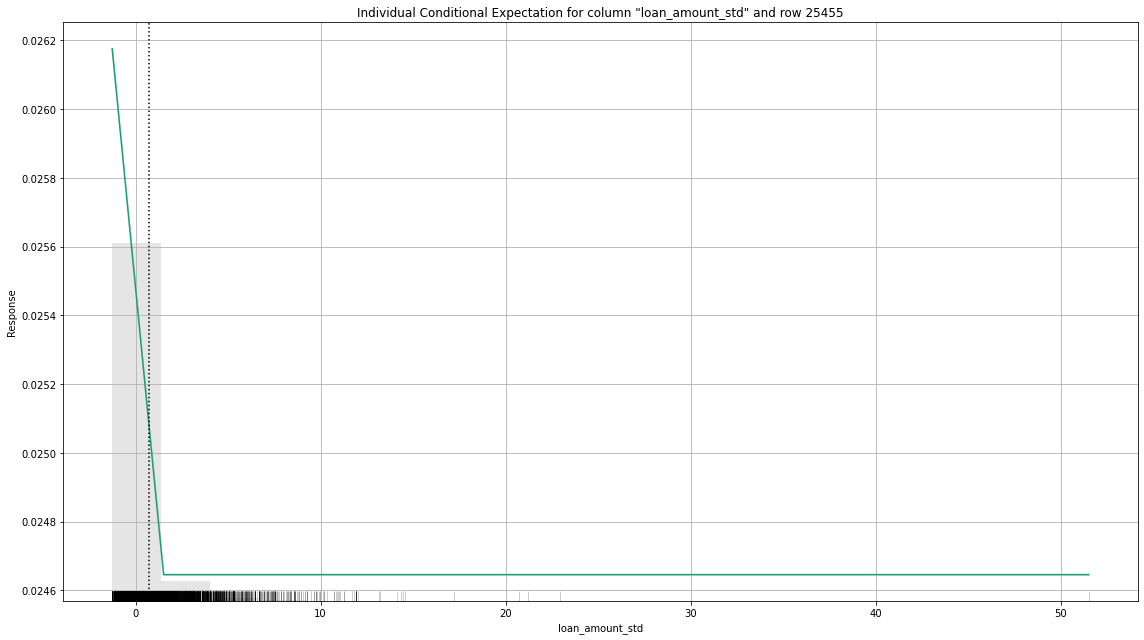

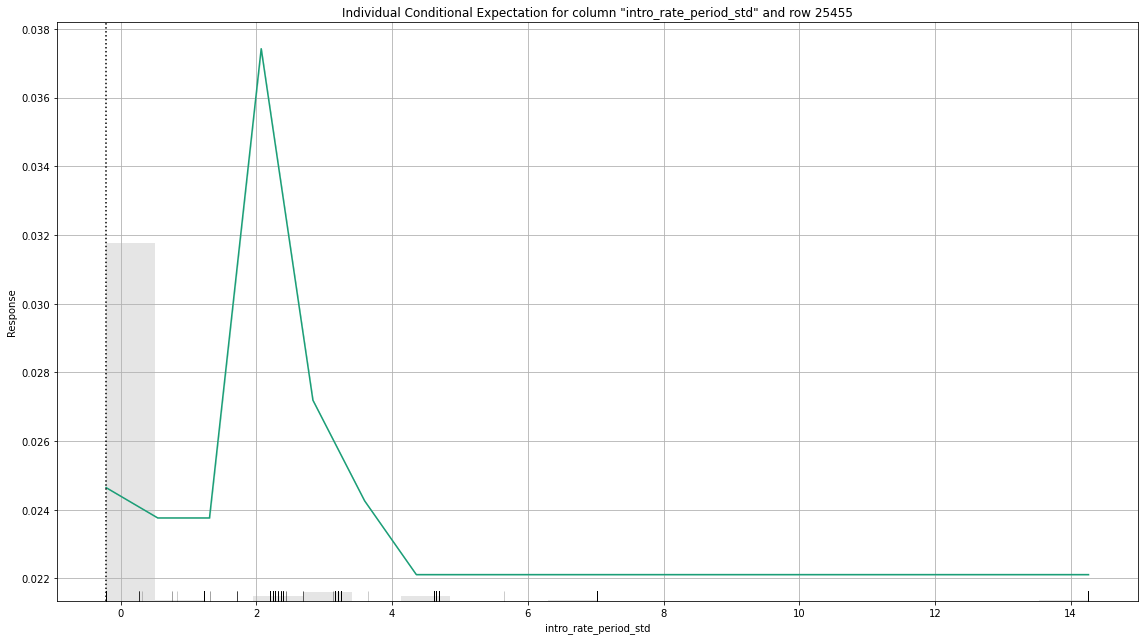

In [36]:
# Explain 50 percentile
gbm_h2o.explain_row(hvalid, row_index=25455)

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

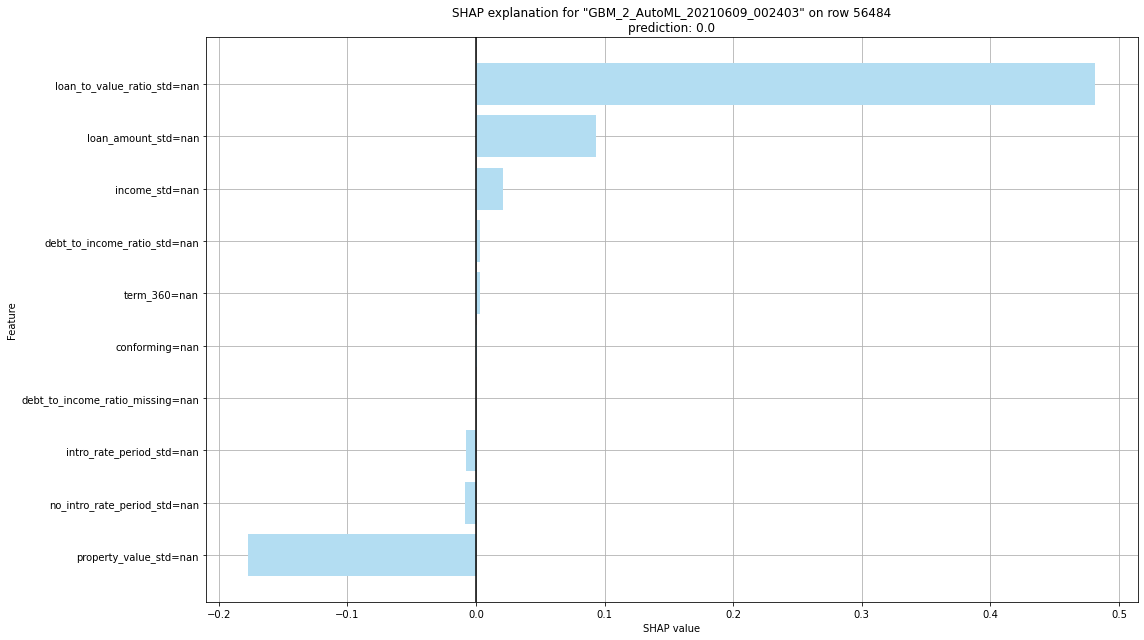

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

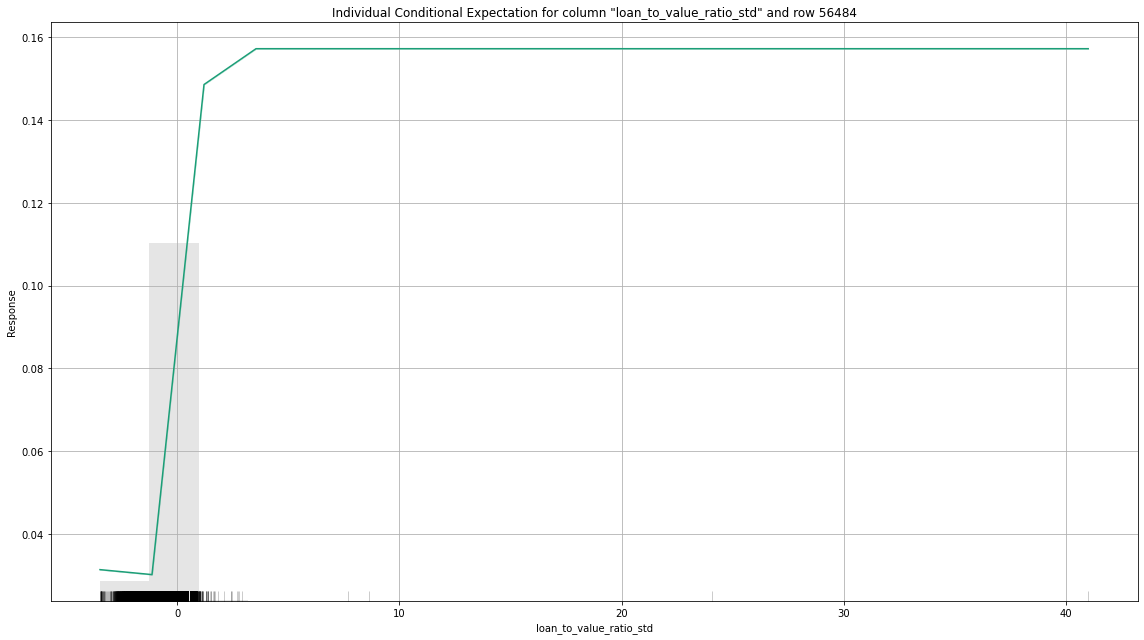

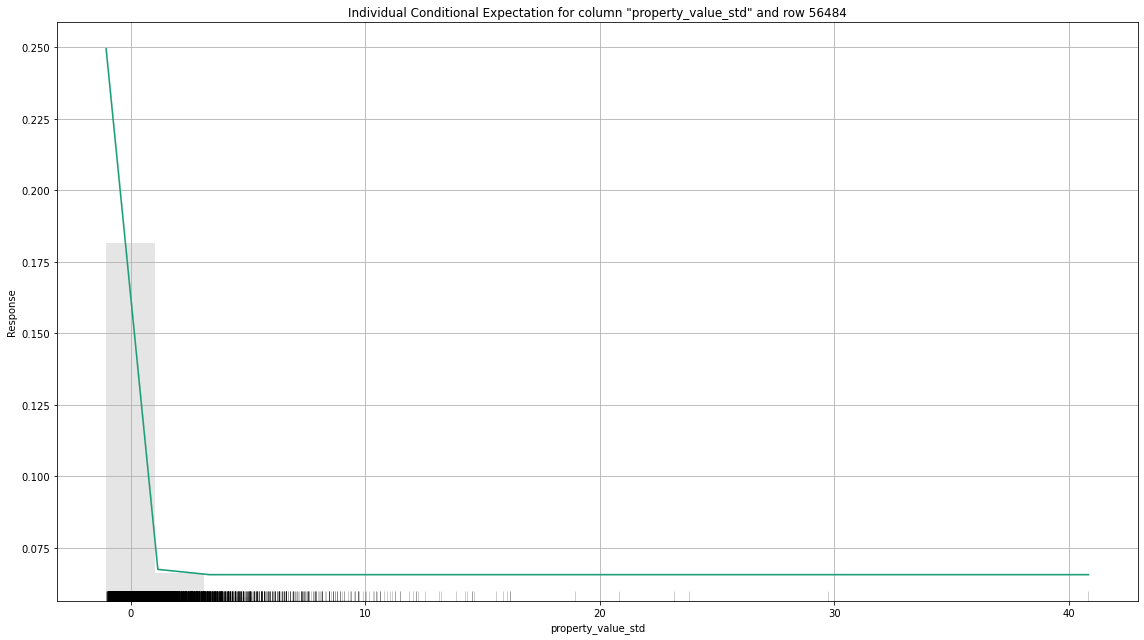

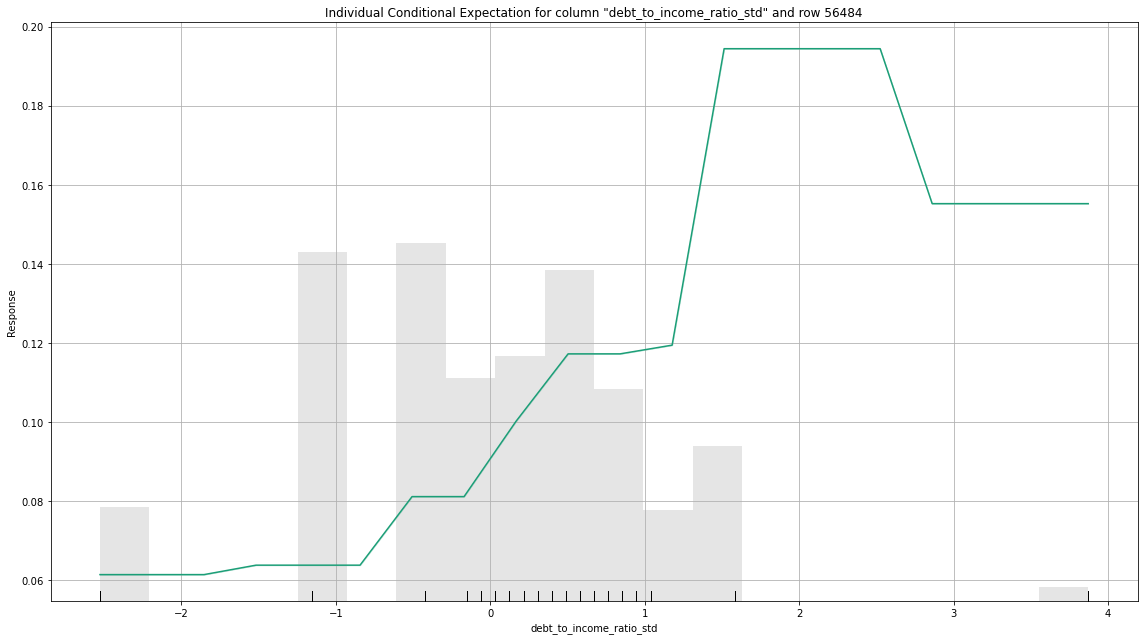

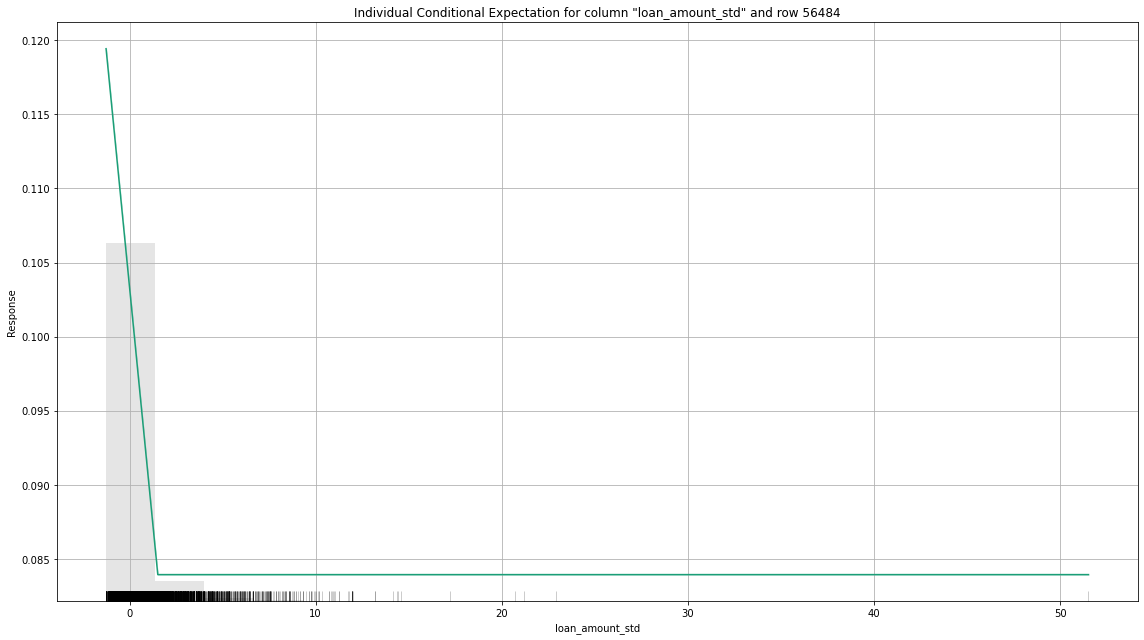

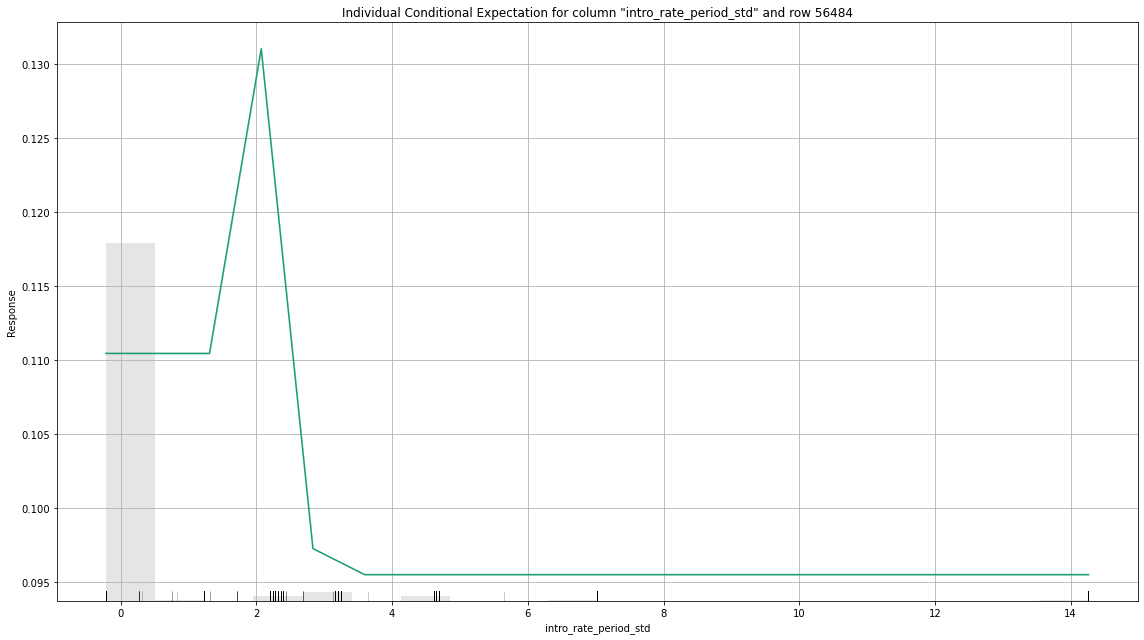

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

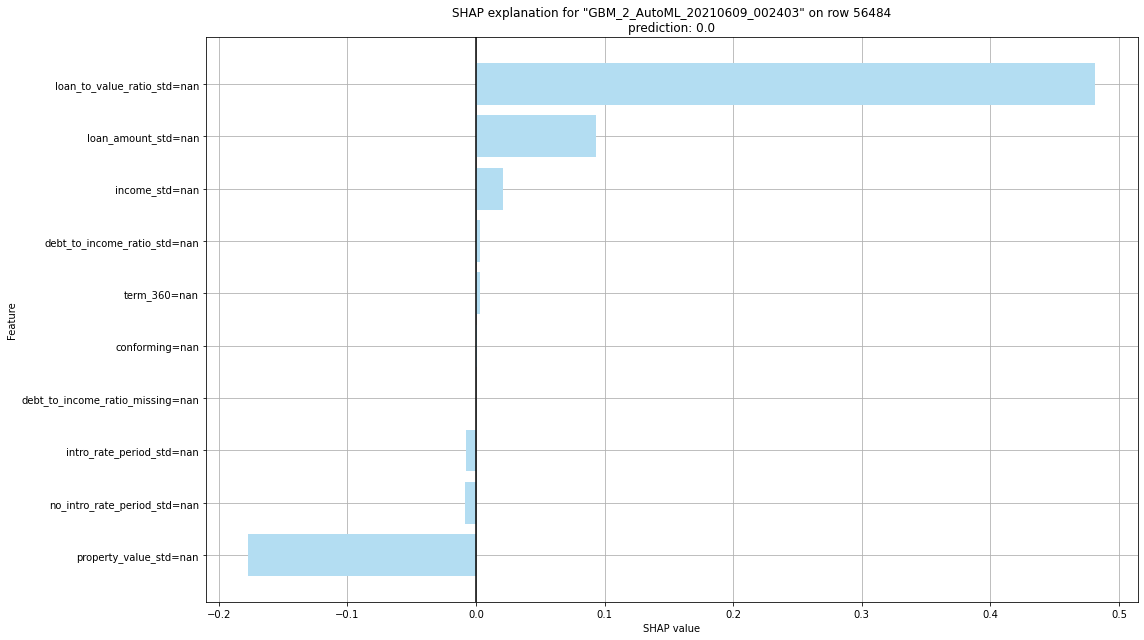

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

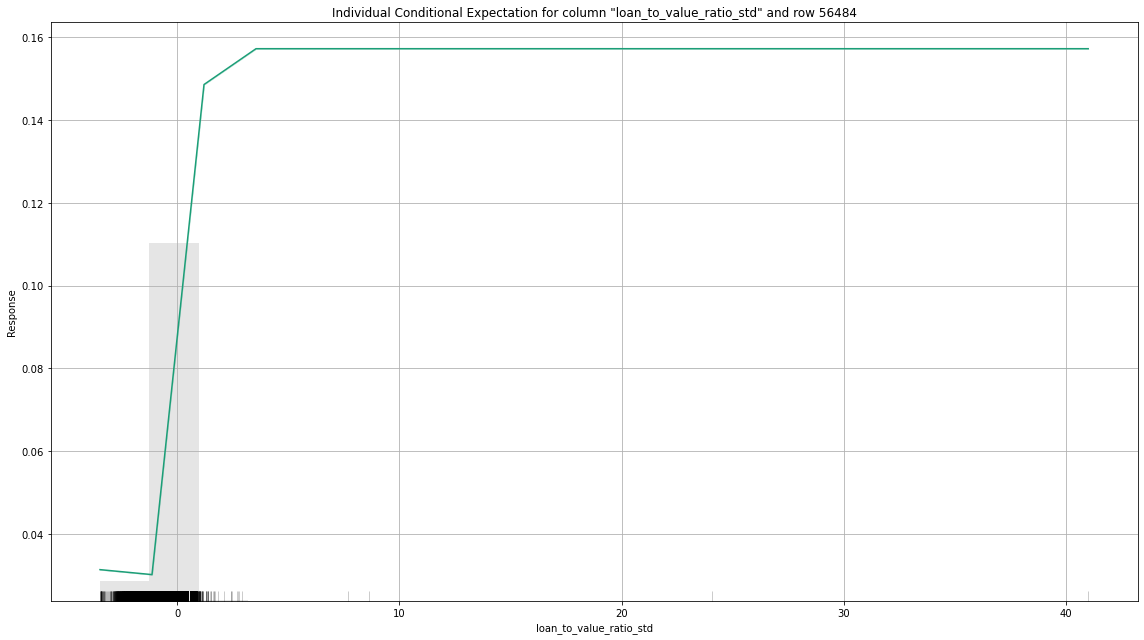

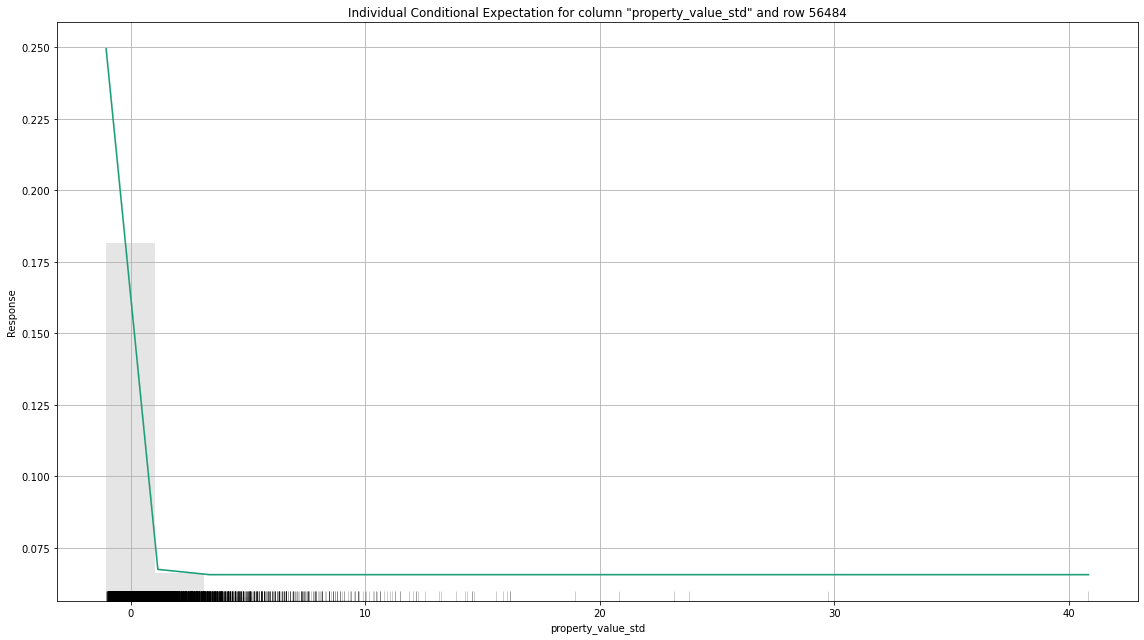

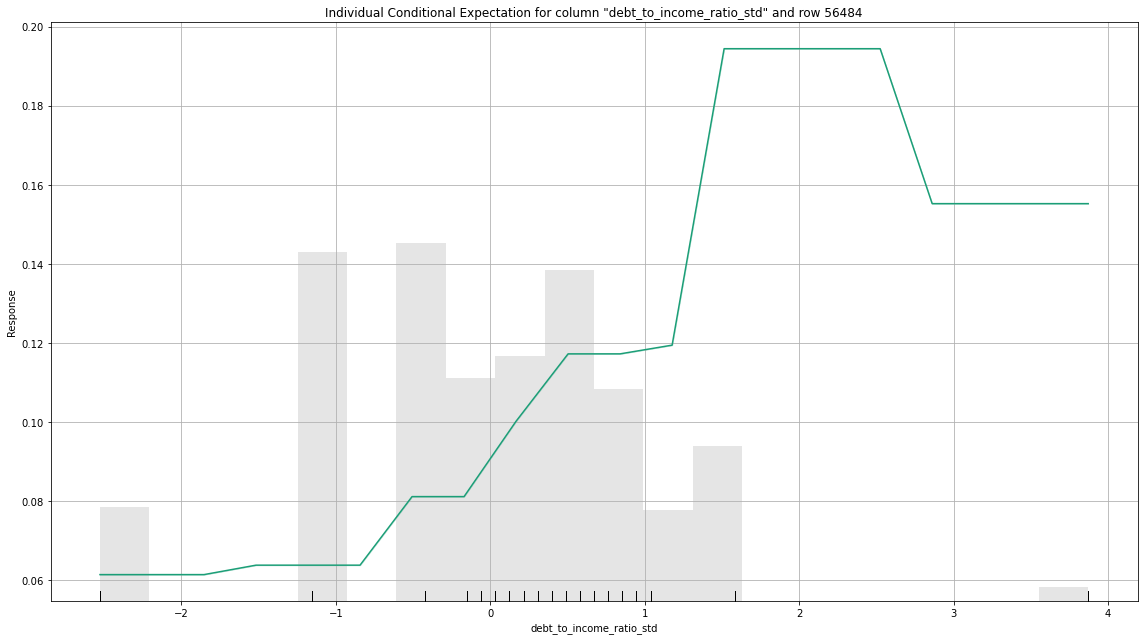

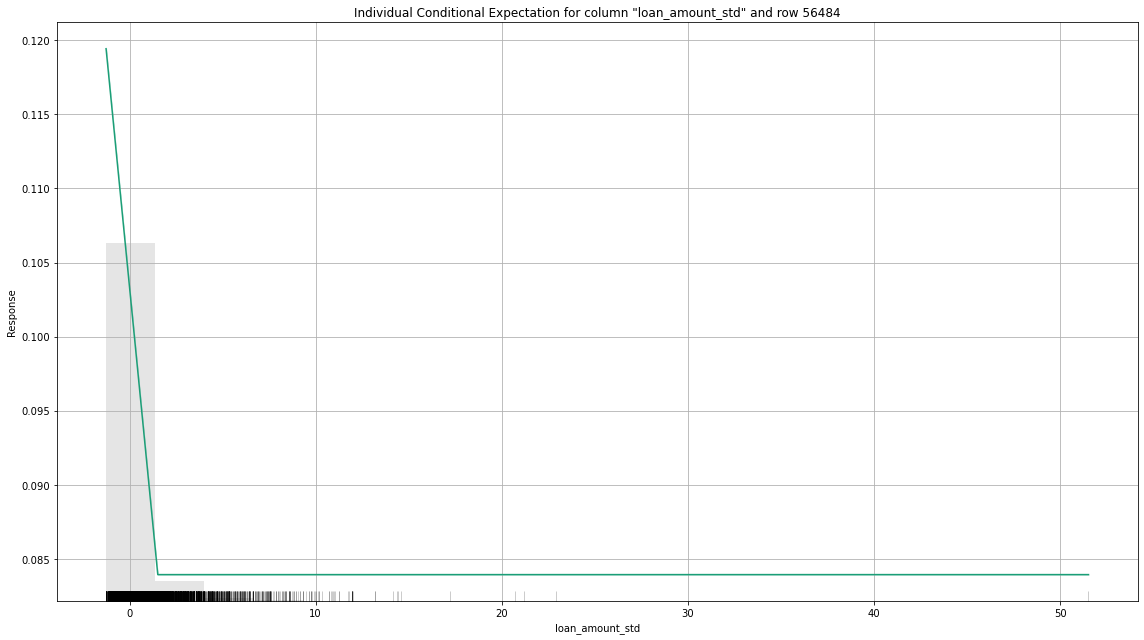

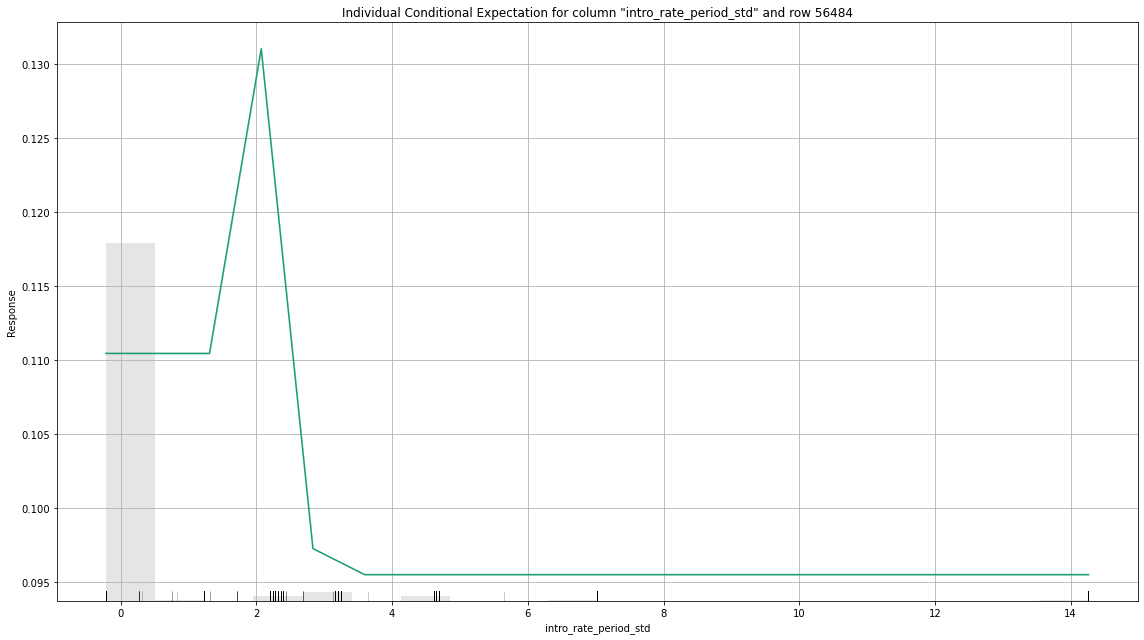

In [37]:
# Explain 90 percentile
gbm_h2o.explain_row(hvalid, row_index=56484)

## Calculate and Plot Feature Behavior.

### MGBM

In [38]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'mgbm':
        temp_df['partial_dependence'] = best_gbm.predict(h2o.H2OFrame(temp_df))['1.0'].as_data_frame()
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

In [39]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'mgbm'])
    first_pd = par_dep(name, valid[x_names], best_gbm, 'mgbm')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['mgbm'] = first_pd['partial_dependence']
    
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 787.55 s.


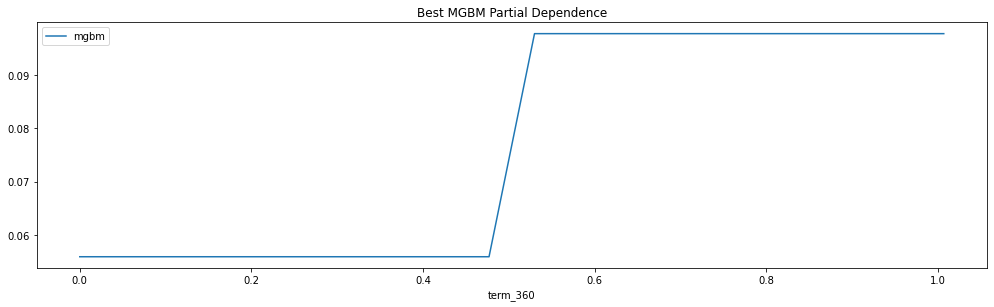

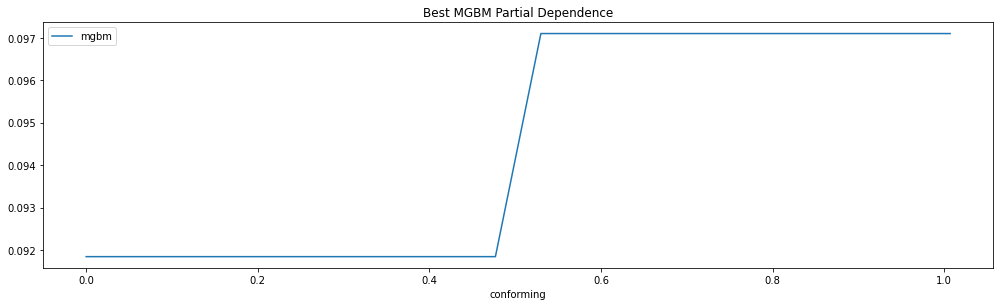

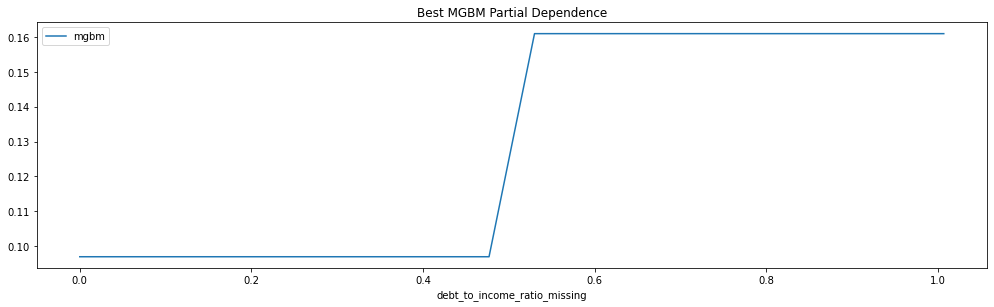

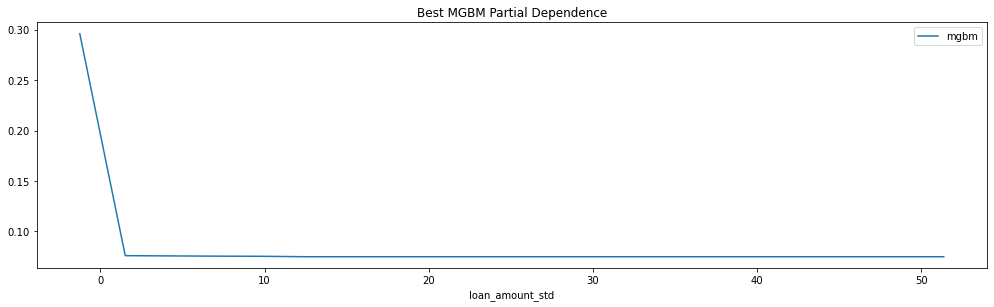

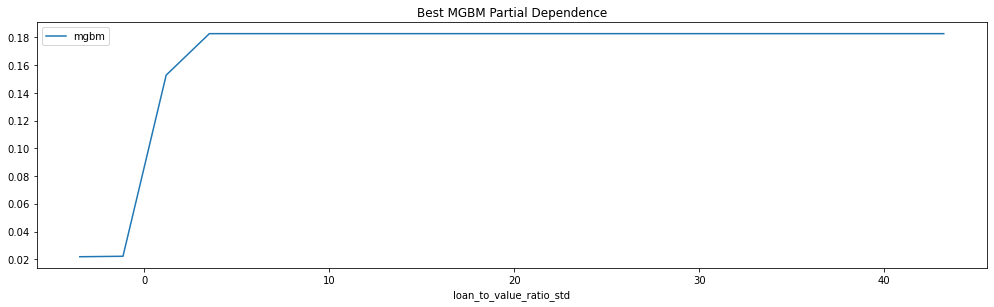

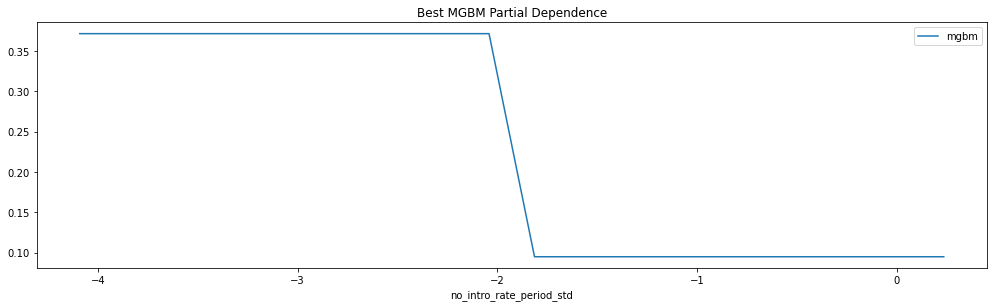

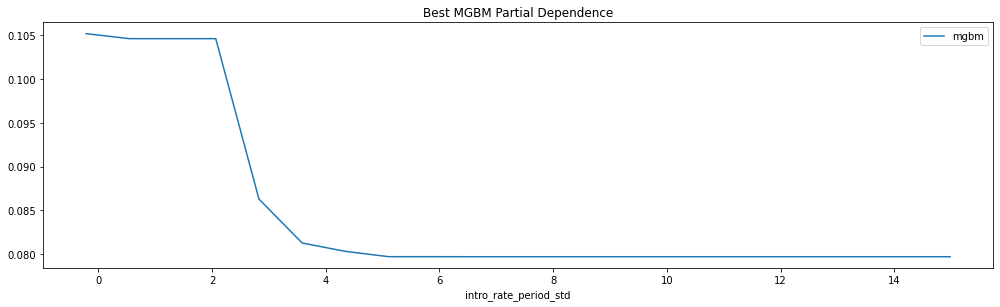

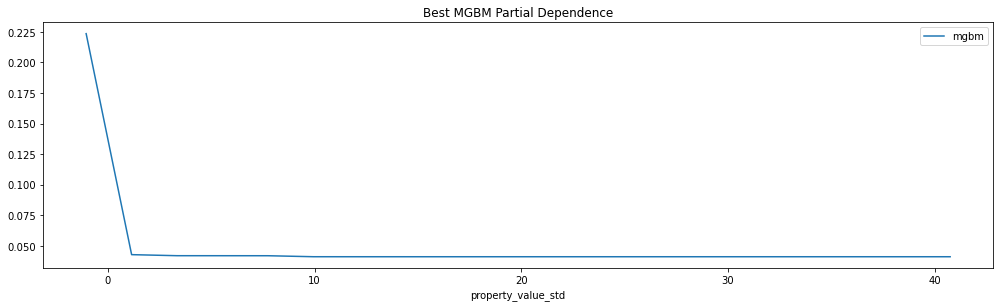

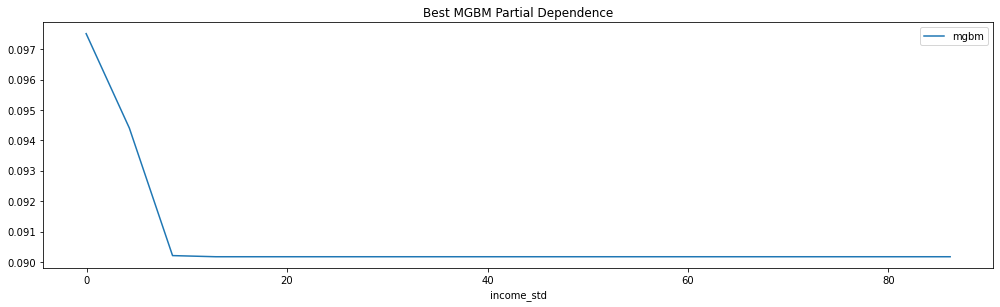

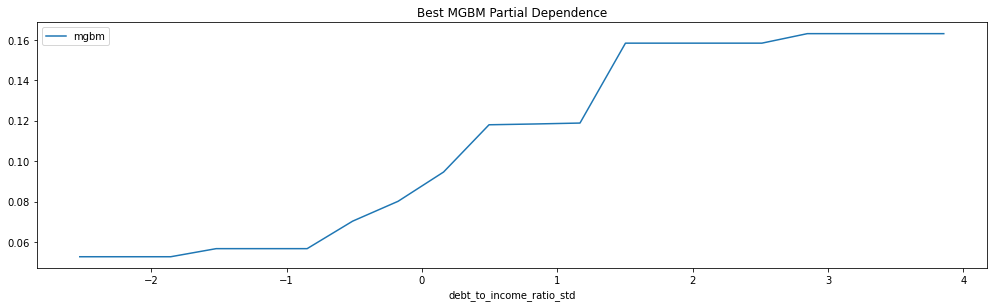

In [40]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init 3-pane plot
    fig, (ax0) = plt.subplots(ncols=1, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='mgbm', ax=ax0, title='Best MGBM Partial Dependence')
    ax0.set_xlabel(name)
   

### GBM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_2_AutoML_20210609_002403


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16963304520381733: 


0.0      1.0   Error                 Rate
0    0.0  83283.0  17819.0  0.1762   (17819.0/101102.0)
1    1.0   4148.0   6732.0  0.3812     (4148.0/10880.0)
2  Total  87431.0  24551.0  0.1962   (21967.0/111982.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

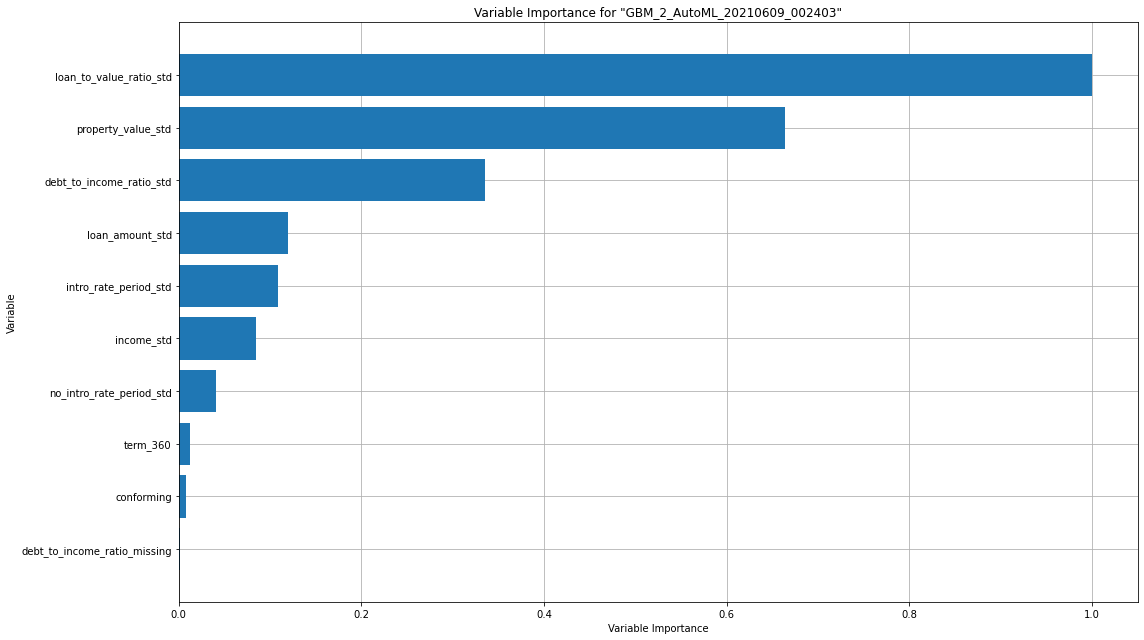

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

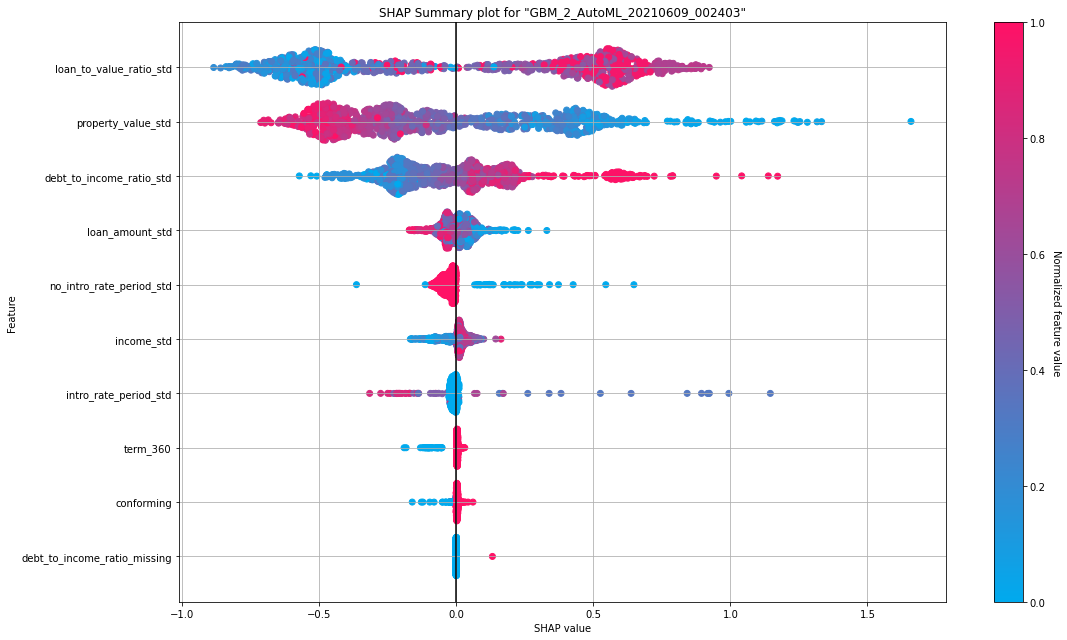

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

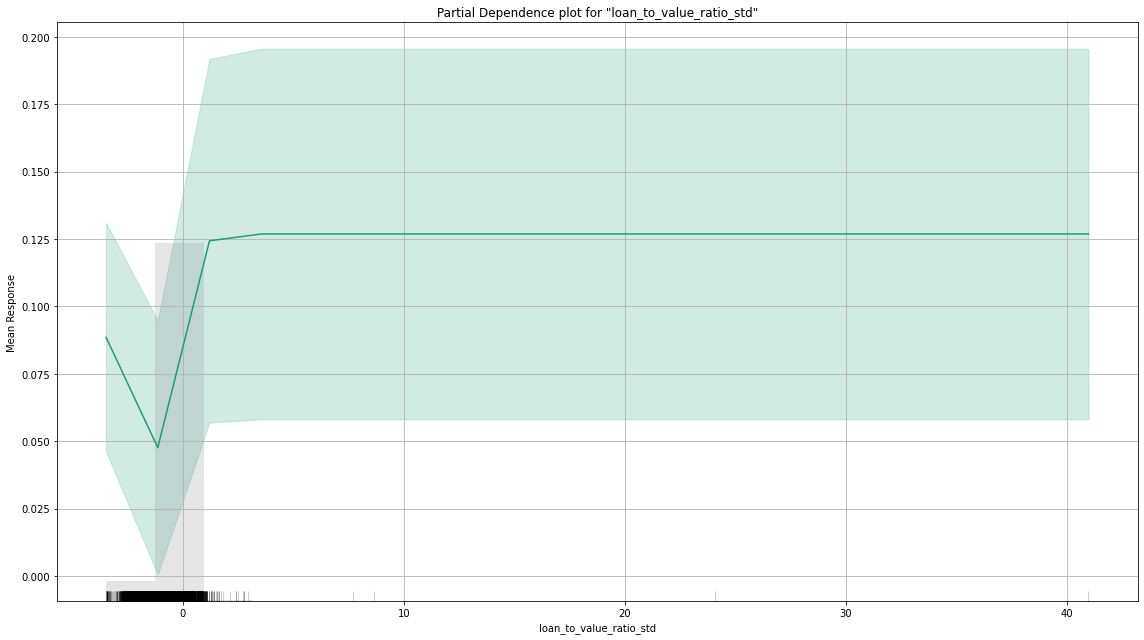

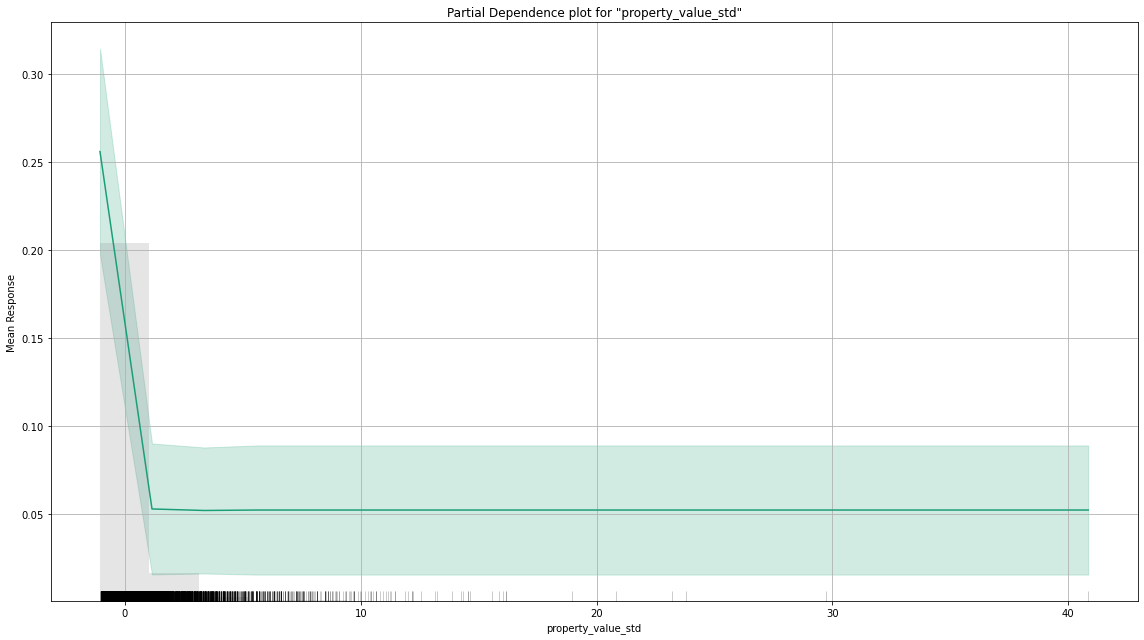

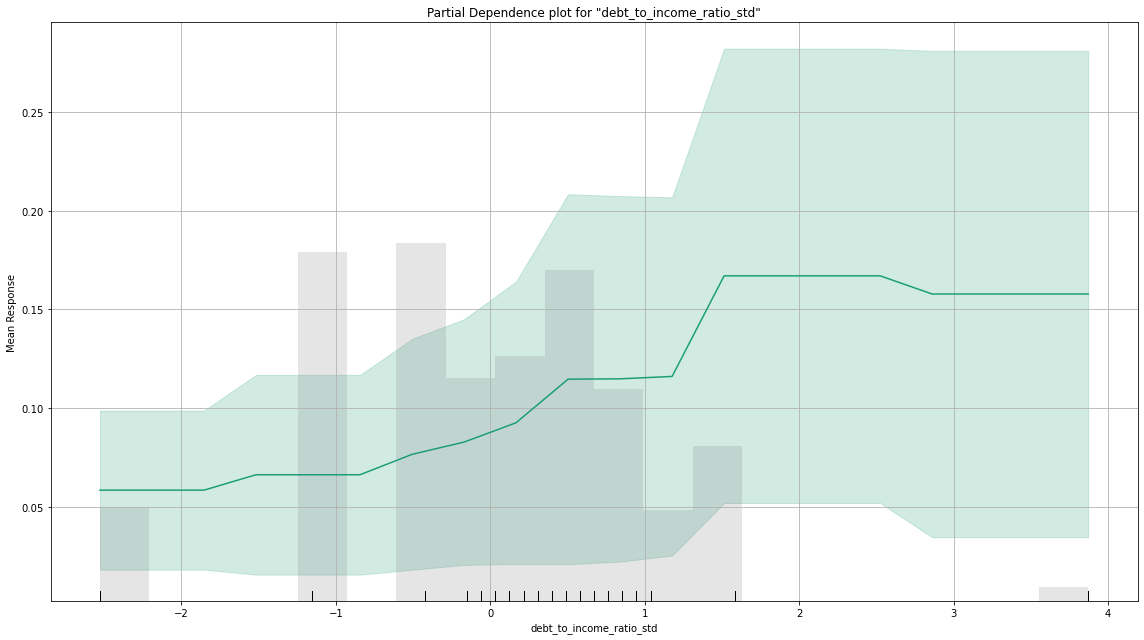

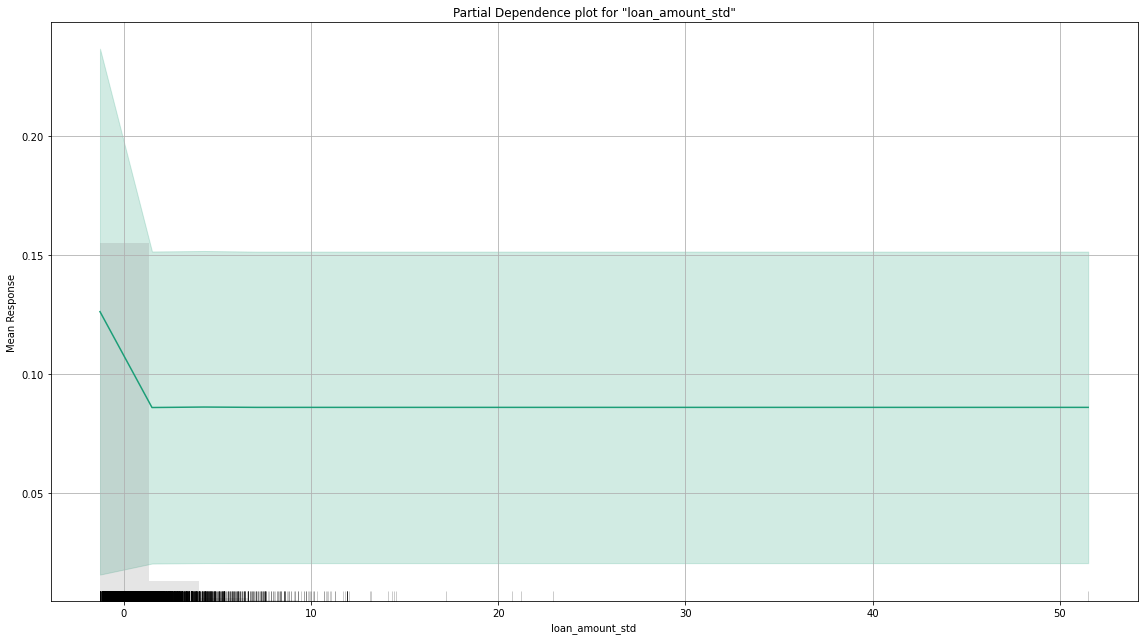

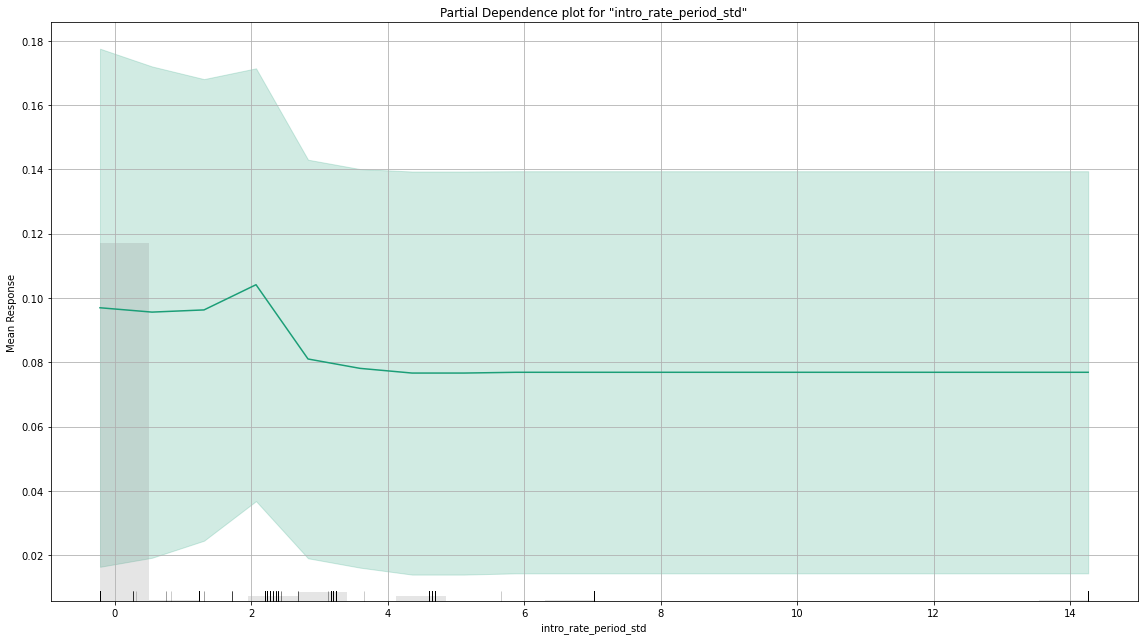

In [41]:
exa_gbm = gbm_h2o.explain(hvalid)

### Ensenble

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210609_002403


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1841705855944178: 


0.0     1.0   Error              Rate
0    0.0  7393.0  1568.0   0.175   (1568.0/8961.0)
1    1.0   353.0   606.0  0.3681     (353.0/959.0)
2  Total  7746.0  2174.0  0.1936   (1921.0/9920.0)

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

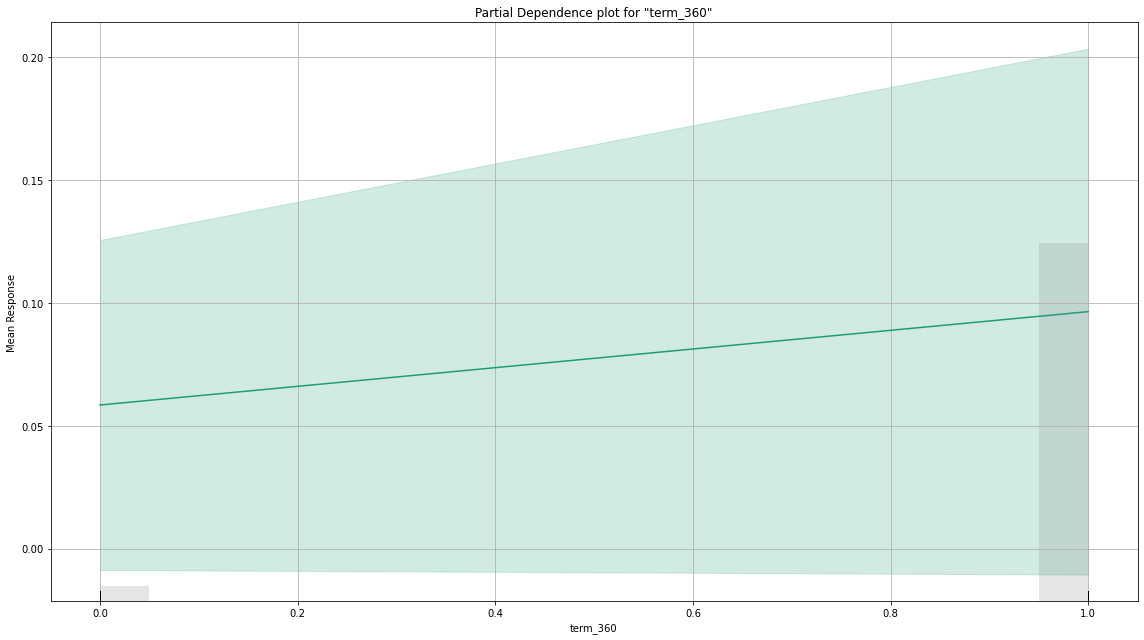

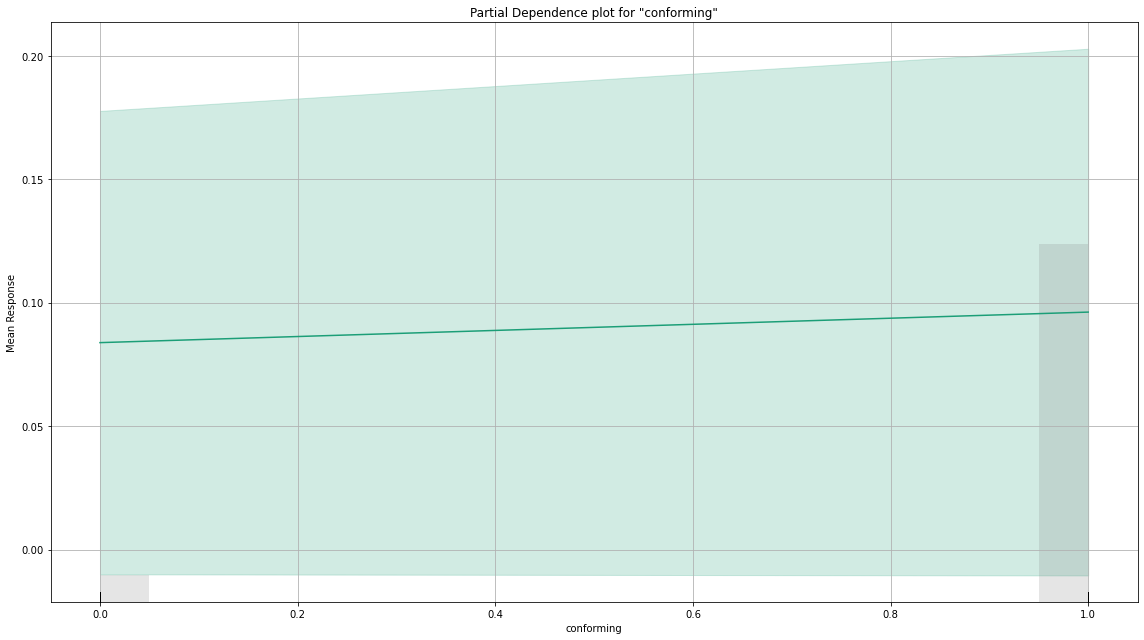

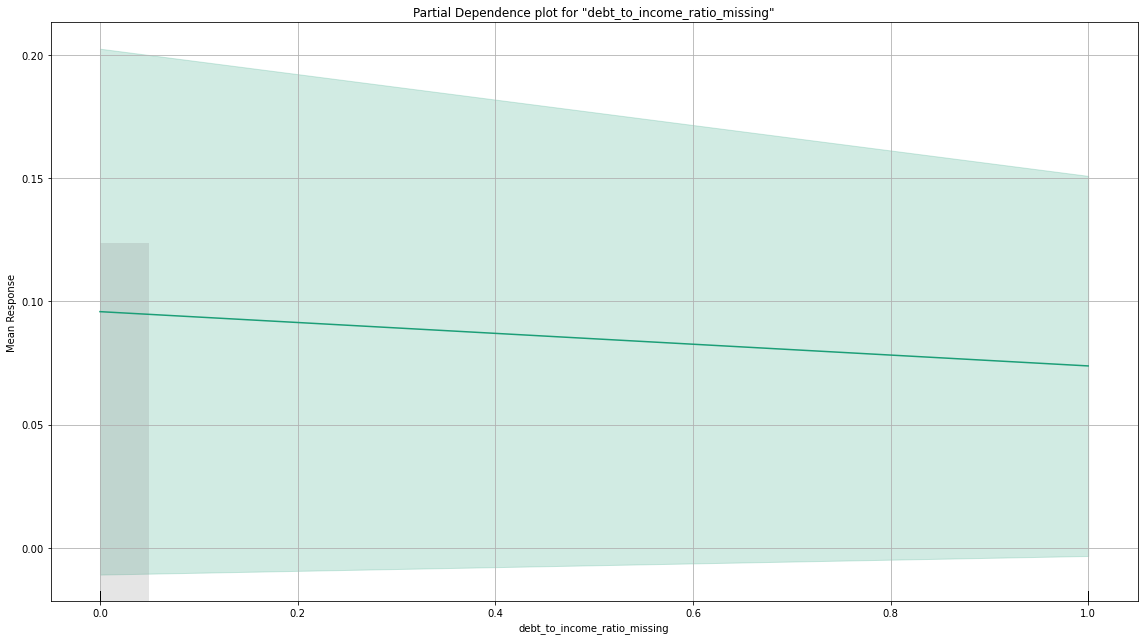

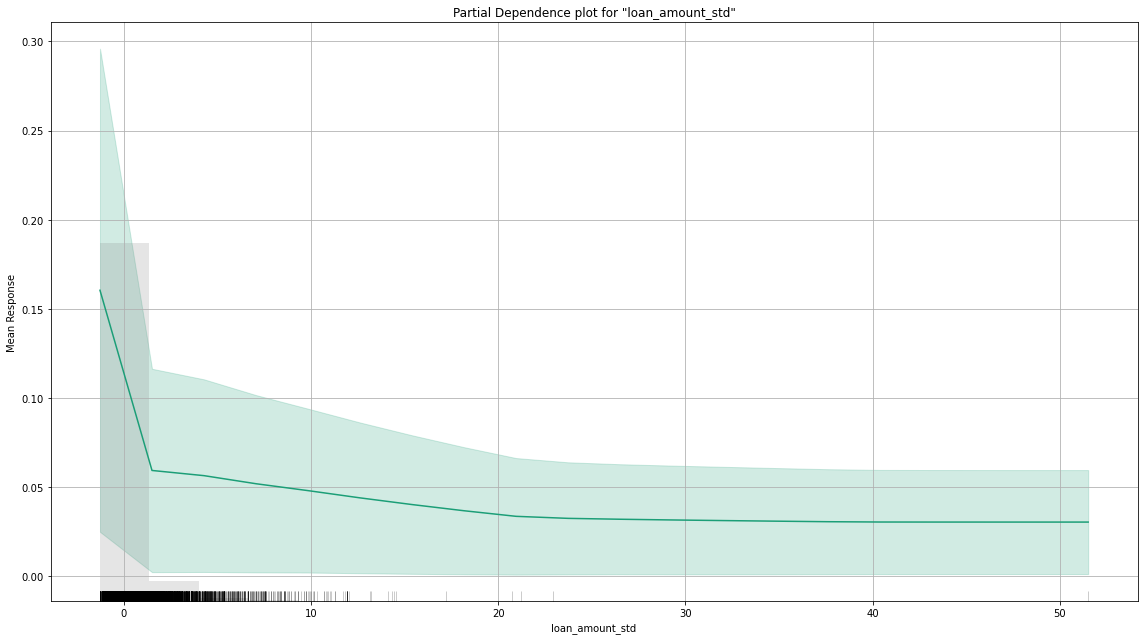

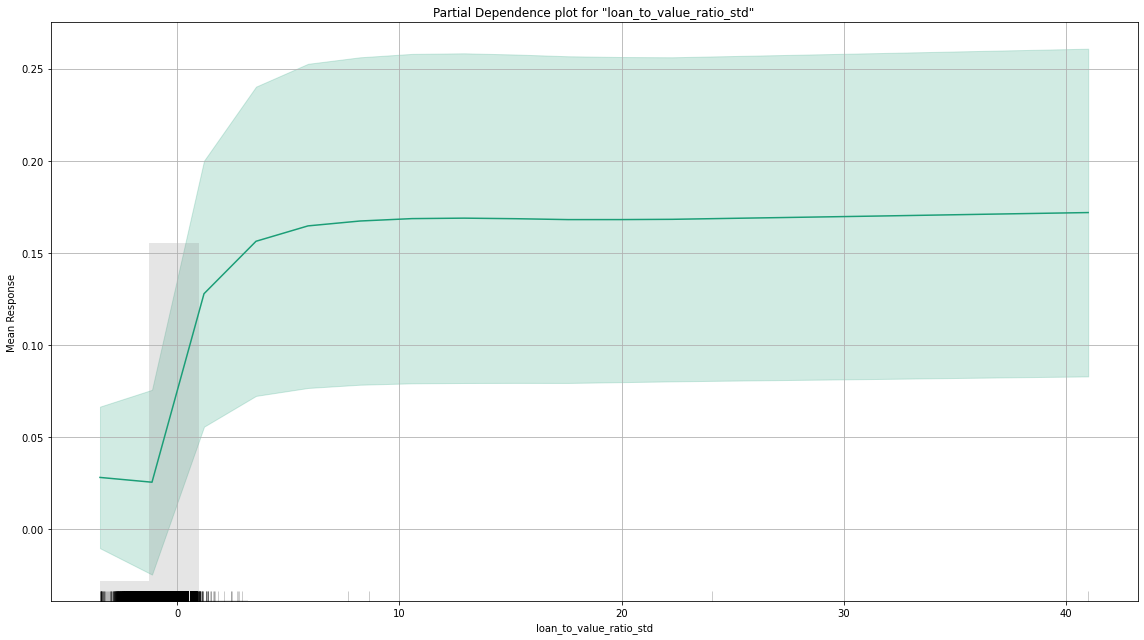

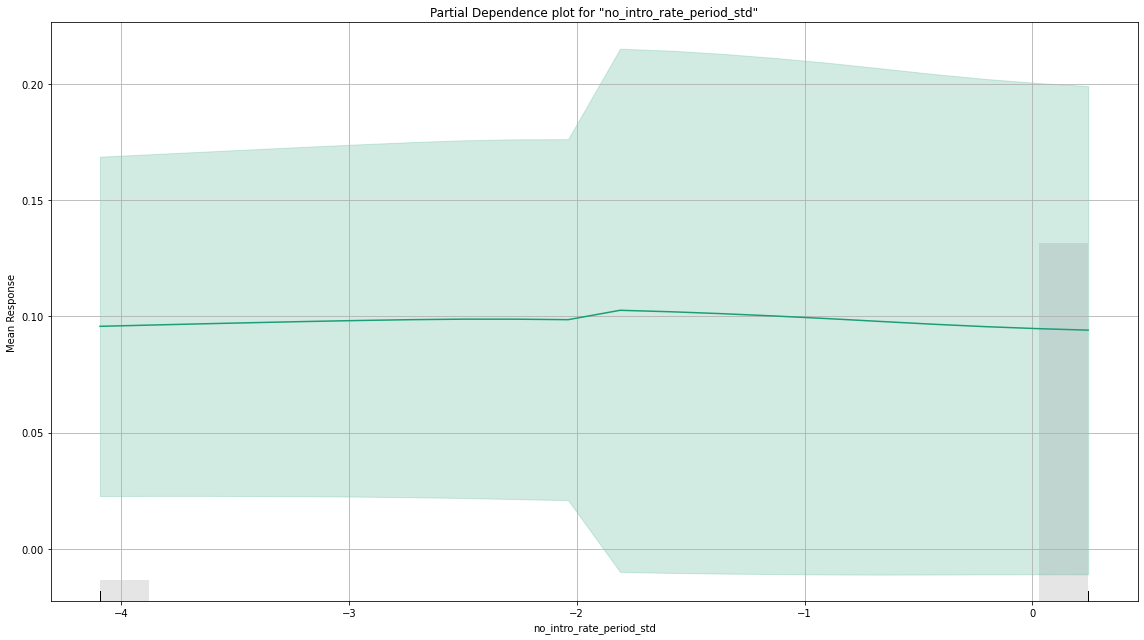

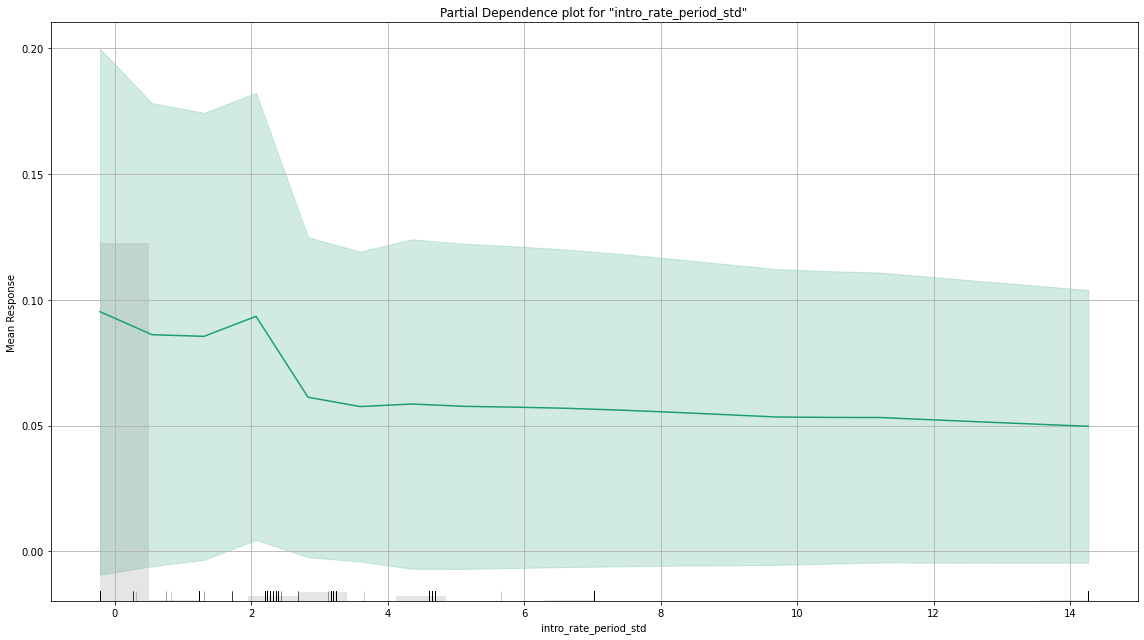

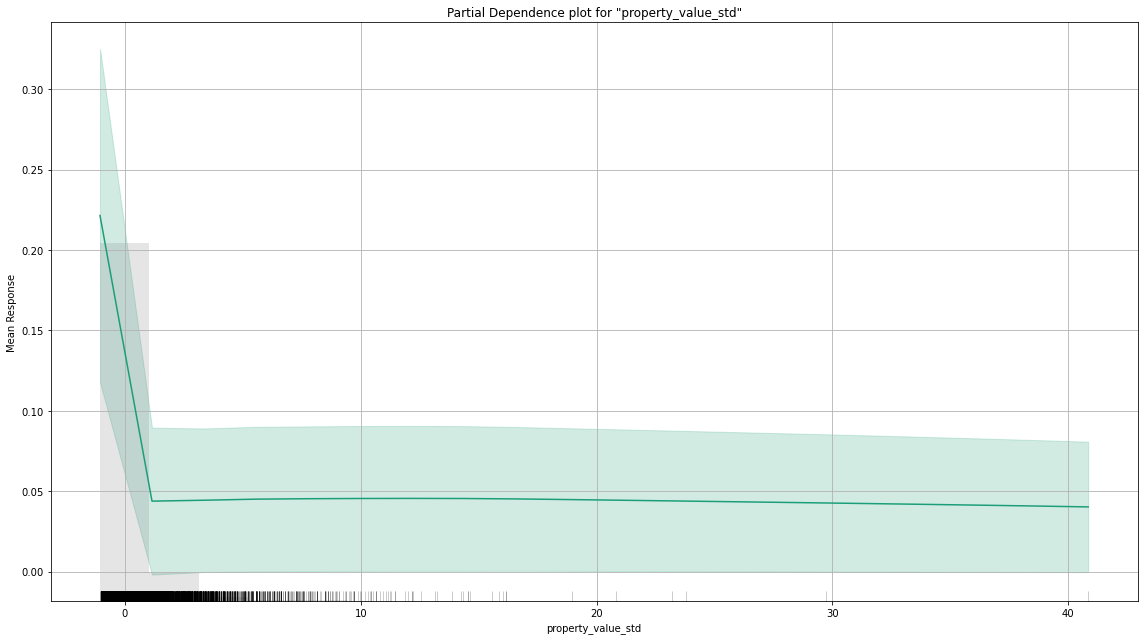

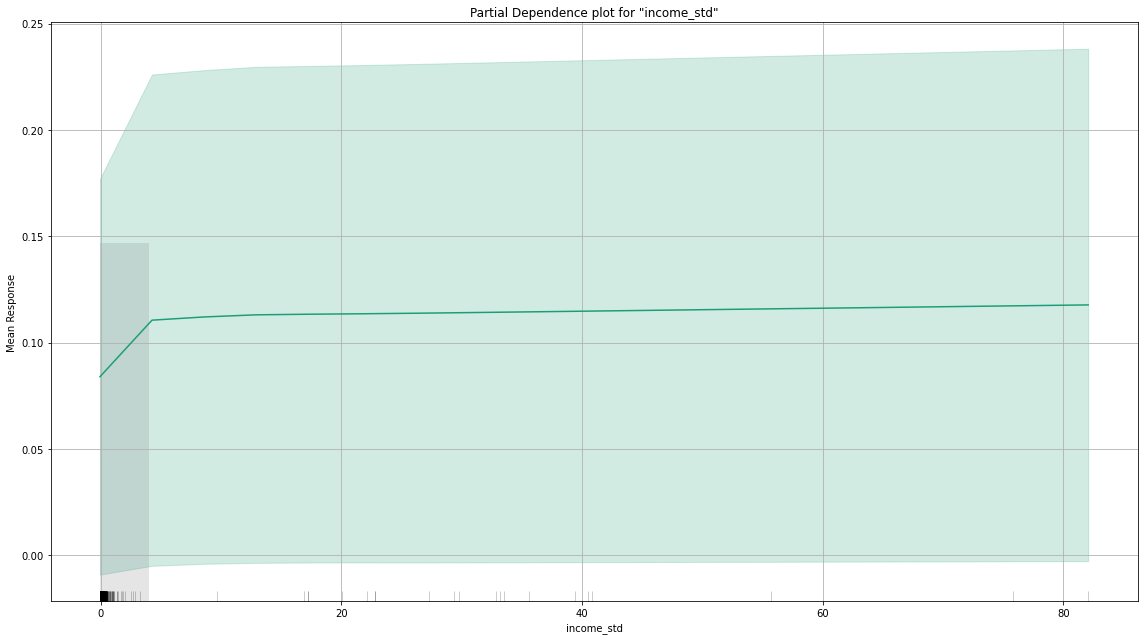

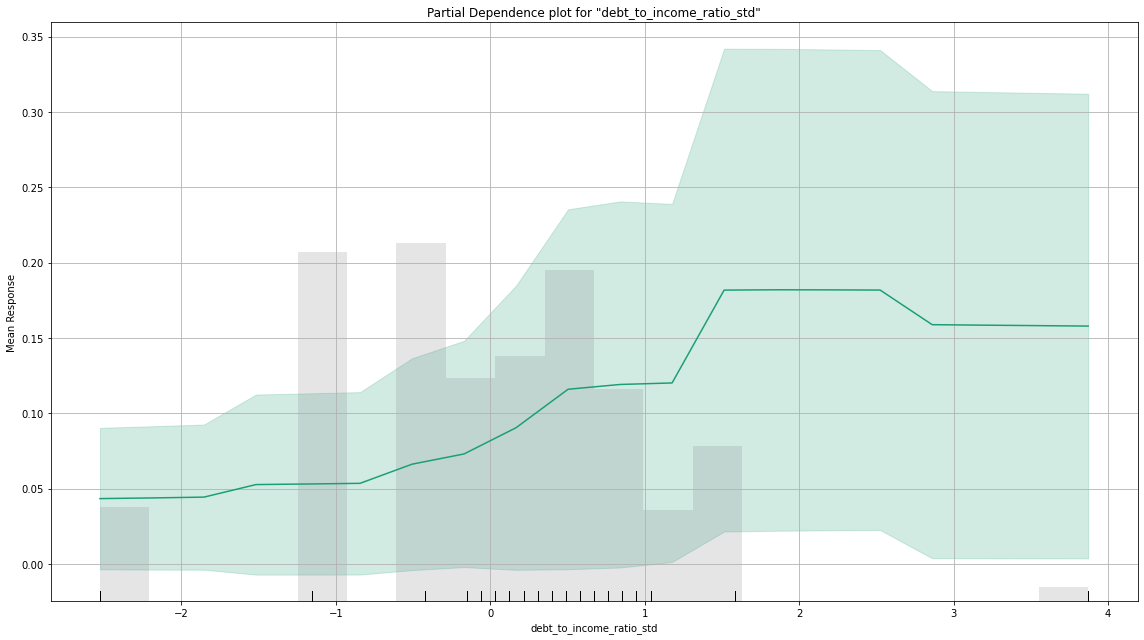

In [42]:
exa_ensenble = ensenble_h2o.explain(hvalid)

In [44]:
# end global timer 
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1541.66 s.


In [45]:
# shutdown h2o
h2o.cluster().shutdown(prompt=False)

H2O session _sid_a6dc closed.
